In [1]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4348534642801378910,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1201828047288127977
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6918604064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12221037848000948466
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12683319750908478969
 physical_device_desc: "device: XLA_GPU device"]

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D, concatenate, AveragePooling2D, Input, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
print(os.listdir("./input"))

['sampleSubmission.csv', 'test1', 'train']


In [5]:
epoch = 3
batch_size = 5
image_size = 224

In [6]:
#load data

filenames = os.listdir("./input/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


<AxesSubplot:>

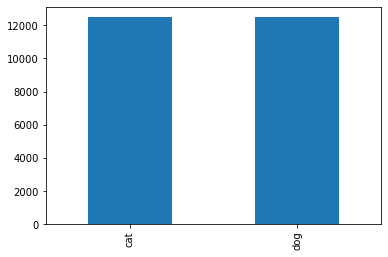

In [7]:
df['category'].value_counts().plot.bar()

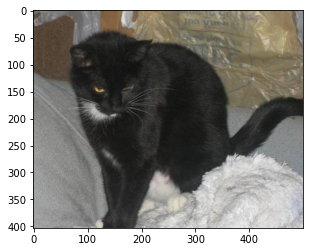

In [8]:
# see sample image

sample = random.choice(filenames)
image = load_img("./input/train/train/"+sample)
plt.imshow(image)

In [9]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    module = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return module

In [10]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(0.2)

In [11]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/r

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/repli

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/r

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task

In [12]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalN

In [45]:
model.compile(
    loss='_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy']
)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

In [46]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [47]:
# prepare train & test data

from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [48]:
# training generator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./input/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.


In [49]:
# validation generator

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./input/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


In [50]:
history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    verbose=1
)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device 

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  24/4500 [..............................] - ETA: 3:16 - loss: 5.5184 - output_loss: 2.0340 - auxilliary_output_1_loss: 1.7603 - auxilliary_output_2_loss: 1.7241 - output_accuracy: 0.4833 - auxilliary_output_1_accuracy: 0.5583 - auxilliary_output_2_accuracy: 0.5000Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  26/4500 [..............................] - ETA: 3:15 - loss: 5.3790 - output_loss: 1.9720 - auxilliary_output_1_loss: 1.7199 - auxilliary_output_2_loss: 1.6871 - output_accuracy: 0.4846 - auxilliary_output_1_accuracy: 0.5538 - auxilliary_output_2_accuracy: 0.4923Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:

  58/4500 [..............................] - ETA: 3:06 - loss: 4.2081 - output_loss: 1.4797 - auxilliary_output_1_loss: 1.3697 - auxilliary_output_2_loss: 1.3586 - output_accuracy: 0.3379 - auxilliary_output_1_accuracy: 0.5103 - auxilliary_output_2_accuracy: 0.4793Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  60/4500 [..............................] - ETA: 3:05 - loss: 4.1896 - output_loss: 1.4708 - auxilliary_output_1_loss: 1.3646 - auxilliary_output_2_loss: 1.3542 - output_accuracy: 0.3333 - auxilliary_output_1_accuracy: 0.5133 - auxilliary_output_2_accuracy: 0.4833Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  62/4500 [..............................] - ETA: 3:05 - loss:

  92/4500 [..............................] - ETA: 3:02 - loss: 4.0164 - output_loss: 1.3860 - auxilliary_output_1_loss: 1.3173 - auxilliary_output_2_loss: 1.3131 - output_accuracy: 0.2565 - auxilliary_output_1_accuracy: 0.5000 - auxilliary_output_2_accuracy: 0.4870Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  94/4500 [..............................] - ETA: 3:01 - loss: 4.0084 - output_loss: 1.3823 - auxilliary_output_1_loss: 1.3151 - auxilliary_output_2_loss: 1.3110 - output_accuracy: 0.2532 - auxilliary_output_1_accuracy: 0.4979 - auxilliary_output_2_accuracy: 0.4830Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  96/4500 [..............................] - ETA: 3:01 - loss:

 126/4500 [..............................] - ETA: 2:59 - loss: 3.9985 - output_loss: 1.3673 - auxilliary_output_1_loss: 1.3168 - auxilliary_output_2_loss: 1.3144 - output_accuracy: 0.2127 - auxilliary_output_1_accuracy: 0.4889 - auxilliary_output_2_accuracy: 0.4857Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 128/4500 [..............................] - ETA: 2:59 - loss: 4.0031 - output_loss: 1.3683 - auxilliary_output_1_loss: 1.3185 - auxilliary_output_2_loss: 1.3162 - output_accuracy: 0.2094 - auxilliary_output_1_accuracy: 0.4844 - auxilliary_output_2_accuracy: 0.4844Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 130/4500 [..............................] - ETA: 2:59 - loss:

 160/4500 [>.............................] - ETA: 2:57 - loss: 3.8626 - output_loss: 1.3150 - auxilliary_output_1_loss: 1.2746 - auxilliary_output_2_loss: 1.2730 - output_accuracy: 0.1963 - auxilliary_output_1_accuracy: 0.4437 - auxilliary_output_2_accuracy: 0.4888Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 162/4500 [>.............................] - ETA: 2:57 - loss: 3.8843 - output_loss: 1.3219 - auxilliary_output_1_loss: 1.2820 - auxilliary_output_2_loss: 1.2803 - output_accuracy: 0.1938 - auxilliary_output_1_accuracy: 0.4444 - auxilliary_output_2_accuracy: 0.4852Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 164/4500 [>.............................] - ETA: 2:57 - loss:

 194/4500 [>.............................] - ETA: 2:55 - loss: 3.8148 - output_loss: 1.2946 - auxilliary_output_1_loss: 1.2609 - auxilliary_output_2_loss: 1.2594 - output_accuracy: 0.1866 - auxilliary_output_1_accuracy: 0.4134 - auxilliary_output_2_accuracy: 0.4660Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 196/4500 [>.............................] - ETA: 2:55 - loss: 3.8129 - output_loss: 1.2937 - auxilliary_output_1_loss: 1.2603 - auxilliary_output_2_loss: 1.2589 - output_accuracy: 0.1847 - auxilliary_output_1_accuracy: 0.4102 - auxilliary_output_2_accuracy: 0.4633Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 198/4500 [>.............................] - ETA: 2:55 - loss:

 228/4500 [>.............................] - ETA: 2:54 - loss: 3.7928 - output_loss: 1.2841 - auxilliary_output_1_loss: 1.2549 - auxilliary_output_2_loss: 1.2537 - output_accuracy: 0.1728 - auxilliary_output_1_accuracy: 0.3877 - auxilliary_output_2_accuracy: 0.4404Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 230/4500 [>.............................] - ETA: 2:54 - loss: 3.7798 - output_loss: 1.2796 - auxilliary_output_1_loss: 1.2507 - auxilliary_output_2_loss: 1.2495 - output_accuracy: 0.1722 - auxilliary_output_1_accuracy: 0.3887 - auxilliary_output_2_accuracy: 0.4400Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 232/4500 [>.............................] - ETA: 2:54 - loss:

 262/4500 [>.............................] - ETA: 2:52 - loss: 3.7661 - output_loss: 1.2730 - auxilliary_output_1_loss: 1.2471 - auxilliary_output_2_loss: 1.2461 - output_accuracy: 0.1656 - auxilliary_output_1_accuracy: 0.3779 - auxilliary_output_2_accuracy: 0.4168Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 264/4500 [>.............................] - ETA: 2:52 - loss: 3.7601 - output_loss: 1.2708 - auxilliary_output_1_loss: 1.2451 - auxilliary_output_2_loss: 1.2441 - output_accuracy: 0.1644 - auxilliary_output_1_accuracy: 0.3758 - auxilliary_output_2_accuracy: 0.4159Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 266/4500 [>.............................] - ETA: 2:52 - loss:

 296/4500 [>.............................] - ETA: 2:51 - loss: 3.7544 - output_loss: 1.2673 - auxilliary_output_1_loss: 1.2440 - auxilliary_output_2_loss: 1.2431 - output_accuracy: 0.1601 - auxilliary_output_1_accuracy: 0.3676 - auxilliary_output_2_accuracy: 0.4041Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 298/4500 [>.............................] - ETA: 2:50 - loss: 3.7580 - output_loss: 1.2684 - auxilliary_output_1_loss: 1.2452 - auxilliary_output_2_loss: 1.2444 - output_accuracy: 0.1597 - auxilliary_output_1_accuracy: 0.3658 - auxilliary_output_2_accuracy: 0.4027Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 300/4500 [=>............................] - ETA: 2:50 - loss:

 330/4500 [=>............................] - ETA: 2:49 - loss: 3.7611 - output_loss: 1.2682 - auxilliary_output_1_loss: 1.2468 - auxilliary_output_2_loss: 1.2461 - output_accuracy: 0.1533 - auxilliary_output_1_accuracy: 0.3606 - auxilliary_output_2_accuracy: 0.3915Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 332/4500 [=>............................] - ETA: 2:49 - loss: 3.7682 - output_loss: 1.2705 - auxilliary_output_1_loss: 1.2492 - auxilliary_output_2_loss: 1.2485 - output_accuracy: 0.1542 - auxilliary_output_1_accuracy: 0.3584 - auxilliary_output_2_accuracy: 0.3910Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 334/4500 [=>............................] - ETA: 2:49 - loss:

 364/4500 [=>............................] - ETA: 2:47 - loss: 3.7882 - output_loss: 1.2761 - auxilliary_output_1_loss: 1.2564 - auxilliary_output_2_loss: 1.2557 - output_accuracy: 0.1522 - auxilliary_output_1_accuracy: 0.3484 - auxilliary_output_2_accuracy: 0.3830Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 366/4500 [=>............................] - ETA: 2:47 - loss: 3.7909 - output_loss: 1.2769 - auxilliary_output_1_loss: 1.2573 - auxilliary_output_2_loss: 1.2567 - output_accuracy: 0.1525 - auxilliary_output_1_accuracy: 0.3470 - auxilliary_output_2_accuracy: 0.3836Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 368/4500 [=>............................] - ETA: 2:47 - loss:

 398/4500 [=>............................] - ETA: 2:46 - loss: 3.7774 - output_loss: 1.2715 - auxilliary_output_1_loss: 1.2532 - auxilliary_output_2_loss: 1.2526 - output_accuracy: 0.1508 - auxilliary_output_1_accuracy: 0.3432 - auxilliary_output_2_accuracy: 0.3799Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 400/4500 [=>............................] - ETA: 2:46 - loss: 3.7700 - output_loss: 1.2690 - auxilliary_output_1_loss: 1.2508 - auxilliary_output_2_loss: 1.2502 - output_accuracy: 0.1520 - auxilliary_output_1_accuracy: 0.3430 - auxilliary_output_2_accuracy: 0.3795Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 402/4500 [=>............................] - ETA: 2:46 - loss:

 432/4500 [=>............................] - ETA: 2:44 - loss: 3.7897 - output_loss: 1.2749 - auxilliary_output_1_loss: 1.2577 - auxilliary_output_2_loss: 1.2571 - output_accuracy: 0.1505 - auxilliary_output_1_accuracy: 0.3361 - auxilliary_output_2_accuracy: 0.3718Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 434/4500 [=>............................] - ETA: 2:44 - loss: 3.7829 - output_loss: 1.2725 - auxilliary_output_1_loss: 1.2554 - auxilliary_output_2_loss: 1.2549 - output_accuracy: 0.1498 - auxilliary_output_1_accuracy: 0.3364 - auxilliary_output_2_accuracy: 0.3710Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 436/4500 [=>............................] - ETA: 2:44 - loss:

 466/4500 [==>...........................] - ETA: 2:43 - loss: 3.7690 - output_loss: 1.2673 - auxilliary_output_1_loss: 1.2511 - auxilliary_output_2_loss: 1.2506 - output_accuracy: 0.1446 - auxilliary_output_1_accuracy: 0.3309 - auxilliary_output_2_accuracy: 0.3631Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 468/4500 [==>...........................] - ETA: 2:43 - loss: 3.7655 - output_loss: 1.2661 - auxilliary_output_1_loss: 1.2500 - auxilliary_output_2_loss: 1.2495 - output_accuracy: 0.1444 - auxilliary_output_1_accuracy: 0.3299 - auxilliary_output_2_accuracy: 0.3620Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 470/4500 [==>...........................] - ETA: 2:43 - loss:

 500/4500 [==>...........................] - ETA: 2:42 - loss: 3.7642 - output_loss: 1.2651 - auxilliary_output_1_loss: 1.2498 - auxilliary_output_2_loss: 1.2493 - output_accuracy: 0.1452 - auxilliary_output_1_accuracy: 0.3296 - auxilliary_output_2_accuracy: 0.3576Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 502/4500 [==>...........................] - ETA: 2:42 - loss: 3.7637 - output_loss: 1.2649 - auxilliary_output_1_loss: 1.2496 - auxilliary_output_2_loss: 1.2492 - output_accuracy: 0.1454 - auxilliary_output_1_accuracy: 0.3295 - auxilliary_output_2_accuracy: 0.3570Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 504/4500 [==>...........................] - ETA: 2:42 - loss:

 534/4500 [==>...........................] - ETA: 2:40 - loss: 3.7651 - output_loss: 1.2649 - auxilliary_output_1_loss: 1.2503 - auxilliary_output_2_loss: 1.2499 - output_accuracy: 0.1449 - auxilliary_output_1_accuracy: 0.3258 - auxilliary_output_2_accuracy: 0.3521Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 536/4500 [==>...........................] - ETA: 2:40 - loss: 3.7670 - output_loss: 1.2655 - auxilliary_output_1_loss: 1.2510 - auxilliary_output_2_loss: 1.2506 - output_accuracy: 0.1455 - auxilliary_output_1_accuracy: 0.3250 - auxilliary_output_2_accuracy: 0.3522Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 538/4500 [==>...........................] - ETA: 2:40 - loss:

 568/4500 [==>...........................] - ETA: 2:39 - loss: 3.7425 - output_loss: 1.2568 - auxilliary_output_1_loss: 1.2430 - auxilliary_output_2_loss: 1.2426 - output_accuracy: 0.1444 - auxilliary_output_1_accuracy: 0.3204 - auxilliary_output_2_accuracy: 0.3507Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 570/4500 [==>...........................] - ETA: 2:39 - loss: 3.7444 - output_loss: 1.2574 - auxilliary_output_1_loss: 1.2437 - auxilliary_output_2_loss: 1.2433 - output_accuracy: 0.1446 - auxilliary_output_1_accuracy: 0.3211 - auxilliary_output_2_accuracy: 0.3498Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 572/4500 [==>...........................] - ETA: 2:39 - loss:

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 603/4500 [===>..........................] - ETA: 2:38 - loss: 3.7453 - output_loss: 1.2574 - auxilliary_output_1_loss: 1.2442 - auxilliary_output_2_loss: 1.2438 - output_accuracy: 0.1439 - auxilliary_output_1_accuracy: 0.3181 - auxilliary_output_2_accuracy: 0.3430Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 605/4500 [===>..........................] - ETA: 2:38 - loss: 3.7405 - output_loss: 1.2557 - auxilliary_output_1_loss: 1.2426 - auxilliary_output_2_loss: 1.2422 - output_accuracy: 0.1435 - auxilliary_output_1_accuracy: 0.3183 - auxilliary_output_2_accuracy: 0.3431Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:

 637/4500 [===>..........................] - ETA: 2:36 - loss: 3.7199 - output_loss: 1.2485 - auxilliary_output_1_loss: 1.2359 - auxilliary_output_2_loss: 1.2355 - output_accuracy: 0.1438 - auxilliary_output_1_accuracy: 0.3121 - auxilliary_output_2_accuracy: 0.3397Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 639/4500 [===>..........................] - ETA: 2:36 - loss: 3.7217 - output_loss: 1.2491 - auxilliary_output_1_loss: 1.2365 - auxilliary_output_2_loss: 1.2361 - output_accuracy: 0.1443 - auxilliary_output_1_accuracy: 0.3117 - auxilliary_output_2_accuracy: 0.3393Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 641/4500 [===>..........................] - ETA: 2:36 - loss:

 671/4500 [===>..........................] - ETA: 2:35 - loss: 3.7346 - output_loss: 1.2531 - auxilliary_output_1_loss: 1.2409 - auxilliary_output_2_loss: 1.2406 - output_accuracy: 0.1434 - auxilliary_output_1_accuracy: 0.3100 - auxilliary_output_2_accuracy: 0.3338Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 673/4500 [===>..........................] - ETA: 2:35 - loss: 3.7303 - output_loss: 1.2516 - auxilliary_output_1_loss: 1.2395 - auxilliary_output_2_loss: 1.2391 - output_accuracy: 0.1432 - auxilliary_output_1_accuracy: 0.3097 - auxilliary_output_2_accuracy: 0.3343Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 675/4500 [===>..........................] - ETA: 2:35 - loss:

 705/4500 [===>..........................] - ETA: 2:34 - loss: 3.7384 - output_loss: 1.2541 - auxilliary_output_1_loss: 1.2424 - auxilliary_output_2_loss: 1.2420 - output_accuracy: 0.1430 - auxilliary_output_1_accuracy: 0.3072 - auxilliary_output_2_accuracy: 0.3313Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 707/4500 [===>..........................] - ETA: 2:33 - loss: 3.7381 - output_loss: 1.2539 - auxilliary_output_1_loss: 1.2423 - auxilliary_output_2_loss: 1.2419 - output_accuracy: 0.1431 - auxilliary_output_1_accuracy: 0.3066 - auxilliary_output_2_accuracy: 0.3313Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 709/4500 [===>..........................] - ETA: 2:33 - loss:

 739/4500 [===>..........................] - ETA: 2:32 - loss: 3.7276 - output_loss: 1.2502 - auxilliary_output_1_loss: 1.2389 - auxilliary_output_2_loss: 1.2385 - output_accuracy: 0.1421 - auxilliary_output_1_accuracy: 0.3045 - auxilliary_output_2_accuracy: 0.3283Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 741/4500 [===>..........................] - ETA: 2:32 - loss: 3.7255 - output_loss: 1.2495 - auxilliary_output_1_loss: 1.2382 - auxilliary_output_2_loss: 1.2379 - output_accuracy: 0.1420 - auxilliary_output_1_accuracy: 0.3039 - auxilliary_output_2_accuracy: 0.3285Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 743/4500 [===>..........................] - ETA: 2:32 - loss:

 773/4500 [====>.........................] - ETA: 2:31 - loss: 3.7177 - output_loss: 1.2466 - auxilliary_output_1_loss: 1.2357 - auxilliary_output_2_loss: 1.2354 - output_accuracy: 0.1402 - auxilliary_output_1_accuracy: 0.3025 - auxilliary_output_2_accuracy: 0.3239Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 775/4500 [====>.........................] - ETA: 2:31 - loss: 3.7158 - output_loss: 1.2459 - auxilliary_output_1_loss: 1.2351 - auxilliary_output_2_loss: 1.2347 - output_accuracy: 0.1401 - auxilliary_output_1_accuracy: 0.3025 - auxilliary_output_2_accuracy: 0.3239Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 777/4500 [====>.........................] - ETA: 2:31 - loss:

 807/4500 [====>.........................] - ETA: 2:30 - loss: 3.6956 - output_loss: 1.2390 - auxilliary_output_1_loss: 1.2285 - auxilliary_output_2_loss: 1.2281 - output_accuracy: 0.1398 - auxilliary_output_1_accuracy: 0.3001 - auxilliary_output_2_accuracy: 0.3209Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 809/4500 [====>.........................] - ETA: 2:30 - loss: 3.6937 - output_loss: 1.2383 - auxilliary_output_1_loss: 1.2279 - auxilliary_output_2_loss: 1.2275 - output_accuracy: 0.1402 - auxilliary_output_1_accuracy: 0.2996 - auxilliary_output_2_accuracy: 0.3204Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 811/4500 [====>.........................] - ETA: 2:30 - loss:

 841/4500 [====>.........................] - ETA: 2:28 - loss: 3.6768 - output_loss: 1.2325 - auxilliary_output_1_loss: 1.2223 - auxilliary_output_2_loss: 1.2220 - output_accuracy: 0.1420 - auxilliary_output_1_accuracy: 0.2982 - auxilliary_output_2_accuracy: 0.3187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 843/4500 [====>.........................] - ETA: 2:28 - loss: 3.6782 - output_loss: 1.2329 - auxilliary_output_1_loss: 1.2228 - auxilliary_output_2_loss: 1.2225 - output_accuracy: 0.1419 - auxilliary_output_1_accuracy: 0.2980 - auxilliary_output_2_accuracy: 0.3186Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 845/4500 [====>.........................] - ETA: 2:28 - loss:

 875/4500 [====>.........................] - ETA: 2:27 - loss: 3.6896 - output_loss: 1.2366 - auxilliary_output_1_loss: 1.2267 - auxilliary_output_2_loss: 1.2264 - output_accuracy: 0.1406 - auxilliary_output_1_accuracy: 0.2983 - auxilliary_output_2_accuracy: 0.3166Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 877/4500 [====>.........................] - ETA: 2:27 - loss: 3.6910 - output_loss: 1.2370 - auxilliary_output_1_loss: 1.2271 - auxilliary_output_2_loss: 1.2268 - output_accuracy: 0.1407 - auxilliary_output_1_accuracy: 0.2976 - auxilliary_output_2_accuracy: 0.3168Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 879/4500 [====>.........................] - ETA: 2:27 - loss:

 909/4500 [=====>........................] - ETA: 2:26 - loss: 3.6899 - output_loss: 1.2364 - auxilliary_output_1_loss: 1.2269 - auxilliary_output_2_loss: 1.2266 - output_accuracy: 0.1402 - auxilliary_output_1_accuracy: 0.2972 - auxilliary_output_2_accuracy: 0.3146Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 911/4500 [=====>........................] - ETA: 2:25 - loss: 3.6883 - output_loss: 1.2359 - auxilliary_output_1_loss: 1.2263 - auxilliary_output_2_loss: 1.2260 - output_accuracy: 0.1403 - auxilliary_output_1_accuracy: 0.2973 - auxilliary_output_2_accuracy: 0.3144Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 913/4500 [=====>........................] - ETA: 2:25 - loss:

 943/4500 [=====>........................] - ETA: 2:24 - loss: 3.6915 - output_loss: 1.2368 - auxilliary_output_1_loss: 1.2275 - auxilliary_output_2_loss: 1.2272 - output_accuracy: 0.1402 - auxilliary_output_1_accuracy: 0.2961 - auxilliary_output_2_accuracy: 0.3122Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 945/4500 [=====>........................] - ETA: 2:24 - loss: 3.6942 - output_loss: 1.2377 - auxilliary_output_1_loss: 1.2284 - auxilliary_output_2_loss: 1.2281 - output_accuracy: 0.1403 - auxilliary_output_1_accuracy: 0.2963 - auxilliary_output_2_accuracy: 0.3117Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 947/4500 [=====>........................] - ETA: 2:24 - loss:

 977/4500 [=====>........................] - ETA: 2:23 - loss: 3.6890 - output_loss: 1.2358 - auxilliary_output_1_loss: 1.2267 - auxilliary_output_2_loss: 1.2264 - output_accuracy: 0.1382 - auxilliary_output_1_accuracy: 0.2952 - auxilliary_output_2_accuracy: 0.3089Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 979/4500 [=====>........................] - ETA: 2:23 - loss: 3.6902 - output_loss: 1.2362 - auxilliary_output_1_loss: 1.2271 - auxilliary_output_2_loss: 1.2269 - output_accuracy: 0.1381 - auxilliary_output_1_accuracy: 0.2948 - auxilliary_output_2_accuracy: 0.3089Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 981/4500 [=====>........................] - ETA: 2:22 - loss:

1011/4500 [=====>........................] - ETA: 2:21 - loss: 3.6879 - output_loss: 1.2353 - auxilliary_output_1_loss: 1.2264 - auxilliary_output_2_loss: 1.2262 - output_accuracy: 0.1379 - auxilliary_output_1_accuracy: 0.2926 - auxilliary_output_2_accuracy: 0.3068Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1013/4500 [=====>........................] - ETA: 2:21 - loss: 3.6877 - output_loss: 1.2352 - auxilliary_output_1_loss: 1.2264 - auxilliary_output_2_loss: 1.2261 - output_accuracy: 0.1378 - auxilliary_output_1_accuracy: 0.2926 - auxilliary_output_2_accuracy: 0.3066Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1015/4500 [=====>........................] - ETA: 2:21 - loss:

1045/4500 [=====>........................] - ETA: 2:20 - loss: 3.6755 - output_loss: 1.2310 - auxilliary_output_1_loss: 1.2224 - auxilliary_output_2_loss: 1.2221 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2909 - auxilliary_output_2_accuracy: 0.3055Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1047/4500 [=====>........................] - ETA: 2:20 - loss: 3.6767 - output_loss: 1.2314 - auxilliary_output_1_loss: 1.2228 - auxilliary_output_2_loss: 1.2225 - output_accuracy: 0.1366 - auxilliary_output_1_accuracy: 0.2909 - auxilliary_output_2_accuracy: 0.3058Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1049/4500 [=====>........................] - ETA: 2:20 - loss:

1079/4500 [======>.......................] - ETA: 2:19 - loss: 3.6664 - output_loss: 1.2278 - auxilliary_output_1_loss: 1.2194 - auxilliary_output_2_loss: 1.2192 - output_accuracy: 0.1372 - auxilliary_output_1_accuracy: 0.2884 - auxilliary_output_2_accuracy: 0.3051Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1081/4500 [======>.......................] - ETA: 2:19 - loss: 3.6614 - output_loss: 1.2261 - auxilliary_output_1_loss: 1.2178 - auxilliary_output_2_loss: 1.2175 - output_accuracy: 0.1371 - auxilliary_output_1_accuracy: 0.2881 - auxilliary_output_2_accuracy: 0.3053Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1083/4500 [======>.......................] - ETA: 2:19 - loss:

1113/4500 [======>.......................] - ETA: 2:17 - loss: 3.6601 - output_loss: 1.2256 - auxilliary_output_1_loss: 1.2174 - auxilliary_output_2_loss: 1.2171 - output_accuracy: 0.1367 - auxilliary_output_1_accuracy: 0.2866 - auxilliary_output_2_accuracy: 0.3037Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1115/4500 [======>.......................] - ETA: 2:17 - loss: 3.6601 - output_loss: 1.2256 - auxilliary_output_1_loss: 1.2174 - auxilliary_output_2_loss: 1.2171 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2865 - auxilliary_output_2_accuracy: 0.3035Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1117/4500 [======>.......................] - ETA: 2:17 - loss:

1147/4500 [======>.......................] - ETA: 2:16 - loss: 3.6635 - output_loss: 1.2266 - auxilliary_output_1_loss: 1.2186 - auxilliary_output_2_loss: 1.2183 - output_accuracy: 0.1379 - auxilliary_output_1_accuracy: 0.2851 - auxilliary_output_2_accuracy: 0.3029Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1149/4500 [======>.......................] - ETA: 2:16 - loss: 3.6645 - output_loss: 1.2269 - auxilliary_output_1_loss: 1.2189 - auxilliary_output_2_loss: 1.2187 - output_accuracy: 0.1380 - auxilliary_output_1_accuracy: 0.2848 - auxilliary_output_2_accuracy: 0.3030Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1151/4500 [======>.......................] - ETA: 2:16 - loss:

1181/4500 [======>.......................] - ETA: 2:15 - loss: 3.6532 - output_loss: 1.2230 - auxilliary_output_1_loss: 1.2152 - auxilliary_output_2_loss: 1.2150 - output_accuracy: 0.1378 - auxilliary_output_1_accuracy: 0.2835 - auxilliary_output_2_accuracy: 0.3016Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1183/4500 [======>.......................] - ETA: 2:15 - loss: 3.6520 - output_loss: 1.2226 - auxilliary_output_1_loss: 1.2148 - auxilliary_output_2_loss: 1.2146 - output_accuracy: 0.1378 - auxilliary_output_1_accuracy: 0.2833 - auxilliary_output_2_accuracy: 0.3011Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1185/4500 [======>.......................] - ETA: 2:15 - loss:

1215/4500 [=======>......................] - ETA: 2:13 - loss: 3.6370 - output_loss: 1.2175 - auxilliary_output_1_loss: 1.2099 - auxilliary_output_2_loss: 1.2096 - output_accuracy: 0.1366 - auxilliary_output_1_accuracy: 0.2802 - auxilliary_output_2_accuracy: 0.2991Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1217/4500 [=======>......................] - ETA: 2:13 - loss: 3.6369 - output_loss: 1.2175 - auxilliary_output_1_loss: 1.2098 - auxilliary_output_2_loss: 1.2096 - output_accuracy: 0.1367 - auxilliary_output_1_accuracy: 0.2802 - auxilliary_output_2_accuracy: 0.2986Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1219/4500 [=======>......................] - ETA: 2:13 - loss:

1249/4500 [=======>......................] - ETA: 2:12 - loss: 3.6237 - output_loss: 1.2130 - auxilliary_output_1_loss: 1.2055 - auxilliary_output_2_loss: 1.2053 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2783 - auxilliary_output_2_accuracy: 0.2967Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1251/4500 [=======>......................] - ETA: 2:12 - loss: 3.6248 - output_loss: 1.2133 - auxilliary_output_1_loss: 1.2059 - auxilliary_output_2_loss: 1.2056 - output_accuracy: 0.1353 - auxilliary_output_1_accuracy: 0.2785 - auxilliary_output_2_accuracy: 0.2962Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1253/4500 [=======>......................] - ETA: 2:12 - loss:

1283/4500 [=======>......................] - ETA: 2:10 - loss: 3.6215 - output_loss: 1.2121 - auxilliary_output_1_loss: 1.2048 - auxilliary_output_2_loss: 1.2046 - output_accuracy: 0.1352 - auxilliary_output_1_accuracy: 0.2784 - auxilliary_output_2_accuracy: 0.2959Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1285/4500 [=======>......................] - ETA: 2:10 - loss: 3.6195 - output_loss: 1.2114 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2039 - output_accuracy: 0.1354 - auxilliary_output_1_accuracy: 0.2783 - auxilliary_output_2_accuracy: 0.2959Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1287/4500 [=======>......................] - ETA: 2:10 - loss:

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1318/4500 [=======>......................] - ETA: 2:09 - loss: 3.6199 - output_loss: 1.2115 - auxilliary_output_1_loss: 1.2043 - auxilliary_output_2_loss: 1.2041 - output_accuracy: 0.1347 - auxilliary_output_1_accuracy: 0.2786 - auxilliary_output_2_accuracy: 0.2942Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1320/4500 [=======>......................] - ETA: 2:09 - loss: 3.6209 - output_loss: 1.2118 - auxilliary_output_1_loss: 1.2047 - auxilliary_output_2_loss: 1.2044 - output_accuracy: 0.1347 - auxilliary_output_1_accuracy: 0.2788 - auxilliary_output_2_accuracy: 0.2941Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:

1352/4500 [========>.....................] - ETA: 2:08 - loss: 3.6247 - output_loss: 1.2130 - auxilliary_output_1_loss: 1.2060 - auxilliary_output_2_loss: 1.2058 - output_accuracy: 0.1336 - auxilliary_output_1_accuracy: 0.2777 - auxilliary_output_2_accuracy: 0.2928Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1354/4500 [========>.....................] - ETA: 2:08 - loss: 3.6257 - output_loss: 1.2133 - auxilliary_output_1_loss: 1.2063 - auxilliary_output_2_loss: 1.2061 - output_accuracy: 0.1335 - auxilliary_output_1_accuracy: 0.2775 - auxilliary_output_2_accuracy: 0.2929Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1356/4500 [========>.....................] - ETA: 2:08 - loss:

1386/4500 [========>.....................] - ETA: 2:06 - loss: 3.6217 - output_loss: 1.2119 - auxilliary_output_1_loss: 1.2050 - auxilliary_output_2_loss: 1.2048 - output_accuracy: 0.1343 - auxilliary_output_1_accuracy: 0.2775 - auxilliary_output_2_accuracy: 0.2922Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1388/4500 [========>.....................] - ETA: 2:06 - loss: 3.6226 - output_loss: 1.2122 - auxilliary_output_1_loss: 1.2053 - auxilliary_output_2_loss: 1.2051 - output_accuracy: 0.1341 - auxilliary_output_1_accuracy: 0.2775 - auxilliary_output_2_accuracy: 0.2921Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1390/4500 [========>.....................] - ETA: 2:06 - loss:

1420/4500 [========>.....................] - ETA: 2:05 - loss: 3.6234 - output_loss: 1.2124 - auxilliary_output_1_loss: 1.2056 - auxilliary_output_2_loss: 1.2054 - output_accuracy: 0.1341 - auxilliary_output_1_accuracy: 0.2766 - auxilliary_output_2_accuracy: 0.2911Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1422/4500 [========>.....................] - ETA: 2:05 - loss: 3.6234 - output_loss: 1.2124 - auxilliary_output_1_loss: 1.2056 - auxilliary_output_2_loss: 1.2054 - output_accuracy: 0.1340 - auxilliary_output_1_accuracy: 0.2767 - auxilliary_output_2_accuracy: 0.2911Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1424/4500 [========>.....................] - ETA: 2:05 - loss:

1454/4500 [========>.....................] - ETA: 2:04 - loss: 3.6269 - output_loss: 1.2134 - auxilliary_output_1_loss: 1.2068 - auxilliary_output_2_loss: 1.2066 - output_accuracy: 0.1326 - auxilliary_output_1_accuracy: 0.2755 - auxilliary_output_2_accuracy: 0.2906Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1456/4500 [========>.....................] - ETA: 2:03 - loss: 3.6269 - output_loss: 1.2134 - auxilliary_output_1_loss: 1.2068 - auxilliary_output_2_loss: 1.2066 - output_accuracy: 0.1324 - auxilliary_output_1_accuracy: 0.2757 - auxilliary_output_2_accuracy: 0.2908Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1458/4500 [========>.....................] - ETA: 2:03 - loss:

1488/4500 [========>.....................] - ETA: 2:02 - loss: 3.6266 - output_loss: 1.2133 - auxilliary_output_1_loss: 1.2068 - auxilliary_output_2_loss: 1.2066 - output_accuracy: 0.1324 - auxilliary_output_1_accuracy: 0.2758 - auxilliary_output_2_accuracy: 0.2892Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1490/4500 [========>.....................] - ETA: 2:02 - loss: 3.6266 - output_loss: 1.2133 - auxilliary_output_1_loss: 1.2068 - auxilliary_output_2_loss: 1.2066 - output_accuracy: 0.1322 - auxilliary_output_1_accuracy: 0.2757 - auxilliary_output_2_accuracy: 0.2891Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1492/4500 [========>.....................] - ETA: 2:02 - loss:

1522/4500 [=========>....................] - ETA: 2:01 - loss: 3.6342 - output_loss: 1.2157 - auxilliary_output_1_loss: 1.2093 - auxilliary_output_2_loss: 1.2092 - output_accuracy: 0.1321 - auxilliary_output_1_accuracy: 0.2750 - auxilliary_output_2_accuracy: 0.2878Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1525/4500 [=========>....................] - ETA: 2:01 - loss: 3.6355 - output_loss: 1.2161 - auxilliary_output_1_loss: 1.2098 - auxilliary_output_2_loss: 1.2096 - output_accuracy: 0.1319 - auxilliary_output_1_accuracy: 0.2750 - auxilliary_output_2_accuracy: 0.2877Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1527/4500 [=========>....................] - ETA: 2:01 - loss:

1556/4500 [=========>....................] - ETA: 1:59 - loss: 3.6389 - output_loss: 1.2172 - auxilliary_output_1_loss: 1.2109 - auxilliary_output_2_loss: 1.2108 - output_accuracy: 0.1320 - auxilliary_output_1_accuracy: 0.2740 - auxilliary_output_2_accuracy: 0.2866Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1558/4500 [=========>....................] - ETA: 1:59 - loss: 3.6381 - output_loss: 1.2169 - auxilliary_output_1_loss: 1.2107 - auxilliary_output_2_loss: 1.2105 - output_accuracy: 0.1321 - auxilliary_output_1_accuracy: 0.2741 - auxilliary_output_2_accuracy: 0.2868Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1560/4500 [=========>....................] - ETA: 1:59 - loss:

1590/4500 [=========>....................] - ETA: 1:58 - loss: 3.6326 - output_loss: 1.2150 - auxilliary_output_1_loss: 1.2089 - auxilliary_output_2_loss: 1.2087 - output_accuracy: 0.1309 - auxilliary_output_1_accuracy: 0.2735 - auxilliary_output_2_accuracy: 0.2854Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1592/4500 [=========>....................] - ETA: 1:58 - loss: 3.6310 - output_loss: 1.2145 - auxilliary_output_1_loss: 1.2083 - auxilliary_output_2_loss: 1.2082 - output_accuracy: 0.1310 - auxilliary_output_1_accuracy: 0.2734 - auxilliary_output_2_accuracy: 0.2856Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1594/4500 [=========>....................] - ETA: 1:58 - loss:

1624/4500 [=========>....................] - ETA: 1:57 - loss: 3.6307 - output_loss: 1.2143 - auxilliary_output_1_loss: 1.2083 - auxilliary_output_2_loss: 1.2081 - output_accuracy: 0.1308 - auxilliary_output_1_accuracy: 0.2732 - auxilliary_output_2_accuracy: 0.2852Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1626/4500 [=========>....................] - ETA: 1:57 - loss: 3.6331 - output_loss: 1.2151 - auxilliary_output_1_loss: 1.2091 - auxilliary_output_2_loss: 1.2089 - output_accuracy: 0.1306 - auxilliary_output_1_accuracy: 0.2729 - auxilliary_output_2_accuracy: 0.2852Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1628/4500 [=========>....................] - ETA: 1:56 - loss:

1658/4500 [==========>...................] - ETA: 1:55 - loss: 3.6304 - output_loss: 1.2141 - auxilliary_output_1_loss: 1.2082 - auxilliary_output_2_loss: 1.2080 - output_accuracy: 0.1302 - auxilliary_output_1_accuracy: 0.2710 - auxilliary_output_2_accuracy: 0.2846Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1660/4500 [==========>...................] - ETA: 1:55 - loss: 3.6319 - output_loss: 1.2147 - auxilliary_output_1_loss: 1.2087 - auxilliary_output_2_loss: 1.2086 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2711 - auxilliary_output_2_accuracy: 0.2843Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1662/4500 [==========>...................] - ETA: 1:55 - loss:

1692/4500 [==========>...................] - ETA: 1:54 - loss: 3.6262 - output_loss: 1.2127 - auxilliary_output_1_loss: 1.2068 - auxilliary_output_2_loss: 1.2067 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2703 - auxilliary_output_2_accuracy: 0.2825Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1694/4500 [==========>...................] - ETA: 1:54 - loss: 3.6262 - output_loss: 1.2127 - auxilliary_output_1_loss: 1.2068 - auxilliary_output_2_loss: 1.2067 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2704 - auxilliary_output_2_accuracy: 0.2828Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1696/4500 [==========>...................] - ETA: 1:54 - loss:

1726/4500 [==========>...................] - ETA: 1:52 - loss: 3.6199 - output_loss: 1.2105 - auxilliary_output_1_loss: 1.2048 - auxilliary_output_2_loss: 1.2046 - output_accuracy: 0.1293 - auxilliary_output_1_accuracy: 0.2700 - auxilliary_output_2_accuracy: 0.2820Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1728/4500 [==========>...................] - ETA: 1:52 - loss: 3.6214 - output_loss: 1.2110 - auxilliary_output_1_loss: 1.2053 - auxilliary_output_2_loss: 1.2051 - output_accuracy: 0.1293 - auxilliary_output_1_accuracy: 0.2700 - auxilliary_output_2_accuracy: 0.2821Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1730/4500 [==========>...................] - ETA: 1:52 - loss:

1760/4500 [==========>...................] - ETA: 1:51 - loss: 3.6258 - output_loss: 1.2124 - auxilliary_output_1_loss: 1.2068 - auxilliary_output_2_loss: 1.2066 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2689 - auxilliary_output_2_accuracy: 0.2818Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1762/4500 [==========>...................] - ETA: 1:51 - loss: 3.6273 - output_loss: 1.2129 - auxilliary_output_1_loss: 1.2073 - auxilliary_output_2_loss: 1.2071 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2690 - auxilliary_output_2_accuracy: 0.2817Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1764/4500 [==========>...................] - ETA: 1:51 - loss:

1794/4500 [==========>...................] - ETA: 1:50 - loss: 3.6293 - output_loss: 1.2135 - auxilliary_output_1_loss: 1.2079 - auxilliary_output_2_loss: 1.2078 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2689 - auxilliary_output_2_accuracy: 0.2802Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1797/4500 [==========>...................] - ETA: 1:50 - loss: 3.6274 - output_loss: 1.2129 - auxilliary_output_1_loss: 1.2073 - auxilliary_output_2_loss: 1.2072 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2684 - auxilliary_output_2_accuracy: 0.2800Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1799/4500 [==========>...................] - ETA: 1:49 - loss:

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1829/4500 [===========>..................] - ETA: 1:48 - loss: 3.6250 - output_loss: 1.2120 - auxilliary_output_1_loss: 1.2066 - auxilliary_output_2_loss: 1.2064 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2685 - auxilliary_output_2_accuracy: 0.2787Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1831/4500 [===========>..................] - ETA: 1:48 - loss: 3.6250 - output_loss: 1.2120 - auxilliary_output_1_loss: 1.2066 - auxilliary_output_2_loss: 1.2064 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2683 - auxilliary_output_2_accuracy: 0.2785Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:

1863/4500 [===========>..................] - ETA: 1:47 - loss: 3.6284 - output_loss: 1.2131 - auxilliary_output_1_loss: 1.2077 - auxilliary_output_2_loss: 1.2076 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2674 - auxilliary_output_2_accuracy: 0.2772Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1865/4500 [===========>..................] - ETA: 1:47 - loss: 3.6284 - output_loss: 1.2131 - auxilliary_output_1_loss: 1.2077 - auxilliary_output_2_loss: 1.2076 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2676 - auxilliary_output_2_accuracy: 0.2772Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1867/4500 [===========>..................] - ETA: 1:47 - loss:

1897/4500 [===========>..................] - ETA: 1:45 - loss: 3.6254 - output_loss: 1.2121 - auxilliary_output_1_loss: 1.2067 - auxilliary_output_2_loss: 1.2066 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2661 - auxilliary_output_2_accuracy: 0.2768Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1899/4500 [===========>..................] - ETA: 1:45 - loss: 3.6254 - output_loss: 1.2120 - auxilliary_output_1_loss: 1.2067 - auxilliary_output_2_loss: 1.2066 - output_accuracy: 0.1281 - auxilliary_output_1_accuracy: 0.2661 - auxilliary_output_2_accuracy: 0.2766Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1901/4500 [===========>..................] - ETA: 1:45 - loss:

1931/4500 [===========>..................] - ETA: 1:44 - loss: 3.6273 - output_loss: 1.2126 - auxilliary_output_1_loss: 1.2074 - auxilliary_output_2_loss: 1.2073 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2658 - auxilliary_output_2_accuracy: 0.2753Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1933/4500 [===========>..................] - ETA: 1:44 - loss: 3.6279 - output_loss: 1.2128 - auxilliary_output_1_loss: 1.2076 - auxilliary_output_2_loss: 1.2075 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2659 - auxilliary_output_2_accuracy: 0.2750Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1935/4500 [===========>..................] - ETA: 1:44 - loss:

1965/4500 [============>.................] - ETA: 1:43 - loss: 3.6271 - output_loss: 1.2125 - auxilliary_output_1_loss: 1.2074 - auxilliary_output_2_loss: 1.2072 - output_accuracy: 0.1293 - auxilliary_output_1_accuracy: 0.2661 - auxilliary_output_2_accuracy: 0.2737Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1967/4500 [============>.................] - ETA: 1:43 - loss: 3.6271 - output_loss: 1.2125 - auxilliary_output_1_loss: 1.2074 - auxilliary_output_2_loss: 1.2072 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2659 - auxilliary_output_2_accuracy: 0.2736Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1969/4500 [============>.................] - ETA: 1:43 - loss:

1999/4500 [============>.................] - ETA: 1:41 - loss: 3.6262 - output_loss: 1.2122 - auxilliary_output_1_loss: 1.2071 - auxilliary_output_2_loss: 1.2070 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2656 - auxilliary_output_2_accuracy: 0.2735Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2001/4500 [============>.................] - ETA: 1:41 - loss: 3.6282 - output_loss: 1.2128 - auxilliary_output_1_loss: 1.2078 - auxilliary_output_2_loss: 1.2076 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2657 - auxilliary_output_2_accuracy: 0.2737Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2003/4500 [============>.................] - ETA: 1:41 - loss:

2033/4500 [============>.................] - ETA: 1:40 - loss: 3.6338 - output_loss: 1.2147 - auxilliary_output_1_loss: 1.2097 - auxilliary_output_2_loss: 1.2095 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2660 - auxilliary_output_2_accuracy: 0.2736Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2035/4500 [============>.................] - ETA: 1:40 - loss: 3.6332 - output_loss: 1.2144 - auxilliary_output_1_loss: 1.2094 - auxilliary_output_2_loss: 1.2093 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2658 - auxilliary_output_2_accuracy: 0.2735Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2037/4500 [============>.................] - ETA: 1:40 - loss:

2067/4500 [============>.................] - ETA: 1:38 - loss: 3.6335 - output_loss: 1.2145 - auxilliary_output_1_loss: 1.2096 - auxilliary_output_2_loss: 1.2094 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2641 - auxilliary_output_2_accuracy: 0.2726Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2069/4500 [============>.................] - ETA: 1:38 - loss: 3.6329 - output_loss: 1.2143 - auxilliary_output_1_loss: 1.2094 - auxilliary_output_2_loss: 1.2092 - output_accuracy: 0.1283 - auxilliary_output_1_accuracy: 0.2640 - auxilliary_output_2_accuracy: 0.2725Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2071/4500 [============>.................] - ETA: 1:38 - loss:

2101/4500 [=============>................] - ETA: 1:37 - loss: 3.6401 - output_loss: 1.2167 - auxilliary_output_1_loss: 1.2118 - auxilliary_output_2_loss: 1.2117 - output_accuracy: 0.1295 - auxilliary_output_1_accuracy: 0.2639 - auxilliary_output_2_accuracy: 0.2725Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2103/4500 [=============>................] - ETA: 1:37 - loss: 3.6407 - output_loss: 1.2169 - auxilliary_output_1_loss: 1.2120 - auxilliary_output_2_loss: 1.2119 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2638 - auxilliary_output_2_accuracy: 0.2725Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2105/4500 [=============>................] - ETA: 1:37 - loss:

2135/4500 [=============>................] - ETA: 1:36 - loss: 3.6434 - output_loss: 1.2177 - auxilliary_output_1_loss: 1.2129 - auxilliary_output_2_loss: 1.2128 - output_accuracy: 0.1294 - auxilliary_output_1_accuracy: 0.2639 - auxilliary_output_2_accuracy: 0.2719Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2137/4500 [=============>................] - ETA: 1:36 - loss: 3.6434 - output_loss: 1.2177 - auxilliary_output_1_loss: 1.2129 - auxilliary_output_2_loss: 1.2128 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2639 - auxilliary_output_2_accuracy: 0.2720Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2139/4500 [=============>................] - ETA: 1:36 - loss:

2169/4500 [=============>................] - ETA: 1:34 - loss: 3.6412 - output_loss: 1.2169 - auxilliary_output_1_loss: 1.2122 - auxilliary_output_2_loss: 1.2121 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2638 - auxilliary_output_2_accuracy: 0.2717Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2171/4500 [=============>................] - ETA: 1:34 - loss: 3.6399 - output_loss: 1.2165 - auxilliary_output_1_loss: 1.2118 - auxilliary_output_2_loss: 1.2117 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2637 - auxilliary_output_2_accuracy: 0.2716Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2173/4500 [=============>................] - ETA: 1:34 - loss:

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2204/4500 [=============>................] - ETA: 1:33 - loss: 3.6393 - output_loss: 1.2162 - auxilliary_output_1_loss: 1.2116 - auxilliary_output_2_loss: 1.2115 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2630 - auxilliary_output_2_accuracy: 0.2705Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2206/4500 [=============>................] - ETA: 1:33 - loss: 3.6398 - output_loss: 1.2164 - auxilliary_output_1_loss: 1.2118 - auxilliary_output_2_loss: 1.2116 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2634 - auxilliary_output_2_accuracy: 0.2704Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:

2238/4500 [=============>................] - ETA: 1:32 - loss: 3.6342 - output_loss: 1.2145 - auxilliary_output_1_loss: 1.2099 - auxilliary_output_2_loss: 1.2098 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2629 - auxilliary_output_2_accuracy: 0.2695Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2240/4500 [=============>................] - ETA: 1:31 - loss: 3.6342 - output_loss: 1.2145 - auxilliary_output_1_loss: 1.2099 - auxilliary_output_2_loss: 1.2098 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2628 - auxilliary_output_2_accuracy: 0.2695Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2242/4500 [=============>................] - ETA: 1:31 - loss:

2272/4500 [==============>...............] - ETA: 1:30 - loss: 3.6362 - output_loss: 1.2151 - auxilliary_output_1_loss: 1.2106 - auxilliary_output_2_loss: 1.2105 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2622 - auxilliary_output_2_accuracy: 0.2680Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2274/4500 [==============>...............] - ETA: 1:30 - loss: 3.6368 - output_loss: 1.2153 - auxilliary_output_1_loss: 1.2108 - auxilliary_output_2_loss: 1.2107 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2624 - auxilliary_output_2_accuracy: 0.2679Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2276/4500 [==============>...............] - ETA: 1:30 - loss:

2306/4500 [==============>...............] - ETA: 1:29 - loss: 3.6319 - output_loss: 1.2137 - auxilliary_output_1_loss: 1.2092 - auxilliary_output_2_loss: 1.2091 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2624 - auxilliary_output_2_accuracy: 0.2666Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2308/4500 [==============>...............] - ETA: 1:29 - loss: 3.6307 - output_loss: 1.2133 - auxilliary_output_1_loss: 1.2088 - auxilliary_output_2_loss: 1.2087 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2622 - auxilliary_output_2_accuracy: 0.2665Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2310/4500 [==============>...............] - ETA: 1:29 - loss:

2340/4500 [==============>...............] - ETA: 1:27 - loss: 3.6305 - output_loss: 1.2132 - auxilliary_output_1_loss: 1.2087 - auxilliary_output_2_loss: 1.2086 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2623 - auxilliary_output_2_accuracy: 0.2660Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2342/4500 [==============>...............] - ETA: 1:27 - loss: 3.6294 - output_loss: 1.2128 - auxilliary_output_1_loss: 1.2084 - auxilliary_output_2_loss: 1.2082 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2624 - auxilliary_output_2_accuracy: 0.2658Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2344/4500 [==============>...............] - ETA: 1:27 - loss:

2374/4500 [==============>...............] - ETA: 1:26 - loss: 3.6264 - output_loss: 1.2117 - auxilliary_output_1_loss: 1.2074 - auxilliary_output_2_loss: 1.2073 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2620 - auxilliary_output_2_accuracy: 0.2652Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2376/4500 [==============>...............] - ETA: 1:26 - loss: 3.6253 - output_loss: 1.2114 - auxilliary_output_1_loss: 1.2070 - auxilliary_output_2_loss: 1.2069 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2620 - auxilliary_output_2_accuracy: 0.2651Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2378/4500 [==============>...............] - ETA: 1:26 - loss:

2408/4500 [===============>..............] - ETA: 1:25 - loss: 3.6246 - output_loss: 1.2111 - auxilliary_output_1_loss: 1.2068 - auxilliary_output_2_loss: 1.2067 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2615 - auxilliary_output_2_accuracy: 0.2645Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2410/4500 [===============>..............] - ETA: 1:25 - loss: 3.6251 - output_loss: 1.2113 - auxilliary_output_1_loss: 1.2070 - auxilliary_output_2_loss: 1.2069 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2613 - auxilliary_output_2_accuracy: 0.2642Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2412/4500 [===============>..............] - ETA: 1:24 - loss:

2442/4500 [===============>..............] - ETA: 1:23 - loss: 3.6245 - output_loss: 1.2110 - auxilliary_output_1_loss: 1.2068 - auxilliary_output_2_loss: 1.2067 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2603 - auxilliary_output_2_accuracy: 0.2635Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2444/4500 [===============>..............] - ETA: 1:23 - loss: 3.6239 - output_loss: 1.2108 - auxilliary_output_1_loss: 1.2066 - auxilliary_output_2_loss: 1.2065 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2602 - auxilliary_output_2_accuracy: 0.2635Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2446/4500 [===============>..............] - ETA: 1:23 - loss:

2476/4500 [===============>..............] - ETA: 1:22 - loss: 3.6227 - output_loss: 1.2104 - auxilliary_output_1_loss: 1.2062 - auxilliary_output_2_loss: 1.2061 - output_accuracy: 0.1284 - auxilliary_output_1_accuracy: 0.2601 - auxilliary_output_2_accuracy: 0.2632Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2478/4500 [===============>..............] - ETA: 1:22 - loss: 3.6233 - output_loss: 1.2106 - auxilliary_output_1_loss: 1.2064 - auxilliary_output_2_loss: 1.2063 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2600 - auxilliary_output_2_accuracy: 0.2630Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2480/4500 [===============>..............] - ETA: 1:22 - loss:

2510/4500 [===============>..............] - ETA: 1:20 - loss: 3.6179 - output_loss: 1.2088 - auxilliary_output_1_loss: 1.2046 - auxilliary_output_2_loss: 1.2045 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2597 - auxilliary_output_2_accuracy: 0.2630Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2512/4500 [===============>..............] - ETA: 1:20 - loss: 3.6184 - output_loss: 1.2089 - auxilliary_output_1_loss: 1.2048 - auxilliary_output_2_loss: 1.2047 - output_accuracy: 0.1284 - auxilliary_output_1_accuracy: 0.2596 - auxilliary_output_2_accuracy: 0.2630Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2514/4500 [===============>..............] - ETA: 1:20 - loss:

2544/4500 [===============>..............] - ETA: 1:19 - loss: 3.6132 - output_loss: 1.2072 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2030 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2591 - auxilliary_output_2_accuracy: 0.2623Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2546/4500 [===============>..............] - ETA: 1:19 - loss: 3.6127 - output_loss: 1.2070 - auxilliary_output_1_loss: 1.2029 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2592 - auxilliary_output_2_accuracy: 0.2623Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2548/4500 [===============>..............] - ETA: 1:19 - loss:

2578/4500 [================>.............] - ETA: 1:18 - loss: 3.6127 - output_loss: 1.2070 - auxilliary_output_1_loss: 1.2029 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2592 - auxilliary_output_2_accuracy: 0.2621Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2580/4500 [================>.............] - ETA: 1:18 - loss: 3.6117 - output_loss: 1.2066 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2025 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2591 - auxilliary_output_2_accuracy: 0.2621Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2582/4500 [================>.............] - ETA: 1:18 - loss:

2612/4500 [================>.............] - ETA: 1:16 - loss: 3.6117 - output_loss: 1.2066 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2025 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2585 - auxilliary_output_2_accuracy: 0.2615Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2614/4500 [================>.............] - ETA: 1:16 - loss: 3.6122 - output_loss: 1.2068 - auxilliary_output_1_loss: 1.2028 - auxilliary_output_2_loss: 1.2027 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2586 - auxilliary_output_2_accuracy: 0.2614Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2616/4500 [================>.............] - ETA: 1:16 - loss:

2646/4500 [================>.............] - ETA: 1:15 - loss: 3.6107 - output_loss: 1.2062 - auxilliary_output_1_loss: 1.2023 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2579 - auxilliary_output_2_accuracy: 0.2611Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2648/4500 [================>.............] - ETA: 1:15 - loss: 3.6112 - output_loss: 1.2064 - auxilliary_output_1_loss: 1.2025 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2579 - auxilliary_output_2_accuracy: 0.2611Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2650/4500 [================>.............] - ETA: 1:15 - loss:

2680/4500 [================>.............] - ETA: 1:14 - loss: 3.6093 - output_loss: 1.2057 - auxilliary_output_1_loss: 1.2018 - auxilliary_output_2_loss: 1.2017 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2575 - auxilliary_output_2_accuracy: 0.2610Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2682/4500 [================>.............] - ETA: 1:13 - loss: 3.6103 - output_loss: 1.2061 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2021 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2576 - auxilliary_output_2_accuracy: 0.2610Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2684/4500 [================>.............] - ETA: 1:13 - loss:

2714/4500 [=================>............] - ETA: 1:12 - loss: 3.6128 - output_loss: 1.2069 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2029 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2578 - auxilliary_output_2_accuracy: 0.2609Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2716/4500 [=================>............] - ETA: 1:12 - loss: 3.6128 - output_loss: 1.2069 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2029 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2580 - auxilliary_output_2_accuracy: 0.2607Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2718/4500 [=================>............] - ETA: 1:12 - loss:

2748/4500 [=================>............] - ETA: 1:11 - loss: 3.6157 - output_loss: 1.2078 - auxilliary_output_1_loss: 1.2040 - auxilliary_output_2_loss: 1.2039 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2576 - auxilliary_output_2_accuracy: 0.2603Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2750/4500 [=================>............] - ETA: 1:11 - loss: 3.6142 - output_loss: 1.2073 - auxilliary_output_1_loss: 1.2035 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2575 - auxilliary_output_2_accuracy: 0.2604Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2752/4500 [=================>............] - ETA: 1:11 - loss:

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2783/4500 [=================>............] - ETA: 1:09 - loss: 3.6121 - output_loss: 1.2066 - auxilliary_output_1_loss: 1.2028 - auxilliary_output_2_loss: 1.2027 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2571 - auxilliary_output_2_accuracy: 0.2603Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2785/4500 [=================>............] - ETA: 1:09 - loss: 3.6126 - output_loss: 1.2067 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2029 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2569 - auxilliary_output_2_accuracy: 0.2602Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:

2817/4500 [=================>............] - ETA: 1:08 - loss: 3.6089 - output_loss: 1.2055 - auxilliary_output_1_loss: 1.2017 - auxilliary_output_2_loss: 1.2017 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2560 - auxilliary_output_2_accuracy: 0.2599Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2819/4500 [=================>............] - ETA: 1:08 - loss: 3.6098 - output_loss: 1.2058 - auxilliary_output_1_loss: 1.2021 - auxilliary_output_2_loss: 1.2020 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2559 - auxilliary_output_2_accuracy: 0.2598Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2821/4500 [=================>............] - ETA: 1:08 - loss:

2851/4500 [==================>...........] - ETA: 1:07 - loss: 3.6029 - output_loss: 1.2035 - auxilliary_output_1_loss: 1.1998 - auxilliary_output_2_loss: 1.1997 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2553 - auxilliary_output_2_accuracy: 0.2597Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2853/4500 [==================>...........] - ETA: 1:07 - loss: 3.6038 - output_loss: 1.2038 - auxilliary_output_1_loss: 1.2001 - auxilliary_output_2_loss: 1.2000 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2554 - auxilliary_output_2_accuracy: 0.2598Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2855/4500 [==================>...........] - ETA: 1:06 - loss:

2885/4500 [==================>...........] - ETA: 1:05 - loss: 3.6081 - output_loss: 1.2052 - auxilliary_output_1_loss: 1.2015 - auxilliary_output_2_loss: 1.2014 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2553 - auxilliary_output_2_accuracy: 0.2593Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2887/4500 [==================>...........] - ETA: 1:05 - loss: 3.6076 - output_loss: 1.2050 - auxilliary_output_1_loss: 1.2014 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1293 - auxilliary_output_1_accuracy: 0.2553 - auxilliary_output_2_accuracy: 0.2593Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2889/4500 [==================>...........] - ETA: 1:05 - loss:

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2920/4500 [==================>...........] - ETA: 1:04 - loss: 3.6102 - output_loss: 1.2058 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2021 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2548 - auxilliary_output_2_accuracy: 0.2584Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2922/4500 [==================>...........] - ETA: 1:04 - loss: 3.6102 - output_loss: 1.2058 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2021 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2548 - auxilliary_output_2_accuracy: 0.2582Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:

2954/4500 [==================>...........] - ETA: 1:02 - loss: 3.6107 - output_loss: 1.2060 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2023 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2548 - auxilliary_output_2_accuracy: 0.2585Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2956/4500 [==================>...........] - ETA: 1:02 - loss: 3.6111 - output_loss: 1.2061 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2025 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2549 - auxilliary_output_2_accuracy: 0.2585Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2958/4500 [==================>...........] - ETA: 1:02 - loss:

2988/4500 [==================>...........] - ETA: 1:01 - loss: 3.6076 - output_loss: 1.2049 - auxilliary_output_1_loss: 1.2014 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2541 - auxilliary_output_2_accuracy: 0.2581Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2990/4500 [==================>...........] - ETA: 1:01 - loss: 3.6076 - output_loss: 1.2049 - auxilliary_output_1_loss: 1.2014 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2540 - auxilliary_output_2_accuracy: 0.2582Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2992/4500 [==================>...........] - ETA: 1:01 - loss:

3022/4500 [===================>..........] - ETA: 1:00 - loss: 3.6108 - output_loss: 1.2059 - auxilliary_output_1_loss: 1.2025 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2539 - auxilliary_output_2_accuracy: 0.2572Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3024/4500 [===================>..........] - ETA: 1:00 - loss: 3.6095 - output_loss: 1.2055 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2019 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2538 - auxilliary_output_2_accuracy: 0.2571Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3026/4500 [===================>..........] - ETA: 59s - loss: 

3056/4500 [===================>..........] - ETA: 58s - loss: 3.6104 - output_loss: 1.2058 - auxilliary_output_1_loss: 1.2023 - auxilliary_output_2_loss: 1.2023 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2535 - auxilliary_output_2_accuracy: 0.2562Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3058/4500 [===================>..........] - ETA: 58s - loss: 3.6104 - output_loss: 1.2058 - auxilliary_output_1_loss: 1.2023 - auxilliary_output_2_loss: 1.2023 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2535 - auxilliary_output_2_accuracy: 0.2562Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3060/4500 [===================>..........] - ETA: 58s - loss: 3.

3090/4500 [===================>..........] - ETA: 57s - loss: 3.6113 - output_loss: 1.2061 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2530 - auxilliary_output_2_accuracy: 0.2558Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3092/4500 [===================>..........] - ETA: 57s - loss: 3.6113 - output_loss: 1.2061 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2530 - auxilliary_output_2_accuracy: 0.2558Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3094/4500 [===================>..........] - ETA: 57s - loss: 3.

3124/4500 [===================>..........] - ETA: 55s - loss: 3.6109 - output_loss: 1.2059 - auxilliary_output_1_loss: 1.2025 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2526 - auxilliary_output_2_accuracy: 0.2554Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3126/4500 [===================>..........] - ETA: 55s - loss: 3.6100 - output_loss: 1.2056 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2527 - auxilliary_output_2_accuracy: 0.2553Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3128/4500 [===================>..........] - ETA: 55s - loss: 3.

3158/4500 [====================>.........] - ETA: 54s - loss: 3.6113 - output_loss: 1.2060 - auxilliary_output_1_loss: 1.2027 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1293 - auxilliary_output_1_accuracy: 0.2526 - auxilliary_output_2_accuracy: 0.2552Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3160/4500 [====================>.........] - ETA: 54s - loss: 3.6113 - output_loss: 1.2060 - auxilliary_output_1_loss: 1.2027 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1294 - auxilliary_output_1_accuracy: 0.2526 - auxilliary_output_2_accuracy: 0.2554Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3162/4500 [====================>.........] - ETA: 54s - loss: 3.

3192/4500 [====================>.........] - ETA: 53s - loss: 3.6114 - output_loss: 1.2060 - auxilliary_output_1_loss: 1.2027 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2523 - auxilliary_output_2_accuracy: 0.2558Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3194/4500 [====================>.........] - ETA: 53s - loss: 3.6101 - output_loss: 1.2056 - auxilliary_output_1_loss: 1.2023 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2522 - auxilliary_output_2_accuracy: 0.2557Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3196/4500 [====================>.........] - ETA: 52s - loss: 3.

3226/4500 [====================>.........] - ETA: 51s - loss: 3.6061 - output_loss: 1.2042 - auxilliary_output_1_loss: 1.2010 - auxilliary_output_2_loss: 1.2009 - output_accuracy: 0.1297 - auxilliary_output_1_accuracy: 0.2516 - auxilliary_output_2_accuracy: 0.2552Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3228/4500 [====================>.........] - ETA: 51s - loss: 3.6065 - output_loss: 1.2044 - auxilliary_output_1_loss: 1.2011 - auxilliary_output_2_loss: 1.2010 - output_accuracy: 0.1297 - auxilliary_output_1_accuracy: 0.2515 - auxilliary_output_2_accuracy: 0.2552Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3230/4500 [====================>.........] - ETA: 51s - loss: 3.

3260/4500 [====================>.........] - ETA: 50s - loss: 3.6074 - output_loss: 1.2046 - auxilliary_output_1_loss: 1.2014 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1295 - auxilliary_output_1_accuracy: 0.2511 - auxilliary_output_2_accuracy: 0.2546Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3262/4500 [====================>.........] - ETA: 50s - loss: 3.6062 - output_loss: 1.2042 - auxilliary_output_1_loss: 1.2010 - auxilliary_output_2_loss: 1.2009 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2510 - auxilliary_output_2_accuracy: 0.2546Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3264/4500 [====================>.........] - ETA: 50s - loss: 3.

3294/4500 [====================>.........] - ETA: 48s - loss: 3.6074 - output_loss: 1.2046 - auxilliary_output_1_loss: 1.2014 - auxilliary_output_2_loss: 1.2014 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2502 - auxilliary_output_2_accuracy: 0.2545Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3296/4500 [====================>.........] - ETA: 48s - loss: 3.6078 - output_loss: 1.2048 - auxilliary_output_1_loss: 1.2016 - auxilliary_output_2_loss: 1.2015 - output_accuracy: 0.1297 - auxilliary_output_1_accuracy: 0.2502 - auxilliary_output_2_accuracy: 0.2547Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3298/4500 [====================>.........] - ETA: 48s - loss: 3.

3328/4500 [=====================>........] - ETA: 47s - loss: 3.6099 - output_loss: 1.2054 - auxilliary_output_1_loss: 1.2023 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2503 - auxilliary_output_2_accuracy: 0.2548Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3330/4500 [=====================>........] - ETA: 47s - loss: 3.6087 - output_loss: 1.2050 - auxilliary_output_1_loss: 1.2019 - auxilliary_output_2_loss: 1.2018 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2502 - auxilliary_output_2_accuracy: 0.2548Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3332/4500 [=====================>........] - ETA: 47s - loss: 3.

3362/4500 [=====================>........] - ETA: 46s - loss: 3.6072 - output_loss: 1.2045 - auxilliary_output_1_loss: 1.2014 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1301 - auxilliary_output_1_accuracy: 0.2501 - auxilliary_output_2_accuracy: 0.2546Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3364/4500 [=====================>........] - ETA: 46s - loss: 3.6076 - output_loss: 1.2046 - auxilliary_output_1_loss: 1.2015 - auxilliary_output_2_loss: 1.2014 - output_accuracy: 0.1301 - auxilliary_output_1_accuracy: 0.2501 - auxilliary_output_2_accuracy: 0.2545Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3366/4500 [=====================>........] - ETA: 46s - loss: 3.

3396/4500 [=====================>........] - ETA: 44s - loss: 3.6104 - output_loss: 1.2056 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2500 - auxilliary_output_2_accuracy: 0.2538Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3398/4500 [=====================>........] - ETA: 44s - loss: 3.6115 - output_loss: 1.2059 - auxilliary_output_1_loss: 1.2028 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1306 - auxilliary_output_1_accuracy: 0.2501 - auxilliary_output_2_accuracy: 0.2539Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3400/4500 [=====================>........] - ETA: 44s - loss: 3.

3430/4500 [=====================>........] - ETA: 43s - loss: 3.6115 - output_loss: 1.2059 - auxilliary_output_1_loss: 1.2028 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1306 - auxilliary_output_1_accuracy: 0.2502 - auxilliary_output_2_accuracy: 0.2535Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3432/4500 [=====================>........] - ETA: 43s - loss: 3.6112 - output_loss: 1.2058 - auxilliary_output_1_loss: 1.2027 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1307 - auxilliary_output_1_accuracy: 0.2502 - auxilliary_output_2_accuracy: 0.2535Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3434/4500 [=====================>........] - ETA: 43s - loss: 3.

3464/4500 [======================>.......] - ETA: 42s - loss: 3.6100 - output_loss: 1.2054 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2023 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2499 - auxilliary_output_2_accuracy: 0.2529Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3466/4500 [======================>.......] - ETA: 41s - loss: 3.6097 - output_loss: 1.2053 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2500 - auxilliary_output_2_accuracy: 0.2529Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3468/4500 [======================>.......] - ETA: 41s - loss: 3.

3498/4500 [======================>.......] - ETA: 40s - loss: 3.6105 - output_loss: 1.2055 - auxilliary_output_1_loss: 1.2025 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2504 - auxilliary_output_2_accuracy: 0.2525Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3500/4500 [======================>.......] - ETA: 40s - loss: 3.6108 - output_loss: 1.2057 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1303 - auxilliary_output_1_accuracy: 0.2504 - auxilliary_output_2_accuracy: 0.2526Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3502/4500 [======================>.......] - ETA: 40s - loss: 3.

3532/4500 [======================>.......] - ETA: 39s - loss: 3.6135 - output_loss: 1.2065 - auxilliary_output_1_loss: 1.2035 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1305 - auxilliary_output_1_accuracy: 0.2498 - auxilliary_output_2_accuracy: 0.2520Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3534/4500 [======================>.......] - ETA: 39s - loss: 3.6135 - output_loss: 1.2065 - auxilliary_output_1_loss: 1.2035 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1305 - auxilliary_output_1_accuracy: 0.2497 - auxilliary_output_2_accuracy: 0.2520Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3536/4500 [======================>.......] - ETA: 39s - loss: 3.

3566/4500 [======================>.......] - ETA: 37s - loss: 3.6161 - output_loss: 1.2074 - auxilliary_output_1_loss: 1.2044 - auxilliary_output_2_loss: 1.2043 - output_accuracy: 0.1307 - auxilliary_output_1_accuracy: 0.2503 - auxilliary_output_2_accuracy: 0.2520Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3568/4500 [======================>.......] - ETA: 37s - loss: 3.6164 - output_loss: 1.2075 - auxilliary_output_1_loss: 1.2045 - auxilliary_output_2_loss: 1.2044 - output_accuracy: 0.1306 - auxilliary_output_1_accuracy: 0.2503 - auxilliary_output_2_accuracy: 0.2520Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3570/4500 [======================>.......] - ETA: 37s - loss: 3.

3600/4500 [=======================>......] - ETA: 36s - loss: 3.6175 - output_loss: 1.2078 - auxilliary_output_1_loss: 1.2049 - auxilliary_output_2_loss: 1.2048 - output_accuracy: 0.1303 - auxilliary_output_1_accuracy: 0.2501 - auxilliary_output_2_accuracy: 0.2516Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3602/4500 [=======================>......] - ETA: 36s - loss: 3.6175 - output_loss: 1.2078 - auxilliary_output_1_loss: 1.2049 - auxilliary_output_2_loss: 1.2048 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2502 - auxilliary_output_2_accuracy: 0.2515Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3604/4500 [=======================>......] - ETA: 36s - loss: 3.

3634/4500 [=======================>......] - ETA: 35s - loss: 3.6175 - output_loss: 1.2078 - auxilliary_output_1_loss: 1.2049 - auxilliary_output_2_loss: 1.2048 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2500 - auxilliary_output_2_accuracy: 0.2512Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3636/4500 [=======================>......] - ETA: 35s - loss: 3.6182 - output_loss: 1.2080 - auxilliary_output_1_loss: 1.2051 - auxilliary_output_2_loss: 1.2051 - output_accuracy: 0.1301 - auxilliary_output_1_accuracy: 0.2502 - auxilliary_output_2_accuracy: 0.2511Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3638/4500 [=======================>......] - ETA: 34s - loss: 3.

3668/4500 [=======================>......] - ETA: 33s - loss: 3.6196 - output_loss: 1.2085 - auxilliary_output_1_loss: 1.2056 - auxilliary_output_2_loss: 1.2055 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2502 - auxilliary_output_2_accuracy: 0.2505Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3670/4500 [=======================>......] - ETA: 33s - loss: 3.6185 - output_loss: 1.2081 - auxilliary_output_1_loss: 1.2052 - auxilliary_output_2_loss: 1.2052 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2503 - auxilliary_output_2_accuracy: 0.2505Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3672/4500 [=======================>......] - ETA: 33s - loss: 3.

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3703/4500 [=======================>......] - ETA: 32s - loss: 3.6194 - output_loss: 1.2084 - auxilliary_output_1_loss: 1.2055 - auxilliary_output_2_loss: 1.2055 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2501 - auxilliary_output_2_accuracy: 0.2504Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3705/4500 [=======================>......] - ETA: 32s - loss: 3.6190 - output_loss: 1.2083 - auxilliary_output_1_loss: 1.2054 - auxilliary_output_2_loss: 1.2053 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2500 - auxilliary_output_2_accuracy: 0.2503Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:lo

3737/4500 [=======================>......] - ETA: 30s - loss: 3.6183 - output_loss: 1.2080 - auxilliary_output_1_loss: 1.2052 - auxilliary_output_2_loss: 1.2051 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2497 - auxilliary_output_2_accuracy: 0.2501Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3739/4500 [=======================>......] - ETA: 30s - loss: 3.6186 - output_loss: 1.2081 - auxilliary_output_1_loss: 1.2053 - auxilliary_output_2_loss: 1.2052 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2499 - auxilliary_output_2_accuracy: 0.2501Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3741/4500 [=======================>......] - ETA: 30s - loss: 3.

3771/4500 [========================>.....] - ETA: 29s - loss: 3.6203 - output_loss: 1.2087 - auxilliary_output_1_loss: 1.2059 - auxilliary_output_2_loss: 1.2058 - output_accuracy: 0.1295 - auxilliary_output_1_accuracy: 0.2492 - auxilliary_output_2_accuracy: 0.2497Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3773/4500 [========================>.....] - ETA: 29s - loss: 3.6196 - output_loss: 1.2084 - auxilliary_output_1_loss: 1.2056 - auxilliary_output_2_loss: 1.2056 - output_accuracy: 0.1294 - auxilliary_output_1_accuracy: 0.2492 - auxilliary_output_2_accuracy: 0.2498Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3775/4500 [========================>.....] - ETA: 29s - loss: 3.

3805/4500 [========================>.....] - ETA: 28s - loss: 3.6178 - output_loss: 1.2078 - auxilliary_output_1_loss: 1.2050 - auxilliary_output_2_loss: 1.2050 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2495 - auxilliary_output_2_accuracy: 0.2494Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3807/4500 [========================>.....] - ETA: 28s - loss: 3.6185 - output_loss: 1.2081 - auxilliary_output_1_loss: 1.2053 - auxilliary_output_2_loss: 1.2052 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2495 - auxilliary_output_2_accuracy: 0.2495Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3809/4500 [========================>.....] - ETA: 28s - loss: 3.

3839/4500 [========================>.....] - ETA: 26s - loss: 3.6192 - output_loss: 1.2083 - auxilliary_output_1_loss: 1.2055 - auxilliary_output_2_loss: 1.2054 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2497 - auxilliary_output_2_accuracy: 0.2496Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3841/4500 [========================>.....] - ETA: 26s - loss: 3.6192 - output_loss: 1.2082 - auxilliary_output_1_loss: 1.2055 - auxilliary_output_2_loss: 1.2054 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2497 - auxilliary_output_2_accuracy: 0.2495Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3843/4500 [========================>.....] - ETA: 26s - loss: 3.

3873/4500 [========================>.....] - ETA: 25s - loss: 3.6198 - output_loss: 1.2084 - auxilliary_output_1_loss: 1.2057 - auxilliary_output_2_loss: 1.2057 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2496 - auxilliary_output_2_accuracy: 0.2491Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3875/4500 [========================>.....] - ETA: 25s - loss: 3.6198 - output_loss: 1.2084 - auxilliary_output_1_loss: 1.2057 - auxilliary_output_2_loss: 1.2056 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2495 - auxilliary_output_2_accuracy: 0.2491Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3877/4500 [========================>.....] - ETA: 25s - loss: 3.

3907/4500 [=========================>....] - ETA: 24s - loss: 3.6188 - output_loss: 1.2081 - auxilliary_output_1_loss: 1.2054 - auxilliary_output_2_loss: 1.2053 - output_accuracy: 0.1297 - auxilliary_output_1_accuracy: 0.2496 - auxilliary_output_2_accuracy: 0.2492Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3909/4500 [=========================>....] - ETA: 23s - loss: 3.6191 - output_loss: 1.2082 - auxilliary_output_1_loss: 1.2055 - auxilliary_output_2_loss: 1.2054 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2495 - auxilliary_output_2_accuracy: 0.2491Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3911/4500 [=========================>....] - ETA: 23s - loss: 3.

3941/4500 [=========================>....] - ETA: 22s - loss: 3.6194 - output_loss: 1.2083 - auxilliary_output_1_loss: 1.2056 - auxilliary_output_2_loss: 1.2055 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2496 - auxilliary_output_2_accuracy: 0.2490Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3943/4500 [=========================>....] - ETA: 22s - loss: 3.6194 - output_loss: 1.2083 - auxilliary_output_1_loss: 1.2056 - auxilliary_output_2_loss: 1.2055 - output_accuracy: 0.1301 - auxilliary_output_1_accuracy: 0.2497 - auxilliary_output_2_accuracy: 0.2489Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3945/4500 [=========================>....] - ETA: 22s - loss: 3.

3975/4500 [=========================>....] - ETA: 21s - loss: 3.6180 - output_loss: 1.2078 - auxilliary_output_1_loss: 1.2051 - auxilliary_output_2_loss: 1.2051 - output_accuracy: 0.1301 - auxilliary_output_1_accuracy: 0.2495 - auxilliary_output_2_accuracy: 0.2489Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3977/4500 [=========================>....] - ETA: 21s - loss: 3.6180 - output_loss: 1.2078 - auxilliary_output_1_loss: 1.2051 - auxilliary_output_2_loss: 1.2051 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2495 - auxilliary_output_2_accuracy: 0.2487Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3979/4500 [=========================>....] - ETA: 21s - loss: 3.

4009/4500 [=========================>....] - ETA: 19s - loss: 3.6173 - output_loss: 1.2075 - auxilliary_output_1_loss: 1.2049 - auxilliary_output_2_loss: 1.2048 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2492 - auxilliary_output_2_accuracy: 0.2488Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4011/4500 [=========================>....] - ETA: 19s - loss: 3.6180 - output_loss: 1.2078 - auxilliary_output_1_loss: 1.2051 - auxilliary_output_2_loss: 1.2051 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2492 - auxilliary_output_2_accuracy: 0.2488Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4013/4500 [=========================>....] - ETA: 19s - loss: 3.

4044/4500 [=========================>....] - ETA: 18s - loss: 3.6155 - output_loss: 1.2069 - auxilliary_output_1_loss: 1.2043 - auxilliary_output_2_loss: 1.2042 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2487 - auxilliary_output_2_accuracy: 0.2486Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4046/4500 [=========================>....] - ETA: 18s - loss: 3.6148 - output_loss: 1.2067 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2040 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2487 - auxilliary_output_2_accuracy: 0.2485Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4048/4500 [=========================>....] - ETA: 18s - loss: 3.

4077/4500 [==========================>...] - ETA: 17s - loss: 3.6140 - output_loss: 1.2064 - auxilliary_output_1_loss: 1.2038 - auxilliary_output_2_loss: 1.2038 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2485 - auxilliary_output_2_accuracy: 0.2486Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4079/4500 [==========================>...] - ETA: 17s - loss: 3.6140 - output_loss: 1.2064 - auxilliary_output_1_loss: 1.2038 - auxilliary_output_2_loss: 1.2038 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2484 - auxilliary_output_2_accuracy: 0.2485Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4081/4500 [==========================>...] - ETA: 17s - loss: 3.

4111/4500 [==========================>...] - ETA: 15s - loss: 3.6130 - output_loss: 1.2061 - auxilliary_output_1_loss: 1.2035 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2478 - auxilliary_output_2_accuracy: 0.2488Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4113/4500 [==========================>...] - ETA: 15s - loss: 3.6127 - output_loss: 1.2060 - auxilliary_output_1_loss: 1.2034 - auxilliary_output_2_loss: 1.2033 - output_accuracy: 0.1301 - auxilliary_output_1_accuracy: 0.2478 - auxilliary_output_2_accuracy: 0.2488Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4115/4500 [==========================>...] - ETA: 15s - loss: 3.

4145/4500 [==========================>...] - ETA: 14s - loss: 3.6143 - output_loss: 1.2065 - auxilliary_output_1_loss: 1.2039 - auxilliary_output_2_loss: 1.2039 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2476 - auxilliary_output_2_accuracy: 0.2487Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4147/4500 [==========================>...] - ETA: 14s - loss: 3.6140 - output_loss: 1.2064 - auxilliary_output_1_loss: 1.2038 - auxilliary_output_2_loss: 1.2038 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2476 - auxilliary_output_2_accuracy: 0.2489Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4149/4500 [==========================>...] - ETA: 14s - loss: 3.

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4180/4500 [==========================>...] - ETA: 12s - loss: 3.6142 - output_loss: 1.2064 - auxilliary_output_1_loss: 1.2039 - auxilliary_output_2_loss: 1.2038 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2477 - auxilliary_output_2_accuracy: 0.2491Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4182/4500 [==========================>...] - ETA: 12s - loss: 3.6145 - output_loss: 1.2065 - auxilliary_output_1_loss: 1.2040 - auxilliary_output_2_loss: 1.2039 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2477 - auxilliary_output_2_accuracy: 0.2492Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:lo

4214/4500 [===========================>..] - ETA: 11s - loss: 3.6123 - output_loss: 1.2058 - auxilliary_output_1_loss: 1.2033 - auxilliary_output_2_loss: 1.2032 - output_accuracy: 0.1301 - auxilliary_output_1_accuracy: 0.2482 - auxilliary_output_2_accuracy: 0.2489Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4216/4500 [===========================>..] - ETA: 11s - loss: 3.6126 - output_loss: 1.2059 - auxilliary_output_1_loss: 1.2034 - auxilliary_output_2_loss: 1.2033 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2481 - auxilliary_output_2_accuracy: 0.2489Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4218/4500 [===========================>..] - ETA: 11s - loss: 3.

4248/4500 [===========================>..] - ETA: 10s - loss: 3.6154 - output_loss: 1.2068 - auxilliary_output_1_loss: 1.2043 - auxilliary_output_2_loss: 1.2043 - output_accuracy: 0.1303 - auxilliary_output_1_accuracy: 0.2483 - auxilliary_output_2_accuracy: 0.2486Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4250/4500 [===========================>..] - ETA: 10s - loss: 3.6154 - output_loss: 1.2068 - auxilliary_output_1_loss: 1.2043 - auxilliary_output_2_loss: 1.2043 - output_accuracy: 0.1302 - auxilliary_output_1_accuracy: 0.2483 - auxilliary_output_2_accuracy: 0.2485Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4252/4500 [===========================>..] - ETA: 10s - loss: 3.

4282/4500 [===========================>..] - ETA: 8s - loss: 3.6157 - output_loss: 1.2069 - auxilliary_output_1_loss: 1.2044 - auxilliary_output_2_loss: 1.2044 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2484 - auxilliary_output_2_accuracy: 0.2486Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4284/4500 [===========================>..] - ETA: 8s - loss: 3.6157 - output_loss: 1.2069 - auxilliary_output_1_loss: 1.2044 - auxilliary_output_2_loss: 1.2044 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2484 - auxilliary_output_2_accuracy: 0.2486Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4286/4500 [===========================>..] - ETA: 8s - loss: 3.616

4316/4500 [===========================>..] - ETA: 7s - loss: 3.6203 - output_loss: 1.2084 - auxilliary_output_1_loss: 1.2060 - auxilliary_output_2_loss: 1.2059 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2484 - auxilliary_output_2_accuracy: 0.2485Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4318/4500 [===========================>..] - ETA: 7s - loss: 3.6209 - output_loss: 1.2086 - auxilliary_output_1_loss: 1.2062 - auxilliary_output_2_loss: 1.2061 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2483 - auxilliary_output_2_accuracy: 0.2485Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4320/4500 [===========================>..] - ETA: 7s - loss: 3.621

4350/4500 [============================>.] - ETA: 6s - loss: 3.6205 - output_loss: 1.2085 - auxilliary_output_1_loss: 1.2060 - auxilliary_output_2_loss: 1.2060 - output_accuracy: 0.1302 - auxilliary_output_1_accuracy: 0.2481 - auxilliary_output_2_accuracy: 0.2489Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4352/4500 [============================>.] - ETA: 6s - loss: 3.6202 - output_loss: 1.2084 - auxilliary_output_1_loss: 1.2059 - auxilliary_output_2_loss: 1.2059 - output_accuracy: 0.1301 - auxilliary_output_1_accuracy: 0.2480 - auxilliary_output_2_accuracy: 0.2488Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4354/4500 [============================>.] - ETA: 5s - loss: 3.620

4384/4500 [============================>.] - ETA: 4s - loss: 3.6244 - output_loss: 1.2097 - auxilliary_output_1_loss: 1.2073 - auxilliary_output_2_loss: 1.2073 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2481 - auxilliary_output_2_accuracy: 0.2484Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4386/4500 [============================>.] - ETA: 4s - loss: 3.6241 - output_loss: 1.2096 - auxilliary_output_1_loss: 1.2072 - auxilliary_output_2_loss: 1.2072 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2482 - auxilliary_output_2_accuracy: 0.2484Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4388/4500 [============================>.] - ETA: 4s - loss: 3.623

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4419/4500 [============================>.] - ETA: 3s - loss: 3.6235 - output_loss: 1.2095 - auxilliary_output_1_loss: 1.2071 - auxilliary_output_2_loss: 1.2070 - output_accuracy: 0.1303 - auxilliary_output_1_accuracy: 0.2479 - auxilliary_output_2_accuracy: 0.2479Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4421/4500 [============================>.] - ETA: 3s - loss: 3.6235 - output_loss: 1.2094 - auxilliary_output_1_loss: 1.2071 - auxilliary_output_2_loss: 1.2070 - output_accuracy: 0.1302 - auxilliary_output_1_accuracy: 0.2480 - auxilliary_output_2_accuracy: 0.2478Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:loca

4453/4500 [============================>.] - ETA: 1s - loss: 3.6205 - output_loss: 1.2084 - auxilliary_output_1_loss: 1.2061 - auxilliary_output_2_loss: 1.2060 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2477 - auxilliary_output_2_accuracy: 0.2477Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4455/4500 [============================>.] - ETA: 1s - loss: 3.6202 - output_loss: 1.2083 - auxilliary_output_1_loss: 1.2060 - auxilliary_output_2_loss: 1.2059 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2476 - auxilliary_output_2_accuracy: 0.2477Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4457/4500 [============================>.] - ETA: 1s - loss: 3.620

4487/4500 [============================>.] - ETA: 0s - loss: 3.6190 - output_loss: 1.2079 - auxilliary_output_1_loss: 1.2056 - auxilliary_output_2_loss: 1.2055 - output_accuracy: 0.1306 - auxilliary_output_1_accuracy: 0.2473 - auxilliary_output_2_accuracy: 0.2476Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4489/4500 [============================>.] - ETA: 0s - loss: 3.6184 - output_loss: 1.2077 - auxilliary_output_1_loss: 1.2054 - auxilliary_output_2_loss: 1.2053 - output_accuracy: 0.1306 - auxilliary_output_1_accuracy: 0.2472 - auxilliary_output_2_accuracy: 0.2476Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4491/4500 [============================>.] - ETA: 0s - loss: 3.619

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 2/3
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
   1/4500 [..............................] - ETA: 8s - loss: 2.9541 - output_loss: 0.9845 - auxilliary_output_1_loss: 0.9848 - auxilliary_output_2_loss: 0.9848 - output_accuracy: 0.0000e+00 - auxilliary_output_1_accuracy: 0.2000 - auxilliary_output_2_accuracy: 0.2000Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

  33/4500 [..............................] - ETA: 2:54 - loss: 3.6334 - output_loss: 1.2111 - auxilliary_output_1_loss: 1.2112 - auxilliary_output_2_loss: 1.2111 - output_accuracy: 0.1152 - auxilliary_output_1_accuracy: 0.2182 - auxilliary_output_2_accuracy: 0.2242Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  35/4500 [..............................] - ETA: 2:54 - loss: 3.6699 - output_loss: 1.2232 - auxilliary_output_1_loss: 1.2233 - auxilliary_output_2_loss: 1.2233 - output_accuracy: 0.1200 - auxilliary_output_1_accuracy: 0.2171 - auxilliary_output_2_accuracy: 0.2286Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  37/4500 [..............................] - ETA: 2:54 - loss:

  67/4500 [..............................] - ETA: 2:55 - loss: 3.5052 - output_loss: 1.1683 - auxilliary_output_1_loss: 1.1684 - auxilliary_output_2_loss: 1.1684 - output_accuracy: 0.1284 - auxilliary_output_1_accuracy: 0.2567 - auxilliary_output_2_accuracy: 0.2328Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  69/4500 [..............................] - ETA: 2:55 - loss: 3.4892 - output_loss: 1.1630 - auxilliary_output_1_loss: 1.1631 - auxilliary_output_2_loss: 1.1631 - output_accuracy: 0.1275 - auxilliary_output_1_accuracy: 0.2522 - auxilliary_output_2_accuracy: 0.2406Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  71/4500 [..............................] - ETA: 2:55 - loss:

 101/4500 [..............................] - ETA: 2:54 - loss: 3.5939 - output_loss: 1.1979 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1980 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2554 - auxilliary_output_2_accuracy: 0.2356Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 103/4500 [..............................] - ETA: 2:54 - loss: 3.5814 - output_loss: 1.1938 - auxilliary_output_1_loss: 1.1938 - auxilliary_output_2_loss: 1.1938 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2524 - auxilliary_output_2_accuracy: 0.2330Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 105/4500 [..............................] - ETA: 2:54 - loss:

 135/4500 [..............................] - ETA: 2:53 - loss: 3.5793 - output_loss: 1.1930 - auxilliary_output_1_loss: 1.1931 - auxilliary_output_2_loss: 1.1931 - output_accuracy: 0.1348 - auxilliary_output_1_accuracy: 0.2400 - auxilliary_output_2_accuracy: 0.2281Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 137/4500 [..............................] - ETA: 2:53 - loss: 3.5701 - output_loss: 1.1900 - auxilliary_output_1_loss: 1.1901 - auxilliary_output_2_loss: 1.1901 - output_accuracy: 0.1343 - auxilliary_output_1_accuracy: 0.2409 - auxilliary_output_2_accuracy: 0.2321Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 139/4500 [..............................] - ETA: 2:53 - loss:

 169/4500 [>.............................] - ETA: 2:52 - loss: 3.5237 - output_loss: 1.1745 - auxilliary_output_1_loss: 1.1746 - auxilliary_output_2_loss: 1.1746 - output_accuracy: 0.1302 - auxilliary_output_1_accuracy: 0.2308 - auxilliary_output_2_accuracy: 0.2331Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 171/4500 [>.............................] - ETA: 2:52 - loss: 3.5248 - output_loss: 1.1749 - auxilliary_output_1_loss: 1.1750 - auxilliary_output_2_loss: 1.1750 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2304 - auxilliary_output_2_accuracy: 0.2351Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 173/4500 [>.............................] - ETA: 2:52 - loss:

 203/4500 [>.............................] - ETA: 2:51 - loss: 3.5322 - output_loss: 1.1773 - auxilliary_output_1_loss: 1.1774 - auxilliary_output_2_loss: 1.1775 - output_accuracy: 0.1251 - auxilliary_output_1_accuracy: 0.2256 - auxilliary_output_2_accuracy: 0.2345Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 205/4500 [>.............................] - ETA: 2:51 - loss: 3.5266 - output_loss: 1.1755 - auxilliary_output_1_loss: 1.1756 - auxilliary_output_2_loss: 1.1756 - output_accuracy: 0.1259 - auxilliary_output_1_accuracy: 0.2254 - auxilliary_output_2_accuracy: 0.2332Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 207/4500 [>.............................] - ETA: 2:51 - loss:

 237/4500 [>.............................] - ETA: 2:50 - loss: 3.5383 - output_loss: 1.1794 - auxilliary_output_1_loss: 1.1795 - auxilliary_output_2_loss: 1.1795 - output_accuracy: 0.1215 - auxilliary_output_1_accuracy: 0.2262 - auxilliary_output_2_accuracy: 0.2321Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 239/4500 [>.............................] - ETA: 2:50 - loss: 3.5445 - output_loss: 1.1814 - auxilliary_output_1_loss: 1.1815 - auxilliary_output_2_loss: 1.1815 - output_accuracy: 0.1222 - auxilliary_output_1_accuracy: 0.2259 - auxilliary_output_2_accuracy: 0.2318Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 241/4500 [>.............................] - ETA: 2:50 - loss:

 271/4500 [>.............................] - ETA: 2:48 - loss: 3.5380 - output_loss: 1.1793 - auxilliary_output_1_loss: 1.1794 - auxilliary_output_2_loss: 1.1794 - output_accuracy: 0.1196 - auxilliary_output_1_accuracy: 0.2266 - auxilliary_output_2_accuracy: 0.2317Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 273/4500 [>.............................] - ETA: 2:48 - loss: 3.5386 - output_loss: 1.1794 - auxilliary_output_1_loss: 1.1796 - auxilliary_output_2_loss: 1.1796 - output_accuracy: 0.1187 - auxilliary_output_1_accuracy: 0.2264 - auxilliary_output_2_accuracy: 0.2300Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 275/4500 [>.............................] - ETA: 2:48 - loss:

 305/4500 [=>............................] - ETA: 2:47 - loss: 3.5507 - output_loss: 1.1835 - auxilliary_output_1_loss: 1.1836 - auxilliary_output_2_loss: 1.1836 - output_accuracy: 0.1220 - auxilliary_output_1_accuracy: 0.2243 - auxilliary_output_2_accuracy: 0.2354Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 307/4500 [=>............................] - ETA: 2:47 - loss: 3.5383 - output_loss: 1.1794 - auxilliary_output_1_loss: 1.1795 - auxilliary_output_2_loss: 1.1795 - output_accuracy: 0.1231 - auxilliary_output_1_accuracy: 0.2235 - auxilliary_output_2_accuracy: 0.2352Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 309/4500 [=>............................] - ETA: 2:47 - loss:

 339/4500 [=>............................] - ETA: 2:46 - loss: 3.5493 - output_loss: 1.1830 - auxilliary_output_1_loss: 1.1831 - auxilliary_output_2_loss: 1.1831 - output_accuracy: 0.1257 - auxilliary_output_1_accuracy: 0.2230 - auxilliary_output_2_accuracy: 0.2348Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 341/4500 [=>............................] - ETA: 2:45 - loss: 3.5574 - output_loss: 1.1857 - auxilliary_output_1_loss: 1.1858 - auxilliary_output_2_loss: 1.1858 - output_accuracy: 0.1273 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2346Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 343/4500 [=>............................] - ETA: 2:45 - loss:

 373/4500 [=>............................] - ETA: 2:44 - loss: 3.5763 - output_loss: 1.1920 - auxilliary_output_1_loss: 1.1921 - auxilliary_output_2_loss: 1.1922 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2252 - auxilliary_output_2_accuracy: 0.2338Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 375/4500 [=>............................] - ETA: 2:44 - loss: 3.5730 - output_loss: 1.1909 - auxilliary_output_1_loss: 1.1910 - auxilliary_output_2_loss: 1.1910 - output_accuracy: 0.1280 - auxilliary_output_1_accuracy: 0.2256 - auxilliary_output_2_accuracy: 0.2357Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 377/4500 [=>............................] - ETA: 2:44 - loss:

 407/4500 [=>............................] - ETA: 2:43 - loss: 3.5600 - output_loss: 1.1866 - auxilliary_output_1_loss: 1.1867 - auxilliary_output_2_loss: 1.1867 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2275 - auxilliary_output_2_accuracy: 0.2344Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 409/4500 [=>............................] - ETA: 2:43 - loss: 3.5602 - output_loss: 1.1867 - auxilliary_output_1_loss: 1.1868 - auxilliary_output_2_loss: 1.1868 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2269 - auxilliary_output_2_accuracy: 0.2342Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 411/4500 [=>............................] - ETA: 2:43 - loss:

 441/4500 [=>............................] - ETA: 2:41 - loss: 3.5402 - output_loss: 1.1800 - auxilliary_output_1_loss: 1.1801 - auxilliary_output_2_loss: 1.1801 - output_accuracy: 0.1297 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2327Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 443/4500 [=>............................] - ETA: 2:41 - loss: 3.5494 - output_loss: 1.1831 - auxilliary_output_1_loss: 1.1832 - auxilliary_output_2_loss: 1.1832 - output_accuracy: 0.1300 - auxilliary_output_1_accuracy: 0.2230 - auxilliary_output_2_accuracy: 0.2321Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 445/4500 [=>............................] - ETA: 2:41 - loss:

 475/4500 [==>...........................] - ETA: 2:40 - loss: 3.5732 - output_loss: 1.1910 - auxilliary_output_1_loss: 1.1911 - auxilliary_output_2_loss: 1.1911 - output_accuracy: 0.1305 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2307Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 477/4500 [==>...........................] - ETA: 2:40 - loss: 3.5734 - output_loss: 1.1910 - auxilliary_output_1_loss: 1.1912 - auxilliary_output_2_loss: 1.1912 - output_accuracy: 0.1308 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2310Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 479/4500 [==>...........................] - ETA: 2:40 - loss:

 509/4500 [==>...........................] - ETA: 2:39 - loss: 3.5888 - output_loss: 1.1962 - auxilliary_output_1_loss: 1.1963 - auxilliary_output_2_loss: 1.1963 - output_accuracy: 0.1328 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2275Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 511/4500 [==>...........................] - ETA: 2:39 - loss: 3.5838 - output_loss: 1.1945 - auxilliary_output_1_loss: 1.1946 - auxilliary_output_2_loss: 1.1946 - output_accuracy: 0.1327 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2274Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 513/4500 [==>...........................] - ETA: 2:39 - loss:

 543/4500 [==>...........................] - ETA: 2:38 - loss: 3.5782 - output_loss: 1.1927 - auxilliary_output_1_loss: 1.1928 - auxilliary_output_2_loss: 1.1928 - output_accuracy: 0.1315 - auxilliary_output_1_accuracy: 0.2195 - auxilliary_output_2_accuracy: 0.2265Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 545/4500 [==>...........................] - ETA: 2:37 - loss: 3.5759 - output_loss: 1.1919 - auxilliary_output_1_loss: 1.1920 - auxilliary_output_2_loss: 1.1920 - output_accuracy: 0.1321 - auxilliary_output_1_accuracy: 0.2187 - auxilliary_output_2_accuracy: 0.2264Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 547/4500 [==>...........................] - ETA: 2:37 - loss:

 577/4500 [==>...........................] - ETA: 2:36 - loss: 3.5643 - output_loss: 1.1880 - auxilliary_output_1_loss: 1.1881 - auxilliary_output_2_loss: 1.1881 - output_accuracy: 0.1314 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2253Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 579/4500 [==>...........................] - ETA: 2:36 - loss: 3.5622 - output_loss: 1.1873 - auxilliary_output_1_loss: 1.1874 - auxilliary_output_2_loss: 1.1874 - output_accuracy: 0.1316 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2245Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 581/4500 [==>...........................] - ETA: 2:36 - loss:

 611/4500 [===>..........................] - ETA: 2:35 - loss: 3.5800 - output_loss: 1.1932 - auxilliary_output_1_loss: 1.1934 - auxilliary_output_2_loss: 1.1934 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2200 - auxilliary_output_2_accuracy: 0.2239Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 613/4500 [===>..........................] - ETA: 2:35 - loss: 3.5822 - output_loss: 1.1940 - auxilliary_output_1_loss: 1.1941 - auxilliary_output_2_loss: 1.1941 - output_accuracy: 0.1295 - auxilliary_output_1_accuracy: 0.2199 - auxilliary_output_2_accuracy: 0.2241Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 615/4500 [===>..........................] - ETA: 2:35 - loss:

 645/4500 [===>..........................] - ETA: 2:34 - loss: 3.5960 - output_loss: 1.1986 - auxilliary_output_1_loss: 1.1987 - auxilliary_output_2_loss: 1.1987 - output_accuracy: 0.1312 - auxilliary_output_1_accuracy: 0.2192 - auxilliary_output_2_accuracy: 0.2229Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 647/4500 [===>..........................] - ETA: 2:33 - loss: 3.5940 - output_loss: 1.1979 - auxilliary_output_1_loss: 1.1981 - auxilliary_output_2_loss: 1.1981 - output_accuracy: 0.1311 - auxilliary_output_1_accuracy: 0.2189 - auxilliary_output_2_accuracy: 0.2223Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 649/4500 [===>..........................] - ETA: 2:33 - loss:

 679/4500 [===>..........................] - ETA: 2:32 - loss: 3.5930 - output_loss: 1.1976 - auxilliary_output_1_loss: 1.1977 - auxilliary_output_2_loss: 1.1977 - output_accuracy: 0.1311 - auxilliary_output_1_accuracy: 0.2180 - auxilliary_output_2_accuracy: 0.2227Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 681/4500 [===>..........................] - ETA: 2:32 - loss: 3.5911 - output_loss: 1.1970 - auxilliary_output_1_loss: 1.1971 - auxilliary_output_2_loss: 1.1971 - output_accuracy: 0.1313 - auxilliary_output_1_accuracy: 0.2179 - auxilliary_output_2_accuracy: 0.2223Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 683/4500 [===>..........................] - ETA: 2:32 - loss:

 713/4500 [===>..........................] - ETA: 2:31 - loss: 3.5940 - output_loss: 1.1979 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1980 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2182 - auxilliary_output_2_accuracy: 0.2236Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 715/4500 [===>..........................] - ETA: 2:31 - loss: 3.5940 - output_loss: 1.1979 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1981 - output_accuracy: 0.1306 - auxilliary_output_1_accuracy: 0.2179 - auxilliary_output_2_accuracy: 0.2238Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 717/4500 [===>..........................] - ETA: 2:31 - loss:

 747/4500 [===>..........................] - ETA: 2:30 - loss: 3.6037 - output_loss: 1.2011 - auxilliary_output_1_loss: 1.2013 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1309 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2249Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 749/4500 [===>..........................] - ETA: 2:30 - loss: 3.6055 - output_loss: 1.2017 - auxilliary_output_1_loss: 1.2019 - auxilliary_output_2_loss: 1.2019 - output_accuracy: 0.1311 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2243Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 751/4500 [====>.........................] - ETA: 2:30 - loss:

 781/4500 [====>.........................] - ETA: 2:28 - loss: 3.6058 - output_loss: 1.2018 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2020 - output_accuracy: 0.1303 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2241Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 783/4500 [====>.........................] - ETA: 2:28 - loss: 3.6058 - output_loss: 1.2019 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2020 - output_accuracy: 0.1305 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2240Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 785/4500 [====>.........................] - ETA: 2:28 - loss:

 815/4500 [====>.........................] - ETA: 2:27 - loss: 3.6045 - output_loss: 1.2014 - auxilliary_output_1_loss: 1.2015 - auxilliary_output_2_loss: 1.2015 - output_accuracy: 0.1308 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2248Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 817/4500 [====>.........................] - ETA: 2:27 - loss: 3.6013 - output_loss: 1.2003 - auxilliary_output_1_loss: 1.2005 - auxilliary_output_2_loss: 1.2005 - output_accuracy: 0.1312 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2250Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 819/4500 [====>.........................] - ETA: 2:27 - loss:

 849/4500 [====>.........................] - ETA: 2:26 - loss: 3.5971 - output_loss: 1.1989 - auxilliary_output_1_loss: 1.1991 - auxilliary_output_2_loss: 1.1991 - output_accuracy: 0.1305 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2238Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 851/4500 [====>.........................] - ETA: 2:26 - loss: 3.6002 - output_loss: 1.2000 - auxilliary_output_1_loss: 1.2001 - auxilliary_output_2_loss: 1.2001 - output_accuracy: 0.1302 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2235Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 853/4500 [====>.........................] - ETA: 2:25 - loss:

 883/4500 [====>.........................] - ETA: 2:24 - loss: 3.5962 - output_loss: 1.1986 - auxilliary_output_1_loss: 1.1988 - auxilliary_output_2_loss: 1.1988 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2233Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 885/4500 [====>.........................] - ETA: 2:24 - loss: 3.5948 - output_loss: 1.1982 - auxilliary_output_1_loss: 1.1983 - auxilliary_output_2_loss: 1.1983 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2228Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 887/4500 [====>.........................] - ETA: 2:24 - loss:

 917/4500 [=====>........................] - ETA: 2:23 - loss: 3.6098 - output_loss: 1.2032 - auxilliary_output_1_loss: 1.2033 - auxilliary_output_2_loss: 1.2033 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2216Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 919/4500 [=====>........................] - ETA: 2:23 - loss: 3.6084 - output_loss: 1.2027 - auxilliary_output_1_loss: 1.2028 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2215Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 921/4500 [=====>........................] - ETA: 2:23 - loss:

 951/4500 [=====>........................] - ETA: 2:22 - loss: 3.6071 - output_loss: 1.2023 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1295 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2233Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 953/4500 [=====>........................] - ETA: 2:21 - loss: 3.6071 - output_loss: 1.2023 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2235Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 955/4500 [=====>........................] - ETA: 2:21 - loss:

 985/4500 [=====>........................] - ETA: 2:20 - loss: 3.6100 - output_loss: 1.2033 - auxilliary_output_1_loss: 1.2034 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1302 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2238Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 987/4500 [=====>........................] - ETA: 2:20 - loss: 3.6127 - output_loss: 1.2041 - auxilliary_output_1_loss: 1.2043 - auxilliary_output_2_loss: 1.2043 - output_accuracy: 0.1303 - auxilliary_output_1_accuracy: 0.2201 - auxilliary_output_2_accuracy: 0.2235Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 989/4500 [=====>........................] - ETA: 2:20 - loss:

1019/4500 [=====>........................] - ETA: 2:19 - loss: 3.6088 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2030 - output_accuracy: 0.1315 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2237Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1021/4500 [=====>........................] - ETA: 2:19 - loss: 3.6101 - output_loss: 1.2033 - auxilliary_output_1_loss: 1.2034 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1314 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2235Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1023/4500 [=====>........................] - ETA: 2:19 - loss:

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1054/4500 [======>.......................] - ETA: 2:17 - loss: 3.5908 - output_loss: 1.1969 - auxilliary_output_1_loss: 1.1970 - auxilliary_output_2_loss: 1.1970 - output_accuracy: 0.1309 - auxilliary_output_1_accuracy: 0.2233 - auxilliary_output_2_accuracy: 0.2254Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1056/4500 [======>.......................] - ETA: 2:17 - loss: 3.5909 - output_loss: 1.1969 - auxilliary_output_1_loss: 1.1970 - auxilliary_output_2_loss: 1.1970 - output_accuracy: 0.1307 - auxilliary_output_1_accuracy: 0.2235 - auxilliary_output_2_accuracy: 0.2254Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:

1088/4500 [======>.......................] - ETA: 2:16 - loss: 3.5891 - output_loss: 1.1963 - auxilliary_output_1_loss: 1.1964 - auxilliary_output_2_loss: 1.1964 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2241 - auxilliary_output_2_accuracy: 0.2246Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1090/4500 [======>.......................] - ETA: 2:16 - loss: 3.5867 - output_loss: 1.1955 - auxilliary_output_1_loss: 1.1956 - auxilliary_output_2_loss: 1.1956 - output_accuracy: 0.1294 - auxilliary_output_1_accuracy: 0.2239 - auxilliary_output_2_accuracy: 0.2248Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1092/4500 [======>.......................] - ETA: 2:16 - loss:

1122/4500 [======>.......................] - ETA: 2:15 - loss: 3.5840 - output_loss: 1.1946 - auxilliary_output_1_loss: 1.1947 - auxilliary_output_2_loss: 1.1947 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2246Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1124/4500 [======>.......................] - ETA: 2:15 - loss: 3.5840 - output_loss: 1.1946 - auxilliary_output_1_loss: 1.1947 - auxilliary_output_2_loss: 1.1947 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2231 - auxilliary_output_2_accuracy: 0.2247Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1126/4500 [======>.......................] - ETA: 2:15 - loss:

1156/4500 [======>.......................] - ETA: 2:13 - loss: 3.5939 - output_loss: 1.1979 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1980 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2239 - auxilliary_output_2_accuracy: 0.2228Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1158/4500 [======>.......................] - ETA: 2:13 - loss: 3.5940 - output_loss: 1.1979 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1980 - output_accuracy: 0.1295 - auxilliary_output_1_accuracy: 0.2237 - auxilliary_output_2_accuracy: 0.2230Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1160/4500 [======>.......................] - ETA: 2:13 - loss:

1190/4500 [======>.......................] - ETA: 2:12 - loss: 3.5934 - output_loss: 1.1977 - auxilliary_output_1_loss: 1.1978 - auxilliary_output_2_loss: 1.1978 - output_accuracy: 0.1303 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2212Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1192/4500 [======>.......................] - ETA: 2:12 - loss: 3.5923 - output_loss: 1.1973 - auxilliary_output_1_loss: 1.1975 - auxilliary_output_2_loss: 1.1975 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2237 - auxilliary_output_2_accuracy: 0.2211Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1194/4500 [======>.......................] - ETA: 2:12 - loss:

1224/4500 [=======>......................] - ETA: 2:11 - loss: 3.5961 - output_loss: 1.1986 - auxilliary_output_1_loss: 1.1987 - auxilliary_output_2_loss: 1.1987 - output_accuracy: 0.1306 - auxilliary_output_1_accuracy: 0.2239 - auxilliary_output_2_accuracy: 0.2208Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1226/4500 [=======>......................] - ETA: 2:11 - loss: 3.5961 - output_loss: 1.1986 - auxilliary_output_1_loss: 1.1987 - auxilliary_output_2_loss: 1.1988 - output_accuracy: 0.1305 - auxilliary_output_1_accuracy: 0.2237 - auxilliary_output_2_accuracy: 0.2207Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1228/4500 [=======>......................] - ETA: 2:11 - loss:

1258/4500 [=======>......................] - ETA: 2:09 - loss: 3.5997 - output_loss: 1.1998 - auxilliary_output_1_loss: 1.1999 - auxilliary_output_2_loss: 1.2000 - output_accuracy: 0.1297 - auxilliary_output_1_accuracy: 0.2235 - auxilliary_output_2_accuracy: 0.2207Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1260/4500 [=======>......................] - ETA: 2:09 - loss: 3.5997 - output_loss: 1.1998 - auxilliary_output_1_loss: 1.1999 - auxilliary_output_2_loss: 1.2000 - output_accuracy: 0.1297 - auxilliary_output_1_accuracy: 0.2235 - auxilliary_output_2_accuracy: 0.2203Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1262/4500 [=======>......................] - ETA: 2:09 - loss:

1292/4500 [=======>......................] - ETA: 2:08 - loss: 3.5980 - output_loss: 1.1992 - auxilliary_output_1_loss: 1.1994 - auxilliary_output_2_loss: 1.1994 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2235 - auxilliary_output_2_accuracy: 0.2204Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1294/4500 [=======>......................] - ETA: 2:08 - loss: 3.5980 - output_loss: 1.1993 - auxilliary_output_1_loss: 1.1994 - auxilliary_output_2_loss: 1.1994 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2233 - auxilliary_output_2_accuracy: 0.2206Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1296/4500 [=======>......................] - ETA: 2:08 - loss:

1326/4500 [=======>......................] - ETA: 2:07 - loss: 3.5944 - output_loss: 1.1981 - auxilliary_output_1_loss: 1.1982 - auxilliary_output_2_loss: 1.1982 - output_accuracy: 0.1293 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2205Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1328/4500 [=======>......................] - ETA: 2:07 - loss: 3.5925 - output_loss: 1.1974 - auxilliary_output_1_loss: 1.1975 - auxilliary_output_2_loss: 1.1975 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2232 - auxilliary_output_2_accuracy: 0.2205Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1330/4500 [=======>......................] - ETA: 2:06 - loss:

1360/4500 [========>.....................] - ETA: 2:05 - loss: 3.5891 - output_loss: 1.1963 - auxilliary_output_1_loss: 1.1964 - auxilliary_output_2_loss: 1.1964 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2243 - auxilliary_output_2_accuracy: 0.2201Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1362/4500 [========>.....................] - ETA: 2:05 - loss: 3.5910 - output_loss: 1.1969 - auxilliary_output_1_loss: 1.1971 - auxilliary_output_2_loss: 1.1971 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2244 - auxilliary_output_2_accuracy: 0.2206Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1364/4500 [========>.....................] - ETA: 2:05 - loss:

1394/4500 [========>.....................] - ETA: 2:04 - loss: 3.5878 - output_loss: 1.1958 - auxilliary_output_1_loss: 1.1960 - auxilliary_output_2_loss: 1.1960 - output_accuracy: 0.1280 - auxilliary_output_1_accuracy: 0.2241 - auxilliary_output_2_accuracy: 0.2194Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1396/4500 [========>.....................] - ETA: 2:04 - loss: 3.5897 - output_loss: 1.1965 - auxilliary_output_1_loss: 1.1966 - auxilliary_output_2_loss: 1.1966 - output_accuracy: 0.1281 - auxilliary_output_1_accuracy: 0.2244 - auxilliary_output_2_accuracy: 0.2195Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1398/4500 [========>.....................] - ETA: 2:04 - loss:

1428/4500 [========>.....................] - ETA: 2:03 - loss: 3.5874 - output_loss: 1.1957 - auxilliary_output_1_loss: 1.1959 - auxilliary_output_2_loss: 1.1959 - output_accuracy: 0.1284 - auxilliary_output_1_accuracy: 0.2238 - auxilliary_output_2_accuracy: 0.2199Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1430/4500 [========>.....................] - ETA: 2:02 - loss: 3.5884 - output_loss: 1.1960 - auxilliary_output_1_loss: 1.1962 - auxilliary_output_2_loss: 1.1962 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2241 - auxilliary_output_2_accuracy: 0.2199Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1432/4500 [========>.....................] - ETA: 2:02 - loss:

1462/4500 [========>.....................] - ETA: 2:01 - loss: 3.5799 - output_loss: 1.1932 - auxilliary_output_1_loss: 1.1933 - auxilliary_output_2_loss: 1.1934 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2239 - auxilliary_output_2_accuracy: 0.2186Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1464/4500 [========>.....................] - ETA: 2:01 - loss: 3.5800 - output_loss: 1.1932 - auxilliary_output_1_loss: 1.1934 - auxilliary_output_2_loss: 1.1934 - output_accuracy: 0.1283 - auxilliary_output_1_accuracy: 0.2236 - auxilliary_output_2_accuracy: 0.2193Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1466/4500 [========>.....................] - ETA: 2:01 - loss:

1496/4500 [========>.....................] - ETA: 2:00 - loss: 3.5780 - output_loss: 1.1926 - auxilliary_output_1_loss: 1.1927 - auxilliary_output_2_loss: 1.1927 - output_accuracy: 0.1278 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2202Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1498/4500 [========>.....................] - ETA: 2:00 - loss: 3.5781 - output_loss: 1.1926 - auxilliary_output_1_loss: 1.1927 - auxilliary_output_2_loss: 1.1928 - output_accuracy: 0.1279 - auxilliary_output_1_accuracy: 0.2232 - auxilliary_output_2_accuracy: 0.2203Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1500/4500 [=========>....................] - ETA: 2:00 - loss:

1530/4500 [=========>....................] - ETA: 1:58 - loss: 3.5728 - output_loss: 1.1908 - auxilliary_output_1_loss: 1.1910 - auxilliary_output_2_loss: 1.1910 - output_accuracy: 0.1278 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2213Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1532/4500 [=========>....................] - ETA: 1:58 - loss: 3.5728 - output_loss: 1.1909 - auxilliary_output_1_loss: 1.1910 - auxilliary_output_2_loss: 1.1910 - output_accuracy: 0.1279 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2214Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1534/4500 [=========>....................] - ETA: 1:58 - loss:

1564/4500 [=========>....................] - ETA: 1:57 - loss: 3.5770 - output_loss: 1.1923 - auxilliary_output_1_loss: 1.1924 - auxilliary_output_2_loss: 1.1924 - output_accuracy: 0.1279 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2223Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1566/4500 [=========>....................] - ETA: 1:57 - loss: 3.5779 - output_loss: 1.1925 - auxilliary_output_1_loss: 1.1927 - auxilliary_output_2_loss: 1.1927 - output_accuracy: 0.1280 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2223Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1568/4500 [=========>....................] - ETA: 1:57 - loss:

1598/4500 [=========>....................] - ETA: 1:56 - loss: 3.5704 - output_loss: 1.1900 - auxilliary_output_1_loss: 1.1902 - auxilliary_output_2_loss: 1.1902 - output_accuracy: 0.1273 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2228Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1600/4500 [=========>....................] - ETA: 1:56 - loss: 3.5704 - output_loss: 1.1901 - auxilliary_output_1_loss: 1.1902 - auxilliary_output_2_loss: 1.1902 - output_accuracy: 0.1271 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2226Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1602/4500 [=========>....................] - ETA: 1:56 - loss:

1632/4500 [=========>....................] - ETA: 1:54 - loss: 3.5705 - output_loss: 1.1901 - auxilliary_output_1_loss: 1.1902 - auxilliary_output_2_loss: 1.1902 - output_accuracy: 0.1284 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2216Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1634/4500 [=========>....................] - ETA: 1:54 - loss: 3.5705 - output_loss: 1.1901 - auxilliary_output_1_loss: 1.1902 - auxilliary_output_2_loss: 1.1902 - output_accuracy: 0.1284 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2217Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1636/4500 [=========>....................] - ETA: 1:54 - loss:

1666/4500 [==========>...................] - ETA: 1:53 - loss: 3.5626 - output_loss: 1.1874 - auxilliary_output_1_loss: 1.1876 - auxilliary_output_2_loss: 1.1876 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2218Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1668/4500 [==========>...................] - ETA: 1:53 - loss: 3.5611 - output_loss: 1.1869 - auxilliary_output_1_loss: 1.1871 - auxilliary_output_2_loss: 1.1871 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2217Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1670/4500 [==========>...................] - ETA: 1:53 - loss:

1700/4500 [==========>...................] - ETA: 1:52 - loss: 3.5660 - output_loss: 1.1886 - auxilliary_output_1_loss: 1.1887 - auxilliary_output_2_loss: 1.1887 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2219Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1702/4500 [==========>...................] - ETA: 1:52 - loss: 3.5660 - output_loss: 1.1886 - auxilliary_output_1_loss: 1.1887 - auxilliary_output_2_loss: 1.1887 - output_accuracy: 0.1289 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2219Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1704/4500 [==========>...................] - ETA: 1:51 - loss:

1734/4500 [==========>...................] - ETA: 1:50 - loss: 3.5722 - output_loss: 1.1906 - auxilliary_output_1_loss: 1.1908 - auxilliary_output_2_loss: 1.1908 - output_accuracy: 0.1284 - auxilliary_output_1_accuracy: 0.2203 - auxilliary_output_2_accuracy: 0.2223Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1736/4500 [==========>...................] - ETA: 1:50 - loss: 3.5692 - output_loss: 1.1896 - auxilliary_output_1_loss: 1.1898 - auxilliary_output_2_loss: 1.1898 - output_accuracy: 0.1283 - auxilliary_output_1_accuracy: 0.2200 - auxilliary_output_2_accuracy: 0.2224Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1738/4500 [==========>...................] - ETA: 1:50 - loss:

1768/4500 [==========>...................] - ETA: 1:49 - loss: 3.5640 - output_loss: 1.1879 - auxilliary_output_1_loss: 1.1881 - auxilliary_output_2_loss: 1.1881 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2231Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1770/4500 [==========>...................] - ETA: 1:49 - loss: 3.5626 - output_loss: 1.1874 - auxilliary_output_1_loss: 1.1876 - auxilliary_output_2_loss: 1.1876 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2203 - auxilliary_output_2_accuracy: 0.2232Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1772/4500 [==========>...................] - ETA: 1:49 - loss:

1802/4500 [===========>..................] - ETA: 1:48 - loss: 3.5620 - output_loss: 1.1873 - auxilliary_output_1_loss: 1.1874 - auxilliary_output_2_loss: 1.1874 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2208 - auxilliary_output_2_accuracy: 0.2233Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1804/4500 [===========>..................] - ETA: 1:47 - loss: 3.5628 - output_loss: 1.1875 - auxilliary_output_1_loss: 1.1876 - auxilliary_output_2_loss: 1.1877 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2231Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1806/4500 [===========>..................] - ETA: 1:47 - loss:

1836/4500 [===========>..................] - ETA: 1:46 - loss: 3.5673 - output_loss: 1.1890 - auxilliary_output_1_loss: 1.1891 - auxilliary_output_2_loss: 1.1892 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2233Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1838/4500 [===========>..................] - ETA: 1:46 - loss: 3.5702 - output_loss: 1.1900 - auxilliary_output_1_loss: 1.1901 - auxilliary_output_2_loss: 1.1901 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2206 - auxilliary_output_2_accuracy: 0.2234Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1840/4500 [===========>..................] - ETA: 1:46 - loss:

1870/4500 [===========>..................] - ETA: 1:45 - loss: 3.5695 - output_loss: 1.1898 - auxilliary_output_1_loss: 1.1899 - auxilliary_output_2_loss: 1.1899 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2203 - auxilliary_output_2_accuracy: 0.2234Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1872/4500 [===========>..................] - ETA: 1:45 - loss: 3.5675 - output_loss: 1.1891 - auxilliary_output_1_loss: 1.1892 - auxilliary_output_2_loss: 1.1892 - output_accuracy: 0.1284 - auxilliary_output_1_accuracy: 0.2201 - auxilliary_output_2_accuracy: 0.2234Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1874/4500 [===========>..................] - ETA: 1:45 - loss:

1904/4500 [===========>..................] - ETA: 1:43 - loss: 3.5662 - output_loss: 1.1886 - auxilliary_output_1_loss: 1.1888 - auxilliary_output_2_loss: 1.1888 - output_accuracy: 0.1283 - auxilliary_output_1_accuracy: 0.2195 - auxilliary_output_2_accuracy: 0.2231Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1906/4500 [===========>..................] - ETA: 1:43 - loss: 3.5655 - output_loss: 1.1884 - auxilliary_output_1_loss: 1.1885 - auxilliary_output_2_loss: 1.1886 - output_accuracy: 0.1284 - auxilliary_output_1_accuracy: 0.2196 - auxilliary_output_2_accuracy: 0.2231Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1908/4500 [===========>..................] - ETA: 1:43 - loss:

1938/4500 [===========>..................] - ETA: 1:42 - loss: 3.5731 - output_loss: 1.1909 - auxilliary_output_1_loss: 1.1911 - auxilliary_output_2_loss: 1.1911 - output_accuracy: 0.1280 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2229Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1940/4500 [===========>..................] - ETA: 1:42 - loss: 3.5738 - output_loss: 1.1912 - auxilliary_output_1_loss: 1.1913 - auxilliary_output_2_loss: 1.1913 - output_accuracy: 0.1279 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2227Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1942/4500 [===========>..................] - ETA: 1:42 - loss:

1972/4500 [============>.................] - ETA: 1:41 - loss: 3.5765 - output_loss: 1.1921 - auxilliary_output_1_loss: 1.1922 - auxilliary_output_2_loss: 1.1922 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2225Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1974/4500 [============>.................] - ETA: 1:41 - loss: 3.5758 - output_loss: 1.1919 - auxilliary_output_1_loss: 1.1920 - auxilliary_output_2_loss: 1.1920 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2203 - auxilliary_output_2_accuracy: 0.2225Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1976/4500 [============>.................] - ETA: 1:41 - loss:

2006/4500 [============>.................] - ETA: 1:39 - loss: 3.5764 - output_loss: 1.1920 - auxilliary_output_1_loss: 1.1922 - auxilliary_output_2_loss: 1.1922 - output_accuracy: 0.1278 - auxilliary_output_1_accuracy: 0.2208 - auxilliary_output_2_accuracy: 0.2219Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2008/4500 [============>.................] - ETA: 1:39 - loss: 3.5778 - output_loss: 1.1925 - auxilliary_output_1_loss: 1.1926 - auxilliary_output_2_loss: 1.1927 - output_accuracy: 0.1278 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2218Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2010/4500 [============>.................] - ETA: 1:39 - loss:

2040/4500 [============>.................] - ETA: 1:38 - loss: 3.5725 - output_loss: 1.1907 - auxilliary_output_1_loss: 1.1909 - auxilliary_output_2_loss: 1.1909 - output_accuracy: 0.1283 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2216Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2042/4500 [============>.................] - ETA: 1:38 - loss: 3.5745 - output_loss: 1.1914 - auxilliary_output_1_loss: 1.1915 - auxilliary_output_2_loss: 1.1916 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2217Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2044/4500 [============>.................] - ETA: 1:38 - loss:

2074/4500 [============>.................] - ETA: 1:37 - loss: 3.5795 - output_loss: 1.1931 - auxilliary_output_1_loss: 1.1932 - auxilliary_output_2_loss: 1.1932 - output_accuracy: 0.1281 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2214Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2076/4500 [============>.................] - ETA: 1:37 - loss: 3.5783 - output_loss: 1.1927 - auxilliary_output_1_loss: 1.1928 - auxilliary_output_2_loss: 1.1928 - output_accuracy: 0.1281 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2215Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2078/4500 [============>.................] - ETA: 1:36 - loss:

2108/4500 [=============>................] - ETA: 1:35 - loss: 3.5870 - output_loss: 1.1956 - auxilliary_output_1_loss: 1.1957 - auxilliary_output_2_loss: 1.1957 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2212Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2110/4500 [=============>................] - ETA: 1:35 - loss: 3.5857 - output_loss: 1.1951 - auxilliary_output_1_loss: 1.1953 - auxilliary_output_2_loss: 1.1953 - output_accuracy: 0.1284 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2210Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2112/4500 [=============>................] - ETA: 1:35 - loss:

2142/4500 [=============>................] - ETA: 1:34 - loss: 3.5911 - output_loss: 1.1969 - auxilliary_output_1_loss: 1.1971 - auxilliary_output_2_loss: 1.1971 - output_accuracy: 0.1282 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2206Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2144/4500 [=============>................] - ETA: 1:34 - loss: 3.5905 - output_loss: 1.1967 - auxilliary_output_1_loss: 1.1969 - auxilliary_output_2_loss: 1.1969 - output_accuracy: 0.1283 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2205Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2146/4500 [=============>................] - ETA: 1:34 - loss:

2176/4500 [=============>................] - ETA: 1:32 - loss: 3.5902 - output_loss: 1.1966 - auxilliary_output_1_loss: 1.1968 - auxilliary_output_2_loss: 1.1968 - output_accuracy: 0.1276 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2202Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2178/4500 [=============>................] - ETA: 1:32 - loss: 3.5914 - output_loss: 1.1970 - auxilliary_output_1_loss: 1.1972 - auxilliary_output_2_loss: 1.1972 - output_accuracy: 0.1276 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2201Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2180/4500 [=============>................] - ETA: 1:32 - loss:

2210/4500 [=============>................] - ETA: 1:31 - loss: 3.5882 - output_loss: 1.1960 - auxilliary_output_1_loss: 1.1961 - auxilliary_output_2_loss: 1.1961 - output_accuracy: 0.1275 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2221Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2212/4500 [=============>................] - ETA: 1:31 - loss: 3.5870 - output_loss: 1.1956 - auxilliary_output_1_loss: 1.1957 - auxilliary_output_2_loss: 1.1957 - output_accuracy: 0.1274 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2220Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2214/4500 [=============>................] - ETA: 1:31 - loss:

2244/4500 [=============>................] - ETA: 1:30 - loss: 3.5933 - output_loss: 1.1976 - auxilliary_output_1_loss: 1.1978 - auxilliary_output_2_loss: 1.1978 - output_accuracy: 0.1273 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2217Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2246/4500 [=============>................] - ETA: 1:30 - loss: 3.5950 - output_loss: 1.1982 - auxilliary_output_1_loss: 1.1984 - auxilliary_output_2_loss: 1.1984 - output_accuracy: 0.1272 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2219Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2248/4500 [=============>................] - ETA: 1:30 - loss:

2278/4500 [==============>...............] - ETA: 1:28 - loss: 3.6028 - output_loss: 1.2008 - auxilliary_output_1_loss: 1.2010 - auxilliary_output_2_loss: 1.2010 - output_accuracy: 0.1277 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2221Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2280/4500 [==============>...............] - ETA: 1:28 - loss: 3.6046 - output_loss: 1.2014 - auxilliary_output_1_loss: 1.2016 - auxilliary_output_2_loss: 1.2016 - output_accuracy: 0.1275 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2222Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2282/4500 [==============>...............] - ETA: 1:28 - loss:

2312/4500 [==============>...............] - ETA: 1:27 - loss: 3.6064 - output_loss: 1.2020 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1276 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2226Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2314/4500 [==============>...............] - ETA: 1:27 - loss: 3.6053 - output_loss: 1.2016 - auxilliary_output_1_loss: 1.2018 - auxilliary_output_2_loss: 1.2018 - output_accuracy: 0.1277 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2226Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2316/4500 [==============>...............] - ETA: 1:27 - loss:

2346/4500 [==============>...............] - ETA: 1:26 - loss: 3.6009 - output_loss: 1.2002 - auxilliary_output_1_loss: 1.2003 - auxilliary_output_2_loss: 1.2003 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2233Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2348/4500 [==============>...............] - ETA: 1:26 - loss: 3.6031 - output_loss: 1.2009 - auxilliary_output_1_loss: 1.2011 - auxilliary_output_2_loss: 1.2011 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2233Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2350/4500 [==============>...............] - ETA: 1:26 - loss:

2380/4500 [==============>...............] - ETA: 1:24 - loss: 3.6066 - output_loss: 1.2021 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1287 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2234Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2382/4500 [==============>...............] - ETA: 1:24 - loss: 3.6060 - output_loss: 1.2019 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2021 - output_accuracy: 0.1286 - auxilliary_output_1_accuracy: 0.2228 - auxilliary_output_2_accuracy: 0.2234Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2384/4500 [==============>...............] - ETA: 1:24 - loss:

2414/4500 [===============>..............] - ETA: 1:23 - loss: 3.6099 - output_loss: 1.2032 - auxilliary_output_1_loss: 1.2034 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2234Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2416/4500 [===============>..............] - ETA: 1:23 - loss: 3.6105 - output_loss: 1.2034 - auxilliary_output_1_loss: 1.2035 - auxilliary_output_2_loss: 1.2036 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2233Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2418/4500 [===============>..............] - ETA: 1:23 - loss:

2448/4500 [===============>..............] - ETA: 1:22 - loss: 3.6111 - output_loss: 1.2036 - auxilliary_output_1_loss: 1.2037 - auxilliary_output_2_loss: 1.2037 - output_accuracy: 0.1290 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2234Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2450/4500 [===============>..............] - ETA: 1:22 - loss: 3.6116 - output_loss: 1.2038 - auxilliary_output_1_loss: 1.2039 - auxilliary_output_2_loss: 1.2039 - output_accuracy: 0.1291 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2236Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2452/4500 [===============>..............] - ETA: 1:21 - loss:

2482/4500 [===============>..............] - ETA: 1:20 - loss: 3.6132 - output_loss: 1.2043 - auxilliary_output_1_loss: 1.2044 - auxilliary_output_2_loss: 1.2045 - output_accuracy: 0.1295 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2234Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2484/4500 [===============>..............] - ETA: 1:20 - loss: 3.6132 - output_loss: 1.2043 - auxilliary_output_1_loss: 1.2044 - auxilliary_output_2_loss: 1.2045 - output_accuracy: 0.1297 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2236Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2486/4500 [===============>..............] - ETA: 1:20 - loss:

2516/4500 [===============>..............] - ETA: 1:19 - loss: 3.6164 - output_loss: 1.2053 - auxilliary_output_1_loss: 1.2055 - auxilliary_output_2_loss: 1.2055 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2232Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2518/4500 [===============>..............] - ETA: 1:19 - loss: 3.6174 - output_loss: 1.2057 - auxilliary_output_1_loss: 1.2058 - auxilliary_output_2_loss: 1.2059 - output_accuracy: 0.1297 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2231Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2520/4500 [===============>..............] - ETA: 1:19 - loss:

2550/4500 [================>.............] - ETA: 1:18 - loss: 3.6132 - output_loss: 1.2043 - auxilliary_output_1_loss: 1.2044 - auxilliary_output_2_loss: 1.2045 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2227Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2552/4500 [================>.............] - ETA: 1:17 - loss: 3.6122 - output_loss: 1.2040 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2041 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2230 - auxilliary_output_2_accuracy: 0.2226Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2554/4500 [================>.............] - ETA: 1:17 - loss:

2584/4500 [================>.............] - ETA: 1:16 - loss: 3.6173 - output_loss: 1.2057 - auxilliary_output_1_loss: 1.2058 - auxilliary_output_2_loss: 1.2058 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2231 - auxilliary_output_2_accuracy: 0.2222Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2586/4500 [================>.............] - ETA: 1:16 - loss: 3.6173 - output_loss: 1.2057 - auxilliary_output_1_loss: 1.2058 - auxilliary_output_2_loss: 1.2058 - output_accuracy: 0.1295 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2222Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2588/4500 [================>.............] - ETA: 1:16 - loss:

2618/4500 [================>.............] - ETA: 1:15 - loss: 3.6122 - output_loss: 1.2040 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2041 - output_accuracy: 0.1294 - auxilliary_output_1_accuracy: 0.2231 - auxilliary_output_2_accuracy: 0.2221Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2620/4500 [================>.............] - ETA: 1:15 - loss: 3.6117 - output_loss: 1.2038 - auxilliary_output_1_loss: 1.2039 - auxilliary_output_2_loss: 1.2040 - output_accuracy: 0.1296 - auxilliary_output_1_accuracy: 0.2231 - auxilliary_output_2_accuracy: 0.2221Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2622/4500 [================>.............] - ETA: 1:15 - loss:

2652/4500 [================>.............] - ETA: 1:13 - loss: 3.6127 - output_loss: 1.2041 - auxilliary_output_1_loss: 1.2043 - auxilliary_output_2_loss: 1.2043 - output_accuracy: 0.1299 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2225Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2654/4500 [================>.............] - ETA: 1:13 - loss: 3.6132 - output_loss: 1.2043 - auxilliary_output_1_loss: 1.2044 - auxilliary_output_2_loss: 1.2045 - output_accuracy: 0.1301 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2225Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2656/4500 [================>.............] - ETA: 1:13 - loss:

2686/4500 [================>.............] - ETA: 1:12 - loss: 3.6122 - output_loss: 1.2040 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2041 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2233 - auxilliary_output_2_accuracy: 0.2226Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2688/4500 [================>.............] - ETA: 1:12 - loss: 3.6112 - output_loss: 1.2036 - auxilliary_output_1_loss: 1.2038 - auxilliary_output_2_loss: 1.2038 - output_accuracy: 0.1305 - auxilliary_output_1_accuracy: 0.2233 - auxilliary_output_2_accuracy: 0.2228Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2690/4500 [================>.............] - ETA: 1:12 - loss:

2720/4500 [=================>............] - ETA: 1:11 - loss: 3.6137 - output_loss: 1.2045 - auxilliary_output_1_loss: 1.2046 - auxilliary_output_2_loss: 1.2046 - output_accuracy: 0.1305 - auxilliary_output_1_accuracy: 0.2232 - auxilliary_output_2_accuracy: 0.2226Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2722/4500 [=================>............] - ETA: 1:11 - loss: 3.6137 - output_loss: 1.2045 - auxilliary_output_1_loss: 1.2046 - auxilliary_output_2_loss: 1.2046 - output_accuracy: 0.1304 - auxilliary_output_1_accuracy: 0.2231 - auxilliary_output_2_accuracy: 0.2226Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2724/4500 [=================>............] - ETA: 1:11 - loss:

2754/4500 [=================>............] - ETA: 1:09 - loss: 3.6118 - output_loss: 1.2038 - auxilliary_output_1_loss: 1.2040 - auxilliary_output_2_loss: 1.2040 - output_accuracy: 0.1308 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2221Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2756/4500 [=================>............] - ETA: 1:09 - loss: 3.6113 - output_loss: 1.2037 - auxilliary_output_1_loss: 1.2038 - auxilliary_output_2_loss: 1.2038 - output_accuracy: 0.1308 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2221Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2758/4500 [=================>............] - ETA: 1:09 - loss:

2788/4500 [=================>............] - ETA: 1:08 - loss: 3.6089 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2030 - output_accuracy: 0.1305 - auxilliary_output_1_accuracy: 0.2228 - auxilliary_output_2_accuracy: 0.2220Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2790/4500 [=================>............] - ETA: 1:08 - loss: 3.6099 - output_loss: 1.2032 - auxilliary_output_1_loss: 1.2033 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1305 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2222Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2792/4500 [=================>............] - ETA: 1:08 - loss:

2822/4500 [=================>............] - ETA: 1:07 - loss: 3.6090 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2031 - output_accuracy: 0.1309 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2226Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2824/4500 [=================>............] - ETA: 1:07 - loss: 3.6095 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2032 - auxilliary_output_2_loss: 1.2032 - output_accuracy: 0.1308 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2226Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2826/4500 [=================>............] - ETA: 1:07 - loss:

2856/4500 [==================>...........] - ETA: 1:05 - loss: 3.6035 - output_loss: 1.2011 - auxilliary_output_1_loss: 1.2012 - auxilliary_output_2_loss: 1.2012 - output_accuracy: 0.1310 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2221Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2858/4500 [==================>...........] - ETA: 1:05 - loss: 3.6035 - output_loss: 1.2011 - auxilliary_output_1_loss: 1.2012 - auxilliary_output_2_loss: 1.2012 - output_accuracy: 0.1310 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2220Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2860/4500 [==================>...........] - ETA: 1:05 - loss:

2890/4500 [==================>...........] - ETA: 1:04 - loss: 3.6059 - output_loss: 1.2019 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2020 - output_accuracy: 0.1315 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2212Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2892/4500 [==================>...........] - ETA: 1:04 - loss: 3.6059 - output_loss: 1.2019 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2020 - output_accuracy: 0.1315 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2211Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2894/4500 [==================>...........] - ETA: 1:04 - loss:

2924/4500 [==================>...........] - ETA: 1:03 - loss: 3.6024 - output_loss: 1.2007 - auxilliary_output_1_loss: 1.2008 - auxilliary_output_2_loss: 1.2008 - output_accuracy: 0.1317 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2213Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2926/4500 [==================>...........] - ETA: 1:03 - loss: 3.6019 - output_loss: 1.2005 - auxilliary_output_1_loss: 1.2007 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1317 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2213Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2928/4500 [==================>...........] - ETA: 1:02 - loss:

2958/4500 [==================>...........] - ETA: 1:01 - loss: 3.6020 - output_loss: 1.2006 - auxilliary_output_1_loss: 1.2007 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1317 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2206Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2960/4500 [==================>...........] - ETA: 1:01 - loss: 3.6029 - output_loss: 1.2009 - auxilliary_output_1_loss: 1.2010 - auxilliary_output_2_loss: 1.2010 - output_accuracy: 0.1317 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2205Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2962/4500 [==================>...........] - ETA: 1:01 - loss:

2992/4500 [==================>...........] - ETA: 1:00 - loss: 3.6030 - output_loss: 1.2009 - auxilliary_output_1_loss: 1.2011 - auxilliary_output_2_loss: 1.2011 - output_accuracy: 0.1324 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2205Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2994/4500 [==================>...........] - ETA: 1:00 - loss: 3.6035 - output_loss: 1.2011 - auxilliary_output_1_loss: 1.2012 - auxilliary_output_2_loss: 1.2012 - output_accuracy: 0.1323 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2204Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2996/4500 [==================>...........] - ETA: 1:00 - loss:

3026/4500 [===================>..........] - ETA: 59s - loss: 3.6032 - output_loss: 1.2009 - auxilliary_output_1_loss: 1.2011 - auxilliary_output_2_loss: 1.2011 - output_accuracy: 0.1324 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2208Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3028/4500 [===================>..........] - ETA: 58s - loss: 3.6036 - output_loss: 1.2011 - auxilliary_output_1_loss: 1.2012 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1325 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2208Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3030/4500 [===================>..........] - ETA: 58s - loss: 3.

3060/4500 [===================>..........] - ETA: 57s - loss: 3.6046 - output_loss: 1.2014 - auxilliary_output_1_loss: 1.2016 - auxilliary_output_2_loss: 1.2016 - output_accuracy: 0.1329 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2207Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3062/4500 [===================>..........] - ETA: 57s - loss: 3.6037 - output_loss: 1.2011 - auxilliary_output_1_loss: 1.2013 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1328 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2207Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3064/4500 [===================>..........] - ETA: 57s - loss: 3.

3094/4500 [===================>..........] - ETA: 56s - loss: 3.6004 - output_loss: 1.2000 - auxilliary_output_1_loss: 1.2002 - auxilliary_output_2_loss: 1.2002 - output_accuracy: 0.1330 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2201Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3096/4500 [===================>..........] - ETA: 56s - loss: 3.6012 - output_loss: 1.2003 - auxilliary_output_1_loss: 1.2005 - auxilliary_output_2_loss: 1.2005 - output_accuracy: 0.1331 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2202Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3098/4500 [===================>..........] - ETA: 56s - loss: 3.

3128/4500 [===================>..........] - ETA: 54s - loss: 3.6009 - output_loss: 1.2002 - auxilliary_output_1_loss: 1.2004 - auxilliary_output_2_loss: 1.2004 - output_accuracy: 0.1332 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2198Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3130/4500 [===================>..........] - ETA: 54s - loss: 3.6022 - output_loss: 1.2006 - auxilliary_output_1_loss: 1.2008 - auxilliary_output_2_loss: 1.2008 - output_accuracy: 0.1332 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2199Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3132/4500 [===================>..........] - ETA: 54s - loss: 3.

3162/4500 [====================>.........] - ETA: 53s - loss: 3.5994 - output_loss: 1.1997 - auxilliary_output_1_loss: 1.1998 - auxilliary_output_2_loss: 1.1999 - output_accuracy: 0.1329 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2196Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3164/4500 [====================>.........] - ETA: 53s - loss: 3.6002 - output_loss: 1.2000 - auxilliary_output_1_loss: 1.2001 - auxilliary_output_2_loss: 1.2001 - output_accuracy: 0.1329 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2198Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3166/4500 [====================>.........] - ETA: 53s - loss: 3.

3196/4500 [====================>.........] - ETA: 52s - loss: 3.5958 - output_loss: 1.1985 - auxilliary_output_1_loss: 1.1986 - auxilliary_output_2_loss: 1.1987 - output_accuracy: 0.1330 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2196Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3198/4500 [====================>.........] - ETA: 52s - loss: 3.5958 - output_loss: 1.1985 - auxilliary_output_1_loss: 1.1987 - auxilliary_output_2_loss: 1.1987 - output_accuracy: 0.1331 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2195Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3200/4500 [====================>.........] - ETA: 52s - loss: 3.

3230/4500 [====================>.........] - ETA: 50s - loss: 3.5981 - output_loss: 1.1992 - auxilliary_output_1_loss: 1.1994 - auxilliary_output_2_loss: 1.1994 - output_accuracy: 0.1329 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2199Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3232/4500 [====================>.........] - ETA: 50s - loss: 3.5977 - output_loss: 1.1991 - auxilliary_output_1_loss: 1.1993 - auxilliary_output_2_loss: 1.1993 - output_accuracy: 0.1329 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2198Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3234/4500 [====================>.........] - ETA: 50s - loss: 3.

3264/4500 [====================>.........] - ETA: 49s - loss: 3.5950 - output_loss: 1.1982 - auxilliary_output_1_loss: 1.1984 - auxilliary_output_2_loss: 1.1984 - output_accuracy: 0.1331 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2197Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3266/4500 [====================>.........] - ETA: 49s - loss: 3.5950 - output_loss: 1.1982 - auxilliary_output_1_loss: 1.1984 - auxilliary_output_2_loss: 1.1984 - output_accuracy: 0.1332 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2197Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3268/4500 [====================>.........] - ETA: 49s - loss: 3.

3298/4500 [====================>.........] - ETA: 48s - loss: 3.5980 - output_loss: 1.1992 - auxilliary_output_1_loss: 1.1994 - auxilliary_output_2_loss: 1.1994 - output_accuracy: 0.1330 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2198Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3300/4500 [=====================>........] - ETA: 48s - loss: 3.5984 - output_loss: 1.1993 - auxilliary_output_1_loss: 1.1995 - auxilliary_output_2_loss: 1.1995 - output_accuracy: 0.1330 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2198Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3302/4500 [=====================>........] - ETA: 47s - loss: 3.

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3333/4500 [=====================>........] - ETA: 46s - loss: 3.5983 - output_loss: 1.1993 - auxilliary_output_1_loss: 1.1995 - auxilliary_output_2_loss: 1.1995 - output_accuracy: 0.1332 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2193Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3335/4500 [=====================>........] - ETA: 46s - loss: 3.5967 - output_loss: 1.1988 - auxilliary_output_1_loss: 1.1990 - auxilliary_output_2_loss: 1.1990 - output_accuracy: 0.1331 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2194Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:lo

3367/4500 [=====================>........] - ETA: 45s - loss: 3.5973 - output_loss: 1.1990 - auxilliary_output_1_loss: 1.1991 - auxilliary_output_2_loss: 1.1992 - output_accuracy: 0.1330 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2194Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3369/4500 [=====================>........] - ETA: 45s - loss: 3.5969 - output_loss: 1.1989 - auxilliary_output_1_loss: 1.1990 - auxilliary_output_2_loss: 1.1990 - output_accuracy: 0.1330 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2194Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3371/4500 [=====================>........] - ETA: 45s - loss: 3.

3401/4500 [=====================>........] - ETA: 44s - loss: 3.5967 - output_loss: 1.1988 - auxilliary_output_1_loss: 1.1989 - auxilliary_output_2_loss: 1.1989 - output_accuracy: 0.1325 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2188Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3403/4500 [=====================>........] - ETA: 43s - loss: 3.5971 - output_loss: 1.1989 - auxilliary_output_1_loss: 1.1991 - auxilliary_output_2_loss: 1.1991 - output_accuracy: 0.1326 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3405/4500 [=====================>........] - ETA: 43s - loss: 3.

3435/4500 [=====================>........] - ETA: 42s - loss: 3.5938 - output_loss: 1.1978 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1980 - output_accuracy: 0.1329 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2190Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3437/4500 [=====================>........] - ETA: 42s - loss: 3.5938 - output_loss: 1.1978 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1980 - output_accuracy: 0.1329 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2190Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3439/4500 [=====================>........] - ETA: 42s - loss: 3.

3469/4500 [======================>.......] - ETA: 41s - loss: 3.5894 - output_loss: 1.1963 - auxilliary_output_1_loss: 1.1965 - auxilliary_output_2_loss: 1.1965 - output_accuracy: 0.1331 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2190Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3471/4500 [======================>.......] - ETA: 41s - loss: 3.5905 - output_loss: 1.1967 - auxilliary_output_1_loss: 1.1969 - auxilliary_output_2_loss: 1.1969 - output_accuracy: 0.1331 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2189Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3473/4500 [======================>.......] - ETA: 41s - loss: 3.

3503/4500 [======================>.......] - ETA: 39s - loss: 3.5911 - output_loss: 1.1969 - auxilliary_output_1_loss: 1.1971 - auxilliary_output_2_loss: 1.1971 - output_accuracy: 0.1330 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2191Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3505/4500 [======================>.......] - ETA: 39s - loss: 3.5911 - output_loss: 1.1969 - auxilliary_output_1_loss: 1.1971 - auxilliary_output_2_loss: 1.1971 - output_accuracy: 0.1331 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2191Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3507/4500 [======================>.......] - ETA: 39s - loss: 3.

3537/4500 [======================>.......] - ETA: 38s - loss: 3.5876 - output_loss: 1.1957 - auxilliary_output_1_loss: 1.1959 - auxilliary_output_2_loss: 1.1959 - output_accuracy: 0.1337 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2191Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3539/4500 [======================>.......] - ETA: 38s - loss: 3.5884 - output_loss: 1.1960 - auxilliary_output_1_loss: 1.1962 - auxilliary_output_2_loss: 1.1962 - output_accuracy: 0.1338 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2189Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3541/4500 [======================>.......] - ETA: 38s - loss: 3.

3571/4500 [======================>.......] - ETA: 37s - loss: 3.5886 - output_loss: 1.1961 - auxilliary_output_1_loss: 1.1962 - auxilliary_output_2_loss: 1.1962 - output_accuracy: 0.1338 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3573/4500 [======================>.......] - ETA: 37s - loss: 3.5886 - output_loss: 1.1961 - auxilliary_output_1_loss: 1.1962 - auxilliary_output_2_loss: 1.1963 - output_accuracy: 0.1338 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3575/4500 [======================>.......] - ETA: 37s - loss: 3.

3605/4500 [=======================>......] - ETA: 35s - loss: 3.5881 - output_loss: 1.1959 - auxilliary_output_1_loss: 1.1961 - auxilliary_output_2_loss: 1.1961 - output_accuracy: 0.1342 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2188Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3607/4500 [=======================>......] - ETA: 35s - loss: 3.5877 - output_loss: 1.1958 - auxilliary_output_1_loss: 1.1959 - auxilliary_output_2_loss: 1.1960 - output_accuracy: 0.1342 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3609/4500 [=======================>......] - ETA: 35s - loss: 3.

3639/4500 [=======================>......] - ETA: 34s - loss: 3.5872 - output_loss: 1.1956 - auxilliary_output_1_loss: 1.1958 - auxilliary_output_2_loss: 1.1958 - output_accuracy: 0.1342 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2188Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3641/4500 [=======================>......] - ETA: 34s - loss: 3.5869 - output_loss: 1.1955 - auxilliary_output_1_loss: 1.1957 - auxilliary_output_2_loss: 1.1957 - output_accuracy: 0.1341 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2188Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3643/4500 [=======================>......] - ETA: 34s - loss: 3.

3673/4500 [=======================>......] - ETA: 33s - loss: 3.5896 - output_loss: 1.1964 - auxilliary_output_1_loss: 1.1966 - auxilliary_output_2_loss: 1.1966 - output_accuracy: 0.1338 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3675/4500 [=======================>......] - ETA: 33s - loss: 3.5903 - output_loss: 1.1967 - auxilliary_output_1_loss: 1.1968 - auxilliary_output_2_loss: 1.1968 - output_accuracy: 0.1338 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2189Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3677/4500 [=======================>......] - ETA: 32s - loss: 3.

3707/4500 [=======================>......] - ETA: 31s - loss: 3.5916 - output_loss: 1.1971 - auxilliary_output_1_loss: 1.1972 - auxilliary_output_2_loss: 1.1973 - output_accuracy: 0.1338 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2188Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3709/4500 [=======================>......] - ETA: 31s - loss: 3.5916 - output_loss: 1.1971 - auxilliary_output_1_loss: 1.1972 - auxilliary_output_2_loss: 1.1973 - output_accuracy: 0.1338 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2188Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3711/4500 [=======================>......] - ETA: 31s - loss: 3.

3741/4500 [=======================>......] - ETA: 30s - loss: 3.5914 - output_loss: 1.1970 - auxilliary_output_1_loss: 1.1972 - auxilliary_output_2_loss: 1.1972 - output_accuracy: 0.1344 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3743/4500 [=======================>......] - ETA: 30s - loss: 3.5918 - output_loss: 1.1972 - auxilliary_output_1_loss: 1.1973 - auxilliary_output_2_loss: 1.1973 - output_accuracy: 0.1343 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2189Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3745/4500 [=======================>......] - ETA: 30s - loss: 3.

3775/4500 [========================>.....] - ETA: 29s - loss: 3.5906 - output_loss: 1.1967 - auxilliary_output_1_loss: 1.1969 - auxilliary_output_2_loss: 1.1969 - output_accuracy: 0.1347 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2186Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3777/4500 [========================>.....] - ETA: 28s - loss: 3.5913 - output_loss: 1.1970 - auxilliary_output_1_loss: 1.1971 - auxilliary_output_2_loss: 1.1972 - output_accuracy: 0.1348 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2186Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3779/4500 [========================>.....] - ETA: 28s - loss: 3.

3809/4500 [========================>.....] - ETA: 27s - loss: 3.5904 - output_loss: 1.1967 - auxilliary_output_1_loss: 1.1969 - auxilliary_output_2_loss: 1.1969 - output_accuracy: 0.1348 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3811/4500 [========================>.....] - ETA: 27s - loss: 3.5908 - output_loss: 1.1968 - auxilliary_output_1_loss: 1.1970 - auxilliary_output_2_loss: 1.1970 - output_accuracy: 0.1347 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3813/4500 [========================>.....] - ETA: 27s - loss: 3.

3843/4500 [========================>.....] - ETA: 26s - loss: 3.5927 - output_loss: 1.1974 - auxilliary_output_1_loss: 1.1976 - auxilliary_output_2_loss: 1.1976 - output_accuracy: 0.1346 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3845/4500 [========================>.....] - ETA: 26s - loss: 3.5930 - output_loss: 1.1976 - auxilliary_output_1_loss: 1.1977 - auxilliary_output_2_loss: 1.1977 - output_accuracy: 0.1346 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3847/4500 [========================>.....] - ETA: 26s - loss: 3.

3877/4500 [========================>.....] - ETA: 24s - loss: 3.5901 - output_loss: 1.1966 - auxilliary_output_1_loss: 1.1968 - auxilliary_output_2_loss: 1.1968 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2186Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3879/4500 [========================>.....] - ETA: 24s - loss: 3.5908 - output_loss: 1.1968 - auxilliary_output_1_loss: 1.1970 - auxilliary_output_2_loss: 1.1970 - output_accuracy: 0.1348 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3881/4500 [========================>.....] - ETA: 24s - loss: 3.

3911/4500 [=========================>....] - ETA: 23s - loss: 3.5913 - output_loss: 1.1970 - auxilliary_output_1_loss: 1.1972 - auxilliary_output_2_loss: 1.1972 - output_accuracy: 0.1350 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2185Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3913/4500 [=========================>....] - ETA: 23s - loss: 3.5920 - output_loss: 1.1972 - auxilliary_output_1_loss: 1.1974 - auxilliary_output_2_loss: 1.1974 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2185Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3915/4500 [=========================>....] - ETA: 23s - loss: 3.

3945/4500 [=========================>....] - ETA: 22s - loss: 3.5905 - output_loss: 1.1967 - auxilliary_output_1_loss: 1.1969 - auxilliary_output_2_loss: 1.1969 - output_accuracy: 0.1350 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3947/4500 [=========================>....] - ETA: 22s - loss: 3.5902 - output_loss: 1.1966 - auxilliary_output_1_loss: 1.1968 - auxilliary_output_2_loss: 1.1968 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3949/4500 [=========================>....] - ETA: 22s - loss: 3.

3979/4500 [=========================>....] - ETA: 20s - loss: 3.5881 - output_loss: 1.1959 - auxilliary_output_1_loss: 1.1961 - auxilliary_output_2_loss: 1.1961 - output_accuracy: 0.1353 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2188Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3981/4500 [=========================>....] - ETA: 20s - loss: 3.5894 - output_loss: 1.1964 - auxilliary_output_1_loss: 1.1965 - auxilliary_output_2_loss: 1.1965 - output_accuracy: 0.1353 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2188Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3983/4500 [=========================>....] - ETA: 20s - loss: 3.

4013/4500 [=========================>....] - ETA: 19s - loss: 3.5866 - output_loss: 1.1954 - auxilliary_output_1_loss: 1.1956 - auxilliary_output_2_loss: 1.1956 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4015/4500 [=========================>....] - ETA: 19s - loss: 3.5860 - output_loss: 1.1952 - auxilliary_output_1_loss: 1.1954 - auxilliary_output_2_loss: 1.1954 - output_accuracy: 0.1354 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4017/4500 [=========================>....] - ETA: 19s - loss: 3.

4047/4500 [=========================>....] - ETA: 18s - loss: 3.5872 - output_loss: 1.1956 - auxilliary_output_1_loss: 1.1958 - auxilliary_output_2_loss: 1.1958 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4049/4500 [=========================>....] - ETA: 18s - loss: 3.5872 - output_loss: 1.1956 - auxilliary_output_1_loss: 1.1958 - auxilliary_output_2_loss: 1.1958 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4051/4500 [==========================>...] - ETA: 17s - loss: 3.

4081/4500 [==========================>...] - ETA: 16s - loss: 3.5896 - output_loss: 1.1964 - auxilliary_output_1_loss: 1.1966 - auxilliary_output_2_loss: 1.1966 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2189Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4083/4500 [==========================>...] - ETA: 16s - loss: 3.5897 - output_loss: 1.1964 - auxilliary_output_1_loss: 1.1966 - auxilliary_output_2_loss: 1.1966 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2190Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4085/4500 [==========================>...] - ETA: 16s - loss: 3.

4115/4500 [==========================>...] - ETA: 15s - loss: 3.5905 - output_loss: 1.1967 - auxilliary_output_1_loss: 1.1969 - auxilliary_output_2_loss: 1.1969 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2189Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4117/4500 [==========================>...] - ETA: 15s - loss: 3.5911 - output_loss: 1.1969 - auxilliary_output_1_loss: 1.1971 - auxilliary_output_2_loss: 1.1971 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2188Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4119/4500 [==========================>...] - ETA: 15s - loss: 3.

4149/4500 [==========================>...] - ETA: 14s - loss: 3.5868 - output_loss: 1.1955 - auxilliary_output_1_loss: 1.1957 - auxilliary_output_2_loss: 1.1957 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4151/4500 [==========================>...] - ETA: 13s - loss: 3.5859 - output_loss: 1.1952 - auxilliary_output_1_loss: 1.1953 - auxilliary_output_2_loss: 1.1954 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2186Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4153/4500 [==========================>...] - ETA: 13s - loss: 3.

4183/4500 [==========================>...] - ETA: 12s - loss: 3.5861 - output_loss: 1.1953 - auxilliary_output_1_loss: 1.1954 - auxilliary_output_2_loss: 1.1954 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4185/4500 [==========================>...] - ETA: 12s - loss: 3.5858 - output_loss: 1.1952 - auxilliary_output_1_loss: 1.1953 - auxilliary_output_2_loss: 1.1953 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4187/4500 [==========================>...] - ETA: 12s - loss: 3.

4217/4500 [===========================>..] - ETA: 11s - loss: 3.5866 - output_loss: 1.1954 - auxilliary_output_1_loss: 1.1956 - auxilliary_output_2_loss: 1.1956 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4219/4500 [===========================>..] - ETA: 11s - loss: 3.5860 - output_loss: 1.1952 - auxilliary_output_1_loss: 1.1954 - auxilliary_output_2_loss: 1.1954 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4221/4500 [===========================>..] - ETA: 11s - loss: 3.

4251/4500 [===========================>..] - ETA: 9s - loss: 3.5881 - output_loss: 1.1959 - auxilliary_output_1_loss: 1.1961 - auxilliary_output_2_loss: 1.1961 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2186 Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4253/4500 [===========================>..] - ETA: 9s - loss: 3.5884 - output_loss: 1.1960 - auxilliary_output_1_loss: 1.1962 - auxilliary_output_2_loss: 1.1962 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2186Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4255/4500 [===========================>..] - ETA: 9s - loss: 3.58

4285/4500 [===========================>..] - ETA: 8s - loss: 3.5886 - output_loss: 1.1961 - auxilliary_output_1_loss: 1.1962 - auxilliary_output_2_loss: 1.1963 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2181Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4287/4500 [===========================>..] - ETA: 8s - loss: 3.5886 - output_loss: 1.1961 - auxilliary_output_1_loss: 1.1962 - auxilliary_output_2_loss: 1.1963 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2180Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4289/4500 [===========================>..] - ETA: 8s - loss: 3.588

4319/4500 [===========================>..] - ETA: 7s - loss: 3.5927 - output_loss: 1.1975 - auxilliary_output_1_loss: 1.1976 - auxilliary_output_2_loss: 1.1977 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2183Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4321/4500 [===========================>..] - ETA: 7s - loss: 3.5924 - output_loss: 1.1974 - auxilliary_output_1_loss: 1.1975 - auxilliary_output_2_loss: 1.1976 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2182Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4323/4500 [===========================>..] - ETA: 7s - loss: 3.591

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4354/4500 [============================>.] - ETA: 5s - loss: 3.5946 - output_loss: 1.1981 - auxilliary_output_1_loss: 1.1982 - auxilliary_output_2_loss: 1.1983 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2181Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4356/4500 [============================>.] - ETA: 5s - loss: 3.5949 - output_loss: 1.1982 - auxilliary_output_1_loss: 1.1983 - auxilliary_output_2_loss: 1.1984 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2180Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:loca

4388/4500 [============================>.] - ETA: 4s - loss: 3.5935 - output_loss: 1.1977 - auxilliary_output_1_loss: 1.1979 - auxilliary_output_2_loss: 1.1979 - output_accuracy: 0.1354 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2183Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4390/4500 [============================>.] - ETA: 4s - loss: 3.5938 - output_loss: 1.1978 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1980 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2182Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4392/4500 [============================>.] - ETA: 4s - loss: 3.593

4422/4500 [============================>.] - ETA: 3s - loss: 3.5966 - output_loss: 1.1988 - auxilliary_output_1_loss: 1.1989 - auxilliary_output_2_loss: 1.1990 - output_accuracy: 0.1354 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2183Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4424/4500 [============================>.] - ETA: 3s - loss: 3.5972 - output_loss: 1.1990 - auxilliary_output_1_loss: 1.1991 - auxilliary_output_2_loss: 1.1992 - output_accuracy: 0.1354 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4426/4500 [============================>.] - ETA: 2s - loss: 3.597

4456/4500 [============================>.] - ETA: 1s - loss: 3.6012 - output_loss: 1.2003 - auxilliary_output_1_loss: 1.2005 - auxilliary_output_2_loss: 1.2005 - output_accuracy: 0.1353 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4458/4500 [============================>.] - ETA: 1s - loss: 3.6018 - output_loss: 1.2005 - auxilliary_output_1_loss: 1.2007 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1354 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2184Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4460/4500 [============================>.] - ETA: 1s - loss: 3.602

4490/4500 [============================>.] - ETA: 0s - loss: 3.6057 - output_loss: 1.2018 - auxilliary_output_1_loss: 1.2019 - auxilliary_output_2_loss: 1.2020 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2186Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4492/4500 [============================>.] - ETA: 0s - loss: 3.6057 - output_loss: 1.2018 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2020 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2187Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4494/4500 [============================>.] - ETA: 0s - loss: 3.605

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

   3/4500 [..............................] - ETA: 2:02 - loss: 3.8324 - output_loss: 1.2774 - auxilliary_output_1_loss: 1.2775 - auxilliary_output_2_loss: 1.2775 - output_accuracy: 0.2000 - auxilliary_output_1_accuracy: 0.2667 - auxilliary_output_2_accuracy: 0.1333  Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
   5/4500 [..............................] - ETA: 2:25 - loss: 3.4808 - output_loss: 1.1602 - auxilliary_output_1_loss: 1.1603 - auxilliary_output_2_loss: 1.1603 - output_accuracy: 0.1200 - auxilliary_output_1_accuracy: 0.2400 - auxilliary_output_2_accuracy: 0.1200Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
   7/4500 [..............................] - ETA: 2:35 - los

  37/4500 [..............................] - ETA: 2:54 - loss: 3.9157 - output_loss: 1.3051 - auxilliary_output_1_loss: 1.3053 - auxilliary_output_2_loss: 1.3053 - output_accuracy: 0.1459 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2162Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  39/4500 [..............................] - ETA: 2:54 - loss: 3.9001 - output_loss: 1.2999 - auxilliary_output_1_loss: 1.3001 - auxilliary_output_2_loss: 1.3001 - output_accuracy: 0.1385 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2154Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  41/4500 [..............................] - ETA: 2:54 - loss:

  71/4500 [..............................] - ETA: 2:56 - loss: 3.7706 - output_loss: 1.2568 - auxilliary_output_1_loss: 1.2569 - auxilliary_output_2_loss: 1.2570 - output_accuracy: 0.1380 - auxilliary_output_1_accuracy: 0.2000 - auxilliary_output_2_accuracy: 0.2225Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  73/4500 [..............................] - ETA: 2:56 - loss: 3.7663 - output_loss: 1.2553 - auxilliary_output_1_loss: 1.2555 - auxilliary_output_2_loss: 1.2555 - output_accuracy: 0.1370 - auxilliary_output_1_accuracy: 0.2000 - auxilliary_output_2_accuracy: 0.2192Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
  75/4500 [..............................] - ETA: 2:56 - loss:

 105/4500 [..............................] - ETA: 2:55 - loss: 3.7949 - output_loss: 1.2648 - auxilliary_output_1_loss: 1.2650 - auxilliary_output_2_loss: 1.2650 - output_accuracy: 0.1371 - auxilliary_output_1_accuracy: 0.2057 - auxilliary_output_2_accuracy: 0.2152Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 107/4500 [..............................] - ETA: 2:55 - loss: 3.7545 - output_loss: 1.2514 - auxilliary_output_1_loss: 1.2515 - auxilliary_output_2_loss: 1.2516 - output_accuracy: 0.1402 - auxilliary_output_1_accuracy: 0.2075 - auxilliary_output_2_accuracy: 0.2168Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 109/4500 [..............................] - ETA: 2:55 - loss:

 139/4500 [..............................] - ETA: 2:55 - loss: 3.7693 - output_loss: 1.2563 - auxilliary_output_1_loss: 1.2565 - auxilliary_output_2_loss: 1.2565 - output_accuracy: 0.1496 - auxilliary_output_1_accuracy: 0.2259 - auxilliary_output_2_accuracy: 0.2144Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 141/4500 [..............................] - ETA: 2:55 - loss: 3.7390 - output_loss: 1.2462 - auxilliary_output_1_loss: 1.2464 - auxilliary_output_2_loss: 1.2464 - output_accuracy: 0.1489 - auxilliary_output_1_accuracy: 0.2255 - auxilliary_output_2_accuracy: 0.2113Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 143/4500 [..............................] - ETA: 2:55 - loss:

 173/4500 [>.............................] - ETA: 2:53 - loss: 3.7309 - output_loss: 1.2435 - auxilliary_output_1_loss: 1.2437 - auxilliary_output_2_loss: 1.2437 - output_accuracy: 0.1491 - auxilliary_output_1_accuracy: 0.2231 - auxilliary_output_2_accuracy: 0.2162Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 175/4500 [>.............................] - ETA: 2:53 - loss: 3.7070 - output_loss: 1.2355 - auxilliary_output_1_loss: 1.2357 - auxilliary_output_2_loss: 1.2357 - output_accuracy: 0.1486 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2183Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 177/4500 [>.............................] - ETA: 2:53 - loss:

 207/4500 [>.............................] - ETA: 2:52 - loss: 3.6733 - output_loss: 1.2243 - auxilliary_output_1_loss: 1.2245 - auxilliary_output_2_loss: 1.2245 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2251 - auxilliary_output_2_accuracy: 0.2193Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 209/4500 [>.............................] - ETA: 2:52 - loss: 3.6664 - output_loss: 1.2220 - auxilliary_output_1_loss: 1.2222 - auxilliary_output_2_loss: 1.2222 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2230 - auxilliary_output_2_accuracy: 0.2191Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 211/4500 [>.............................] - ETA: 2:52 - loss:

 241/4500 [>.............................] - ETA: 2:50 - loss: 3.6593 - output_loss: 1.2196 - auxilliary_output_1_loss: 1.2198 - auxilliary_output_2_loss: 1.2198 - output_accuracy: 0.1295 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2116Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 243/4500 [>.............................] - ETA: 2:50 - loss: 3.6643 - output_loss: 1.2213 - auxilliary_output_1_loss: 1.2215 - auxilliary_output_2_loss: 1.2215 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2198 - auxilliary_output_2_accuracy: 0.2115Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 245/4500 [>.............................] - ETA: 2:50 - loss:

 275/4500 [>.............................] - ETA: 2:49 - loss: 3.6775 - output_loss: 1.2257 - auxilliary_output_1_loss: 1.2259 - auxilliary_output_2_loss: 1.2259 - output_accuracy: 0.1302 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 277/4500 [>.............................] - ETA: 2:49 - loss: 3.6913 - output_loss: 1.2303 - auxilliary_output_1_loss: 1.2305 - auxilliary_output_2_loss: 1.2305 - output_accuracy: 0.1292 - auxilliary_output_1_accuracy: 0.2202 - auxilliary_output_2_accuracy: 0.2123Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 279/4500 [>.............................] - ETA: 2:49 - loss:

 309/4500 [=>............................] - ETA: 2:48 - loss: 3.7387 - output_loss: 1.2461 - auxilliary_output_1_loss: 1.2463 - auxilliary_output_2_loss: 1.2463 - output_accuracy: 0.1288 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2142Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 311/4500 [=>............................] - ETA: 2:48 - loss: 3.7336 - output_loss: 1.2444 - auxilliary_output_1_loss: 1.2446 - auxilliary_output_2_loss: 1.2446 - output_accuracy: 0.1280 - auxilliary_output_1_accuracy: 0.2232 - auxilliary_output_2_accuracy: 0.2148Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 313/4500 [=>............................] - ETA: 2:47 - loss:

 343/4500 [=>............................] - ETA: 2:46 - loss: 3.7185 - output_loss: 1.2394 - auxilliary_output_1_loss: 1.2395 - auxilliary_output_2_loss: 1.2396 - output_accuracy: 0.1277 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2099Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 345/4500 [=>............................] - ETA: 2:46 - loss: 3.7293 - output_loss: 1.2430 - auxilliary_output_1_loss: 1.2432 - auxilliary_output_2_loss: 1.2432 - output_accuracy: 0.1270 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2099Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 347/4500 [=>............................] - ETA: 2:46 - loss:

 377/4500 [=>............................] - ETA: 2:45 - loss: 3.7159 - output_loss: 1.2385 - auxilliary_output_1_loss: 1.2387 - auxilliary_output_2_loss: 1.2387 - output_accuracy: 0.1268 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2074Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 379/4500 [=>............................] - ETA: 2:45 - loss: 3.7154 - output_loss: 1.2383 - auxilliary_output_1_loss: 1.2385 - auxilliary_output_2_loss: 1.2385 - output_accuracy: 0.1266 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2074Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 381/4500 [=>............................] - ETA: 2:45 - loss:

 411/4500 [=>............................] - ETA: 2:43 - loss: 3.7010 - output_loss: 1.2335 - auxilliary_output_1_loss: 1.2337 - auxilliary_output_2_loss: 1.2337 - output_accuracy: 0.1285 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2078Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 413/4500 [=>............................] - ETA: 2:43 - loss: 3.6974 - output_loss: 1.2323 - auxilliary_output_1_loss: 1.2325 - auxilliary_output_2_loss: 1.2325 - output_accuracy: 0.1293 - auxilliary_output_1_accuracy: 0.2199 - auxilliary_output_2_accuracy: 0.2087Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 415/4500 [=>............................] - ETA: 2:43 - loss:

 445/4500 [=>............................] - ETA: 2:42 - loss: 3.6972 - output_loss: 1.2323 - auxilliary_output_1_loss: 1.2324 - auxilliary_output_2_loss: 1.2325 - output_accuracy: 0.1272 - auxilliary_output_1_accuracy: 0.2202 - auxilliary_output_2_accuracy: 0.2058Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 447/4500 [=>............................] - ETA: 2:42 - loss: 3.6968 - output_loss: 1.2322 - auxilliary_output_1_loss: 1.2323 - auxilliary_output_2_loss: 1.2323 - output_accuracy: 0.1280 - auxilliary_output_1_accuracy: 0.2206 - auxilliary_output_2_accuracy: 0.2063Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 449/4500 [=>............................] - ETA: 2:42 - loss:

 479/4500 [==>...........................] - ETA: 2:41 - loss: 3.6912 - output_loss: 1.2303 - auxilliary_output_1_loss: 1.2304 - auxilliary_output_2_loss: 1.2305 - output_accuracy: 0.1303 - auxilliary_output_1_accuracy: 0.2259 - auxilliary_output_2_accuracy: 0.2063Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 481/4500 [==>...........................] - ETA: 2:41 - loss: 3.6854 - output_loss: 1.2284 - auxilliary_output_1_loss: 1.2285 - auxilliary_output_2_loss: 1.2285 - output_accuracy: 0.1297 - auxilliary_output_1_accuracy: 0.2254 - auxilliary_output_2_accuracy: 0.2062Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 483/4500 [==>...........................] - ETA: 2:41 - loss:

 513/4500 [==>...........................] - ETA: 2:39 - loss: 3.6732 - output_loss: 1.2243 - auxilliary_output_1_loss: 1.2244 - auxilliary_output_2_loss: 1.2245 - output_accuracy: 0.1322 - auxilliary_output_1_accuracy: 0.2253 - auxilliary_output_2_accuracy: 0.2058Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 515/4500 [==>...........................] - ETA: 2:39 - loss: 3.6729 - output_loss: 1.2242 - auxilliary_output_1_loss: 1.2244 - auxilliary_output_2_loss: 1.2244 - output_accuracy: 0.1324 - auxilliary_output_1_accuracy: 0.2245 - auxilliary_output_2_accuracy: 0.2054Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 517/4500 [==>...........................] - ETA: 2:39 - loss:

 547/4500 [==>...........................] - ETA: 2:38 - loss: 3.6839 - output_loss: 1.2278 - auxilliary_output_1_loss: 1.2280 - auxilliary_output_2_loss: 1.2280 - output_accuracy: 0.1335 - auxilliary_output_1_accuracy: 0.2252 - auxilliary_output_2_accuracy: 0.2033Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 549/4500 [==>...........................] - ETA: 2:38 - loss: 3.6908 - output_loss: 1.2302 - auxilliary_output_1_loss: 1.2303 - auxilliary_output_2_loss: 1.2303 - output_accuracy: 0.1333 - auxilliary_output_1_accuracy: 0.2251 - auxilliary_output_2_accuracy: 0.2029Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 551/4500 [==>...........................] - ETA: 2:38 - loss:

 581/4500 [==>...........................] - ETA: 2:37 - loss: 3.6729 - output_loss: 1.2242 - auxilliary_output_1_loss: 1.2243 - auxilliary_output_2_loss: 1.2244 - output_accuracy: 0.1343 - auxilliary_output_1_accuracy: 0.2231 - auxilliary_output_2_accuracy: 0.2031Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 583/4500 [==>...........................] - ETA: 2:36 - loss: 3.6704 - output_loss: 1.2234 - auxilliary_output_1_loss: 1.2235 - auxilliary_output_2_loss: 1.2235 - output_accuracy: 0.1341 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2031Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 585/4500 [==>...........................] - ETA: 2:36 - loss:

 615/4500 [===>..........................] - ETA: 2:35 - loss: 3.6696 - output_loss: 1.2231 - auxilliary_output_1_loss: 1.2232 - auxilliary_output_2_loss: 1.2233 - output_accuracy: 0.1333 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2026Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 617/4500 [===>..........................] - ETA: 2:35 - loss: 3.6715 - output_loss: 1.2237 - auxilliary_output_1_loss: 1.2239 - auxilliary_output_2_loss: 1.2239 - output_accuracy: 0.1342 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2026Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 619/4500 [===>..........................] - ETA: 2:35 - loss:

 649/4500 [===>..........................] - ETA: 2:34 - loss: 3.6605 - output_loss: 1.2200 - auxilliary_output_1_loss: 1.2202 - auxilliary_output_2_loss: 1.2202 - output_accuracy: 0.1334 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2022Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 651/4500 [===>..........................] - ETA: 2:34 - loss: 3.6604 - output_loss: 1.2200 - auxilliary_output_1_loss: 1.2202 - auxilliary_output_2_loss: 1.2202 - output_accuracy: 0.1336 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2025Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 653/4500 [===>..........................] - ETA: 2:34 - loss:

 683/4500 [===>..........................] - ETA: 2:32 - loss: 3.6465 - output_loss: 1.2154 - auxilliary_output_1_loss: 1.2156 - auxilliary_output_2_loss: 1.2156 - output_accuracy: 0.1347 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2026Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 685/4500 [===>..........................] - ETA: 2:32 - loss: 3.6464 - output_loss: 1.2154 - auxilliary_output_1_loss: 1.2155 - auxilliary_output_2_loss: 1.2156 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.2228 - auxilliary_output_2_accuracy: 0.2029Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 687/4500 [===>..........................] - ETA: 2:32 - loss:

 717/4500 [===>..........................] - ETA: 2:31 - loss: 3.6357 - output_loss: 1.2118 - auxilliary_output_1_loss: 1.2120 - auxilliary_output_2_loss: 1.2120 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2050Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 719/4500 [===>..........................] - ETA: 2:31 - loss: 3.6338 - output_loss: 1.2112 - auxilliary_output_1_loss: 1.2113 - auxilliary_output_2_loss: 1.2114 - output_accuracy: 0.1352 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2050Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 721/4500 [===>..........................] - ETA: 2:31 - loss:

 751/4500 [====>.........................] - ETA: 2:30 - loss: 3.6347 - output_loss: 1.2115 - auxilliary_output_1_loss: 1.2116 - auxilliary_output_2_loss: 1.2116 - output_accuracy: 0.1350 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2059Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 753/4500 [====>.........................] - ETA: 2:30 - loss: 3.6329 - output_loss: 1.2108 - auxilliary_output_1_loss: 1.2110 - auxilliary_output_2_loss: 1.2110 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2058Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 755/4500 [====>.........................] - ETA: 2:29 - loss:

 785/4500 [====>.........................] - ETA: 2:28 - loss: 3.6371 - output_loss: 1.2123 - auxilliary_output_1_loss: 1.2124 - auxilliary_output_2_loss: 1.2124 - output_accuracy: 0.1350 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2059Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 787/4500 [====>.........................] - ETA: 2:28 - loss: 3.6387 - output_loss: 1.2128 - auxilliary_output_1_loss: 1.2130 - auxilliary_output_2_loss: 1.2130 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2056Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 789/4500 [====>.........................] - ETA: 2:28 - loss:

 819/4500 [====>.........................] - ETA: 2:27 - loss: 3.6441 - output_loss: 1.2146 - auxilliary_output_1_loss: 1.2148 - auxilliary_output_2_loss: 1.2148 - output_accuracy: 0.1353 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2071Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 821/4500 [====>.........................] - ETA: 2:27 - loss: 3.6376 - output_loss: 1.2124 - auxilliary_output_1_loss: 1.2126 - auxilliary_output_2_loss: 1.2126 - output_accuracy: 0.1352 - auxilliary_output_1_accuracy: 0.2231 - auxilliary_output_2_accuracy: 0.2071Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 823/4500 [====>.........................] - ETA: 2:27 - loss:

 853/4500 [====>.........................] - ETA: 2:25 - loss: 3.6429 - output_loss: 1.2142 - auxilliary_output_1_loss: 1.2143 - auxilliary_output_2_loss: 1.2144 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2056Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 855/4500 [====>.........................] - ETA: 2:25 - loss: 3.6444 - output_loss: 1.2147 - auxilliary_output_1_loss: 1.2148 - auxilliary_output_2_loss: 1.2149 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2065Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 857/4500 [====>.........................] - ETA: 2:25 - loss:

 887/4500 [====>.........................] - ETA: 2:24 - loss: 3.6596 - output_loss: 1.2197 - auxilliary_output_1_loss: 1.2199 - auxilliary_output_2_loss: 1.2199 - output_accuracy: 0.1337 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2074Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 889/4500 [====>.........................] - ETA: 2:24 - loss: 3.6624 - output_loss: 1.2207 - auxilliary_output_1_loss: 1.2209 - auxilliary_output_2_loss: 1.2209 - output_accuracy: 0.1339 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2074Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 891/4500 [====>.........................] - ETA: 2:24 - loss:

 921/4500 [=====>........................] - ETA: 2:23 - loss: 3.6621 - output_loss: 1.2206 - auxilliary_output_1_loss: 1.2208 - auxilliary_output_2_loss: 1.2208 - output_accuracy: 0.1340 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2076Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 923/4500 [=====>........................] - ETA: 2:23 - loss: 3.6635 - output_loss: 1.2210 - auxilliary_output_1_loss: 1.2212 - auxilliary_output_2_loss: 1.2212 - output_accuracy: 0.1343 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2074Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 925/4500 [=====>........................] - ETA: 2:23 - loss:

 955/4500 [=====>........................] - ETA: 2:21 - loss: 3.6645 - output_loss: 1.2214 - auxilliary_output_1_loss: 1.2216 - auxilliary_output_2_loss: 1.2216 - output_accuracy: 0.1345 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2080Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 957/4500 [=====>........................] - ETA: 2:21 - loss: 3.6672 - output_loss: 1.2223 - auxilliary_output_1_loss: 1.2224 - auxilliary_output_2_loss: 1.2225 - output_accuracy: 0.1346 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2084Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 959/4500 [=====>........................] - ETA: 2:21 - loss:

 989/4500 [=====>........................] - ETA: 2:20 - loss: 3.6641 - output_loss: 1.2212 - auxilliary_output_1_loss: 1.2214 - auxilliary_output_2_loss: 1.2214 - output_accuracy: 0.1343 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2097Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 991/4500 [=====>........................] - ETA: 2:20 - loss: 3.6653 - output_loss: 1.2217 - auxilliary_output_1_loss: 1.2218 - auxilliary_output_2_loss: 1.2218 - output_accuracy: 0.1342 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2097Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
 993/4500 [=====>........................] - ETA: 2:20 - loss:

1023/4500 [=====>........................] - ETA: 2:19 - loss: 3.6521 - output_loss: 1.2172 - auxilliary_output_1_loss: 1.2174 - auxilliary_output_2_loss: 1.2174 - output_accuracy: 0.1345 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2096Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1025/4500 [=====>........................] - ETA: 2:19 - loss: 3.6533 - output_loss: 1.2176 - auxilliary_output_1_loss: 1.2178 - auxilliary_output_2_loss: 1.2178 - output_accuracy: 0.1346 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2100Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1027/4500 [=====>........................] - ETA: 2:19 - loss:

1057/4500 [======>.......................] - ETA: 2:17 - loss: 3.6470 - output_loss: 1.2156 - auxilliary_output_1_loss: 1.2157 - auxilliary_output_2_loss: 1.2158 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2100Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1059/4500 [======>.......................] - ETA: 2:17 - loss: 3.6470 - output_loss: 1.2155 - auxilliary_output_1_loss: 1.2157 - auxilliary_output_2_loss: 1.2157 - output_accuracy: 0.1350 - auxilliary_output_1_accuracy: 0.2230 - auxilliary_output_2_accuracy: 0.2102Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1061/4500 [======>.......................] - ETA: 2:17 - loss:

1091/4500 [======>.......................] - ETA: 2:16 - loss: 3.6436 - output_loss: 1.2144 - auxilliary_output_1_loss: 1.2146 - auxilliary_output_2_loss: 1.2146 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2112Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1093/4500 [======>.......................] - ETA: 2:16 - loss: 3.6435 - output_loss: 1.2144 - auxilliary_output_1_loss: 1.2145 - auxilliary_output_2_loss: 1.2146 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2112Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1095/4500 [======>.......................] - ETA: 2:16 - loss:

1125/4500 [======>.......................] - ETA: 2:15 - loss: 3.6356 - output_loss: 1.2118 - auxilliary_output_1_loss: 1.2119 - auxilliary_output_2_loss: 1.2119 - output_accuracy: 0.1351 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2117Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1127/4500 [======>.......................] - ETA: 2:14 - loss: 3.6332 - output_loss: 1.2110 - auxilliary_output_1_loss: 1.2111 - auxilliary_output_2_loss: 1.2111 - output_accuracy: 0.1352 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2117Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1129/4500 [======>.......................] - ETA: 2:14 - loss:

1159/4500 [======>.......................] - ETA: 2:13 - loss: 3.6247 - output_loss: 1.2081 - auxilliary_output_1_loss: 1.2083 - auxilliary_output_2_loss: 1.2083 - output_accuracy: 0.1336 - auxilliary_output_1_accuracy: 0.2233 - auxilliary_output_2_accuracy: 0.2123Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1161/4500 [======>.......................] - ETA: 2:13 - loss: 3.6201 - output_loss: 1.2066 - auxilliary_output_1_loss: 1.2068 - auxilliary_output_2_loss: 1.2068 - output_accuracy: 0.1335 - auxilliary_output_1_accuracy: 0.2233 - auxilliary_output_2_accuracy: 0.2124Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1163/4500 [======>.......................] - ETA: 2:13 - loss:

1193/4500 [======>.......................] - ETA: 2:12 - loss: 3.6177 - output_loss: 1.2058 - auxilliary_output_1_loss: 1.2060 - auxilliary_output_2_loss: 1.2060 - output_accuracy: 0.1338 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2126Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1195/4500 [======>.......................] - ETA: 2:12 - loss: 3.6155 - output_loss: 1.2051 - auxilliary_output_1_loss: 1.2052 - auxilliary_output_2_loss: 1.2052 - output_accuracy: 0.1337 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2127Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1197/4500 [======>.......................] - ETA: 2:12 - loss:

1227/4500 [=======>......................] - ETA: 2:10 - loss: 3.6100 - output_loss: 1.2032 - auxilliary_output_1_loss: 1.2034 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1325 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2135Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1229/4500 [=======>......................] - ETA: 2:10 - loss: 3.6079 - output_loss: 1.2025 - auxilliary_output_1_loss: 1.2027 - auxilliary_output_2_loss: 1.2027 - output_accuracy: 0.1323 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2138Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1231/4500 [=======>......................] - ETA: 2:10 - loss:

1261/4500 [=======>......................] - ETA: 2:09 - loss: 3.6038 - output_loss: 1.2012 - auxilliary_output_1_loss: 1.2013 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1318 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2151Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1263/4500 [=======>......................] - ETA: 2:09 - loss: 3.6049 - output_loss: 1.2015 - auxilliary_output_1_loss: 1.2017 - auxilliary_output_2_loss: 1.2017 - output_accuracy: 0.1317 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2149Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1265/4500 [=======>......................] - ETA: 2:09 - loss:

1295/4500 [=======>......................] - ETA: 2:07 - loss: 3.6122 - output_loss: 1.2040 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2041 - output_accuracy: 0.1327 - auxilliary_output_1_accuracy: 0.2239 - auxilliary_output_2_accuracy: 0.2154Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1297/4500 [=======>......................] - ETA: 2:07 - loss: 3.6112 - output_loss: 1.2036 - auxilliary_output_1_loss: 1.2038 - auxilliary_output_2_loss: 1.2038 - output_accuracy: 0.1326 - auxilliary_output_1_accuracy: 0.2239 - auxilliary_output_2_accuracy: 0.2156Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1299/4500 [=======>......................] - ETA: 2:07 - loss:

1329/4500 [=======>......................] - ETA: 2:06 - loss: 3.6053 - output_loss: 1.2016 - auxilliary_output_1_loss: 1.2018 - auxilliary_output_2_loss: 1.2018 - output_accuracy: 0.1336 - auxilliary_output_1_accuracy: 0.2238 - auxilliary_output_2_accuracy: 0.2147Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1331/4500 [=======>......................] - ETA: 2:06 - loss: 3.6053 - output_loss: 1.2017 - auxilliary_output_1_loss: 1.2018 - auxilliary_output_2_loss: 1.2018 - output_accuracy: 0.1339 - auxilliary_output_1_accuracy: 0.2239 - auxilliary_output_2_accuracy: 0.2149Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1333/4500 [=======>......................] - ETA: 2:06 - loss:

1363/4500 [========>.....................] - ETA: 2:05 - loss: 3.6026 - output_loss: 1.2007 - auxilliary_output_1_loss: 1.2009 - auxilliary_output_2_loss: 1.2009 - output_accuracy: 0.1335 - auxilliary_output_1_accuracy: 0.2235 - auxilliary_output_2_accuracy: 0.2158Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1365/4500 [========>.....................] - ETA: 2:05 - loss: 3.6016 - output_loss: 1.2004 - auxilliary_output_1_loss: 1.2006 - auxilliary_output_2_loss: 1.2006 - output_accuracy: 0.1335 - auxilliary_output_1_accuracy: 0.2233 - auxilliary_output_2_accuracy: 0.2158Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1367/4500 [========>.....................] - ETA: 2:05 - loss:

1397/4500 [========>.....................] - ETA: 2:03 - loss: 3.5943 - output_loss: 1.1980 - auxilliary_output_1_loss: 1.1982 - auxilliary_output_2_loss: 1.1982 - output_accuracy: 0.1351 - auxilliary_output_1_accuracy: 0.2236 - auxilliary_output_2_accuracy: 0.2163Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1399/4500 [========>.....................] - ETA: 2:03 - loss: 3.5934 - output_loss: 1.1977 - auxilliary_output_1_loss: 1.1978 - auxilliary_output_2_loss: 1.1979 - output_accuracy: 0.1352 - auxilliary_output_1_accuracy: 0.2237 - auxilliary_output_2_accuracy: 0.2163Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1401/4500 [========>.....................] - ETA: 2:03 - loss:

1431/4500 [========>.....................] - ETA: 2:02 - loss: 3.5892 - output_loss: 1.1963 - auxilliary_output_1_loss: 1.1965 - auxilliary_output_2_loss: 1.1965 - output_accuracy: 0.1352 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2161Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1433/4500 [========>.....................] - ETA: 2:02 - loss: 3.5883 - output_loss: 1.1960 - auxilliary_output_1_loss: 1.1962 - auxilliary_output_2_loss: 1.1962 - output_accuracy: 0.1352 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2163Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1435/4500 [========>.....................] - ETA: 2:02 - loss:

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1466/4500 [========>.....................] - ETA: 2:01 - loss: 3.5938 - output_loss: 1.1978 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1980 - output_accuracy: 0.1348 - auxilliary_output_1_accuracy: 0.2228 - auxilliary_output_2_accuracy: 0.2156Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1468/4500 [========>.....................] - ETA: 2:01 - loss: 3.5939 - output_loss: 1.1978 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1980 - output_accuracy: 0.1346 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2159Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:

1500/4500 [=========>....................] - ETA: 1:59 - loss: 3.5943 - output_loss: 1.1980 - auxilliary_output_1_loss: 1.1981 - auxilliary_output_2_loss: 1.1982 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2167Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1502/4500 [=========>....................] - ETA: 1:59 - loss: 3.5943 - output_loss: 1.1980 - auxilliary_output_1_loss: 1.1981 - auxilliary_output_2_loss: 1.1982 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.2230 - auxilliary_output_2_accuracy: 0.2164Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1504/4500 [=========>....................] - ETA: 1:59 - loss:

1534/4500 [=========>....................] - ETA: 1:58 - loss: 3.5938 - output_loss: 1.1978 - auxilliary_output_1_loss: 1.1980 - auxilliary_output_2_loss: 1.1980 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2228 - auxilliary_output_2_accuracy: 0.2166Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1536/4500 [=========>....................] - ETA: 1:58 - loss: 3.5921 - output_loss: 1.1973 - auxilliary_output_1_loss: 1.1974 - auxilliary_output_2_loss: 1.1974 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2165Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1538/4500 [=========>....................] - ETA: 1:58 - loss:

1568/4500 [=========>....................] - ETA: 1:57 - loss: 3.5967 - output_loss: 1.1988 - auxilliary_output_1_loss: 1.1990 - auxilliary_output_2_loss: 1.1990 - output_accuracy: 0.1348 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2165Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1570/4500 [=========>....................] - ETA: 1:57 - loss: 3.5959 - output_loss: 1.1985 - auxilliary_output_1_loss: 1.1987 - auxilliary_output_2_loss: 1.1987 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2162Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1572/4500 [=========>....................] - ETA: 1:57 - loss:

1602/4500 [=========>....................] - ETA: 1:55 - loss: 3.6020 - output_loss: 1.2006 - auxilliary_output_1_loss: 1.2007 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1351 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2162Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1604/4500 [=========>....................] - ETA: 1:55 - loss: 3.6004 - output_loss: 1.2000 - auxilliary_output_1_loss: 1.2002 - auxilliary_output_2_loss: 1.2002 - output_accuracy: 0.1350 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2162Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1606/4500 [=========>....................] - ETA: 1:55 - loss:

1636/4500 [=========>....................] - ETA: 1:54 - loss: 3.6030 - output_loss: 1.2009 - auxilliary_output_1_loss: 1.2011 - auxilliary_output_2_loss: 1.2011 - output_accuracy: 0.1352 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2169Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1638/4500 [=========>....................] - ETA: 1:54 - loss: 3.6039 - output_loss: 1.2012 - auxilliary_output_1_loss: 1.2013 - auxilliary_output_2_loss: 1.2014 - output_accuracy: 0.1352 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2166Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1640/4500 [=========>....................] - ETA: 1:54 - loss:

1670/4500 [==========>...................] - ETA: 1:53 - loss: 3.5985 - output_loss: 1.1994 - auxilliary_output_1_loss: 1.1995 - auxilliary_output_2_loss: 1.1996 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2169Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1672/4500 [==========>...................] - ETA: 1:53 - loss: 3.5993 - output_loss: 1.1997 - auxilliary_output_1_loss: 1.1998 - auxilliary_output_2_loss: 1.1998 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2170Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1674/4500 [==========>...................] - ETA: 1:52 - loss:

1704/4500 [==========>...................] - ETA: 1:51 - loss: 3.6019 - output_loss: 1.2005 - auxilliary_output_1_loss: 1.2007 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2173Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1706/4500 [==========>...................] - ETA: 1:51 - loss: 3.6019 - output_loss: 1.2005 - auxilliary_output_1_loss: 1.2007 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1365 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2171Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1708/4500 [==========>...................] - ETA: 1:51 - loss:

1738/4500 [==========>...................] - ETA: 1:50 - loss: 3.6044 - output_loss: 1.2013 - auxilliary_output_1_loss: 1.2015 - auxilliary_output_2_loss: 1.2015 - output_accuracy: 0.1366 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2173Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1740/4500 [==========>...................] - ETA: 1:50 - loss: 3.6044 - output_loss: 1.2013 - auxilliary_output_1_loss: 1.2015 - auxilliary_output_2_loss: 1.2015 - output_accuracy: 0.1366 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2174Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1742/4500 [==========>...................] - ETA: 1:50 - loss:

1772/4500 [==========>...................] - ETA: 1:49 - loss: 3.6097 - output_loss: 1.2031 - auxilliary_output_1_loss: 1.2033 - auxilliary_output_2_loss: 1.2033 - output_accuracy: 0.1365 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2176Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1774/4500 [==========>...................] - ETA: 1:48 - loss: 3.6090 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2031 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2176Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1776/4500 [==========>...................] - ETA: 1:48 - loss:

1806/4500 [===========>..................] - ETA: 1:47 - loss: 3.6091 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2031 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2172Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1808/4500 [===========>..................] - ETA: 1:47 - loss: 3.6061 - output_loss: 1.2019 - auxilliary_output_1_loss: 1.2021 - auxilliary_output_2_loss: 1.2021 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2170Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1810/4500 [===========>..................] - ETA: 1:47 - loss:

1840/4500 [===========>..................] - ETA: 1:46 - loss: 3.6098 - output_loss: 1.2032 - auxilliary_output_1_loss: 1.2033 - auxilliary_output_2_loss: 1.2033 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2164Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1842/4500 [===========>..................] - ETA: 1:46 - loss: 3.6091 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2031 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2164Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1844/4500 [===========>..................] - ETA: 1:46 - loss:

Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1875/4500 [===========>..................] - ETA: 1:44 - loss: 3.6018 - output_loss: 1.2005 - auxilliary_output_1_loss: 1.2006 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2206 - auxilliary_output_2_accuracy: 0.2162Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1877/4500 [===========>..................] - ETA: 1:44 - loss: 3.6011 - output_loss: 1.2003 - auxilliary_output_1_loss: 1.2004 - auxilliary_output_2_loss: 1.2004 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2162Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:

1909/4500 [===========>..................] - ETA: 1:43 - loss: 3.6041 - output_loss: 1.2012 - auxilliary_output_1_loss: 1.2014 - auxilliary_output_2_loss: 1.2014 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2168Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1911/4500 [===========>..................] - ETA: 1:43 - loss: 3.6027 - output_loss: 1.2008 - auxilliary_output_1_loss: 1.2009 - auxilliary_output_2_loss: 1.2010 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2168Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1913/4500 [===========>..................] - ETA: 1:43 - loss:

1943/4500 [===========>..................] - ETA: 1:42 - loss: 3.6015 - output_loss: 1.2004 - auxilliary_output_1_loss: 1.2005 - auxilliary_output_2_loss: 1.2006 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2172Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1945/4500 [===========>..................] - ETA: 1:42 - loss: 3.6015 - output_loss: 1.2004 - auxilliary_output_1_loss: 1.2006 - auxilliary_output_2_loss: 1.2006 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2173Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1947/4500 [===========>..................] - ETA: 1:42 - loss:

1977/4500 [============>.................] - ETA: 1:40 - loss: 3.6044 - output_loss: 1.2013 - auxilliary_output_1_loss: 1.2015 - auxilliary_output_2_loss: 1.2015 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2175Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1979/4500 [============>.................] - ETA: 1:40 - loss: 3.6050 - output_loss: 1.2016 - auxilliary_output_1_loss: 1.2017 - auxilliary_output_2_loss: 1.2017 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2173Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
1981/4500 [============>.................] - ETA: 1:40 - loss:

2011/4500 [============>.................] - ETA: 1:39 - loss: 3.6032 - output_loss: 1.2010 - auxilliary_output_1_loss: 1.2011 - auxilliary_output_2_loss: 1.2011 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2176Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2013/4500 [============>.................] - ETA: 1:39 - loss: 3.6032 - output_loss: 1.2010 - auxilliary_output_1_loss: 1.2011 - auxilliary_output_2_loss: 1.2011 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2175Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2015/4500 [============>.................] - ETA: 1:39 - loss:

2045/4500 [============>.................] - ETA: 1:38 - loss: 3.6053 - output_loss: 1.2017 - auxilliary_output_1_loss: 1.2018 - auxilliary_output_2_loss: 1.2018 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2176Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2047/4500 [============>.................] - ETA: 1:38 - loss: 3.6053 - output_loss: 1.2017 - auxilliary_output_1_loss: 1.2018 - auxilliary_output_2_loss: 1.2018 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2176Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2049/4500 [============>.................] - ETA: 1:38 - loss:

2079/4500 [============>.................] - ETA: 1:36 - loss: 3.6092 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2031 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2228 - auxilliary_output_2_accuracy: 0.2176Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2081/4500 [============>.................] - ETA: 1:36 - loss: 3.6092 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2031 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2228 - auxilliary_output_2_accuracy: 0.2174Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2083/4500 [============>.................] - ETA: 1:36 - loss:

2113/4500 [=============>................] - ETA: 1:35 - loss: 3.6118 - output_loss: 1.2038 - auxilliary_output_1_loss: 1.2040 - auxilliary_output_2_loss: 1.2040 - output_accuracy: 0.1366 - auxilliary_output_1_accuracy: 0.2228 - auxilliary_output_2_accuracy: 0.2177Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2115/4500 [=============>................] - ETA: 1:35 - loss: 3.6118 - output_loss: 1.2038 - auxilliary_output_1_loss: 1.2040 - auxilliary_output_2_loss: 1.2040 - output_accuracy: 0.1365 - auxilliary_output_1_accuracy: 0.2230 - auxilliary_output_2_accuracy: 0.2178Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2117/4500 [=============>................] - ETA: 1:35 - loss:

2147/4500 [=============>................] - ETA: 1:34 - loss: 3.6148 - output_loss: 1.2048 - auxilliary_output_1_loss: 1.2050 - auxilliary_output_2_loss: 1.2050 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2177Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2149/4500 [=============>................] - ETA: 1:34 - loss: 3.6167 - output_loss: 1.2055 - auxilliary_output_1_loss: 1.2056 - auxilliary_output_2_loss: 1.2056 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2177Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2151/4500 [=============>................] - ETA: 1:33 - loss:

2181/4500 [=============>................] - ETA: 1:32 - loss: 3.6142 - output_loss: 1.2046 - auxilliary_output_1_loss: 1.2048 - auxilliary_output_2_loss: 1.2048 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2235 - auxilliary_output_2_accuracy: 0.2172Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2183/4500 [=============>................] - ETA: 1:32 - loss: 3.6136 - output_loss: 1.2044 - auxilliary_output_1_loss: 1.2046 - auxilliary_output_2_loss: 1.2046 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2234 - auxilliary_output_2_accuracy: 0.2170Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2185/4500 [=============>................] - ETA: 1:32 - loss:

2215/4500 [=============>................] - ETA: 1:31 - loss: 3.6070 - output_loss: 1.2022 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1374 - auxilliary_output_1_accuracy: 0.2228 - auxilliary_output_2_accuracy: 0.2167Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2217/4500 [=============>................] - ETA: 1:31 - loss: 3.6076 - output_loss: 1.2024 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1374 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2170Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2219/4500 [=============>................] - ETA: 1:31 - loss:

2249/4500 [=============>................] - ETA: 1:30 - loss: 3.6071 - output_loss: 1.2023 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1375 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2165Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2251/4500 [==============>...............] - ETA: 1:29 - loss: 3.6065 - output_loss: 1.2021 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1374 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2165Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2253/4500 [==============>...............] - ETA: 1:29 - loss:

2283/4500 [==============>...............] - ETA: 1:28 - loss: 3.6020 - output_loss: 1.2006 - auxilliary_output_1_loss: 1.2007 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1379 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2154Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2285/4500 [==============>...............] - ETA: 1:28 - loss: 3.6020 - output_loss: 1.2006 - auxilliary_output_1_loss: 1.2007 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1378 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2156Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2287/4500 [==============>...............] - ETA: 1:28 - loss:

2317/4500 [==============>...............] - ETA: 1:27 - loss: 3.6039 - output_loss: 1.2012 - auxilliary_output_1_loss: 1.2013 - auxilliary_output_2_loss: 1.2014 - output_accuracy: 0.1377 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2156Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2319/4500 [==============>...............] - ETA: 1:27 - loss: 3.6027 - output_loss: 1.2008 - auxilliary_output_1_loss: 1.2010 - auxilliary_output_2_loss: 1.2010 - output_accuracy: 0.1377 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2155Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2321/4500 [==============>...............] - ETA: 1:27 - loss:

2351/4500 [==============>...............] - ETA: 1:25 - loss: 3.6017 - output_loss: 1.2005 - auxilliary_output_1_loss: 1.2006 - auxilliary_output_2_loss: 1.2006 - output_accuracy: 0.1376 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2153Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2353/4500 [==============>...............] - ETA: 1:25 - loss: 3.6023 - output_loss: 1.2007 - auxilliary_output_1_loss: 1.2008 - auxilliary_output_2_loss: 1.2008 - output_accuracy: 0.1375 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2152Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2355/4500 [==============>...............] - ETA: 1:25 - loss:

2385/4500 [==============>...............] - ETA: 1:24 - loss: 3.6036 - output_loss: 1.2011 - auxilliary_output_1_loss: 1.2012 - auxilliary_output_2_loss: 1.2012 - output_accuracy: 0.1372 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2158Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2387/4500 [==============>...............] - ETA: 1:24 - loss: 3.6036 - output_loss: 1.2011 - auxilliary_output_1_loss: 1.2012 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1372 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2159Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2389/4500 [==============>...............] - ETA: 1:24 - loss:

2419/4500 [===============>..............] - ETA: 1:23 - loss: 3.6042 - output_loss: 1.2013 - auxilliary_output_1_loss: 1.2015 - auxilliary_output_2_loss: 1.2015 - output_accuracy: 0.1368 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2160Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2421/4500 [===============>..............] - ETA: 1:23 - loss: 3.6053 - output_loss: 1.2017 - auxilliary_output_1_loss: 1.2018 - auxilliary_output_2_loss: 1.2018 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2159Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2423/4500 [===============>..............] - ETA: 1:23 - loss:

2453/4500 [===============>..............] - ETA: 1:21 - loss: 3.6124 - output_loss: 1.2040 - auxilliary_output_1_loss: 1.2042 - auxilliary_output_2_loss: 1.2042 - output_accuracy: 0.1371 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2161Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2455/4500 [===============>..............] - ETA: 1:21 - loss: 3.6119 - output_loss: 1.2039 - auxilliary_output_1_loss: 1.2040 - auxilliary_output_2_loss: 1.2040 - output_accuracy: 0.1372 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2160Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2457/4500 [===============>..............] - ETA: 1:21 - loss:

2487/4500 [===============>..............] - ETA: 1:20 - loss: 3.6129 - output_loss: 1.2042 - auxilliary_output_1_loss: 1.2044 - auxilliary_output_2_loss: 1.2044 - output_accuracy: 0.1373 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2165Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2489/4500 [===============>..............] - ETA: 1:20 - loss: 3.6124 - output_loss: 1.2040 - auxilliary_output_1_loss: 1.2042 - auxilliary_output_2_loss: 1.2042 - output_accuracy: 0.1372 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2165Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2491/4500 [===============>..............] - ETA: 1:20 - loss:

2521/4500 [===============>..............] - ETA: 1:19 - loss: 3.6124 - output_loss: 1.2040 - auxilliary_output_1_loss: 1.2042 - auxilliary_output_2_loss: 1.2042 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2164Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2523/4500 [===============>..............] - ETA: 1:19 - loss: 3.6124 - output_loss: 1.2040 - auxilliary_output_1_loss: 1.2042 - auxilliary_output_2_loss: 1.2042 - output_accuracy: 0.1368 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2163Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2525/4500 [===============>..............] - ETA: 1:18 - loss:

2555/4500 [================>.............] - ETA: 1:17 - loss: 3.6088 - output_loss: 1.2028 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2030 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2152Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2557/4500 [================>.............] - ETA: 1:17 - loss: 3.6078 - output_loss: 1.2025 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2027 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2152Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2559/4500 [================>.............] - ETA: 1:17 - loss:

2589/4500 [================>.............] - ETA: 1:16 - loss: 3.6099 - output_loss: 1.2032 - auxilliary_output_1_loss: 1.2033 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2151Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2591/4500 [================>.............] - ETA: 1:16 - loss: 3.6083 - output_loss: 1.2027 - auxilliary_output_1_loss: 1.2028 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2152Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2593/4500 [================>.............] - ETA: 1:16 - loss:

2623/4500 [================>.............] - ETA: 1:15 - loss: 3.6074 - output_loss: 1.2024 - auxilliary_output_1_loss: 1.2025 - auxilliary_output_2_loss: 1.2025 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2145Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2625/4500 [================>.............] - ETA: 1:14 - loss: 3.6064 - output_loss: 1.2020 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2144Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2627/4500 [================>.............] - ETA: 1:14 - loss:

2657/4500 [================>.............] - ETA: 1:13 - loss: 3.6089 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2030 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2147Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2659/4500 [================>.............] - ETA: 1:13 - loss: 3.6089 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2030 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2146Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2661/4500 [================>.............] - ETA: 1:13 - loss:

2691/4500 [================>.............] - ETA: 1:12 - loss: 3.6114 - output_loss: 1.2037 - auxilliary_output_1_loss: 1.2039 - auxilliary_output_2_loss: 1.2039 - output_accuracy: 0.1355 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2146Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2693/4500 [================>.............] - ETA: 1:12 - loss: 3.6114 - output_loss: 1.2037 - auxilliary_output_1_loss: 1.2039 - auxilliary_output_2_loss: 1.2039 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2145Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2695/4500 [================>.............] - ETA: 1:12 - loss:

2725/4500 [=================>............] - ETA: 1:10 - loss: 3.6129 - output_loss: 1.2042 - auxilliary_output_1_loss: 1.2044 - auxilliary_output_2_loss: 1.2044 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2145Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2727/4500 [=================>............] - ETA: 1:10 - loss: 3.6134 - output_loss: 1.2044 - auxilliary_output_1_loss: 1.2045 - auxilliary_output_2_loss: 1.2045 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2144Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2729/4500 [=================>............] - ETA: 1:10 - loss:

2759/4500 [=================>............] - ETA: 1:09 - loss: 3.6139 - output_loss: 1.2045 - auxilliary_output_1_loss: 1.2047 - auxilliary_output_2_loss: 1.2047 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2149Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2761/4500 [=================>............] - ETA: 1:09 - loss: 3.6124 - output_loss: 1.2040 - auxilliary_output_1_loss: 1.2042 - auxilliary_output_2_loss: 1.2042 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2149Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2763/4500 [=================>............] - ETA: 1:09 - loss:

2793/4500 [=================>............] - ETA: 1:08 - loss: 3.6086 - output_loss: 1.2028 - auxilliary_output_1_loss: 1.2029 - auxilliary_output_2_loss: 1.2029 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2148Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2795/4500 [=================>............] - ETA: 1:08 - loss: 3.6091 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2031 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2149Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2797/4500 [=================>............] - ETA: 1:08 - loss:

2827/4500 [=================>............] - ETA: 1:06 - loss: 3.6073 - output_loss: 1.2023 - auxilliary_output_1_loss: 1.2025 - auxilliary_output_2_loss: 1.2025 - output_accuracy: 0.1368 - auxilliary_output_1_accuracy: 0.2220 - auxilliary_output_2_accuracy: 0.2144Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2829/4500 [=================>............] - ETA: 1:06 - loss: 3.6073 - output_loss: 1.2023 - auxilliary_output_1_loss: 1.2025 - auxilliary_output_2_loss: 1.2025 - output_accuracy: 0.1368 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2144Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2831/4500 [=================>............] - ETA: 1:06 - loss:

2861/4500 [==================>...........] - ETA: 1:05 - loss: 3.6087 - output_loss: 1.2028 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2030 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2144Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2863/4500 [==================>...........] - ETA: 1:05 - loss: 3.6083 - output_loss: 1.2027 - auxilliary_output_1_loss: 1.2028 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2146Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2865/4500 [==================>...........] - ETA: 1:05 - loss:

2895/4500 [==================>...........] - ETA: 1:04 - loss: 3.6020 - output_loss: 1.2006 - auxilliary_output_1_loss: 1.2007 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1366 - auxilliary_output_1_accuracy: 0.2219 - auxilliary_output_2_accuracy: 0.2153Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2897/4500 [==================>...........] - ETA: 1:04 - loss: 3.6020 - output_loss: 1.2006 - auxilliary_output_1_loss: 1.2007 - auxilliary_output_2_loss: 1.2007 - output_accuracy: 0.1366 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2153Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2899/4500 [==================>...........] - ETA: 1:03 - loss:

2929/4500 [==================>...........] - ETA: 1:02 - loss: 3.6007 - output_loss: 1.2001 - auxilliary_output_1_loss: 1.2003 - auxilliary_output_2_loss: 1.2003 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2154Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2931/4500 [==================>...........] - ETA: 1:02 - loss: 3.6025 - output_loss: 1.2007 - auxilliary_output_1_loss: 1.2009 - auxilliary_output_2_loss: 1.2009 - output_accuracy: 0.1365 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2154Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2933/4500 [==================>...........] - ETA: 1:02 - loss:

2963/4500 [==================>...........] - ETA: 1:01 - loss: 3.6066 - output_loss: 1.2021 - auxilliary_output_1_loss: 1.2023 - auxilliary_output_2_loss: 1.2023 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2217 - auxilliary_output_2_accuracy: 0.2151Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2965/4500 [==================>...........] - ETA: 1:01 - loss: 3.6062 - output_loss: 1.2020 - auxilliary_output_1_loss: 1.2021 - auxilliary_output_2_loss: 1.2021 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2218 - auxilliary_output_2_accuracy: 0.2150Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2967/4500 [==================>...........] - ETA: 1:01 - loss:

2997/4500 [==================>...........] - ETA: 1:00 - loss: 3.6063 - output_loss: 1.2020 - auxilliary_output_1_loss: 1.2021 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1371 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2149Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
2999/4500 [==================>...........] - ETA: 59s - loss: 3.6067 - output_loss: 1.2021 - auxilliary_output_1_loss: 1.2023 - auxilliary_output_2_loss: 1.2023 - output_accuracy: 0.1371 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2149 Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3001/4500 [===================>..........] - ETA: 59s - loss: 

3031/4500 [===================>..........] - ETA: 58s - loss: 3.6090 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2030 - output_accuracy: 0.1372 - auxilliary_output_1_accuracy: 0.2228 - auxilliary_output_2_accuracy: 0.2146Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3033/4500 [===================>..........] - ETA: 58s - loss: 3.6094 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2032 - auxilliary_output_2_loss: 1.2032 - output_accuracy: 0.1371 - auxilliary_output_1_accuracy: 0.2227 - auxilliary_output_2_accuracy: 0.2147Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3035/4500 [===================>..........] - ETA: 58s - loss: 3.

3065/4500 [===================>..........] - ETA: 57s - loss: 3.6103 - output_loss: 1.2033 - auxilliary_output_1_loss: 1.2035 - auxilliary_output_2_loss: 1.2035 - output_accuracy: 0.1370 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2140Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3067/4500 [===================>..........] - ETA: 57s - loss: 3.6111 - output_loss: 1.2036 - auxilliary_output_1_loss: 1.2038 - auxilliary_output_2_loss: 1.2038 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2229 - auxilliary_output_2_accuracy: 0.2140Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3069/4500 [===================>..........] - ETA: 57s - loss: 3.

3099/4500 [===================>..........] - ETA: 55s - loss: 3.6116 - output_loss: 1.2038 - auxilliary_output_1_loss: 1.2039 - auxilliary_output_2_loss: 1.2039 - output_accuracy: 0.1366 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2140Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3101/4500 [===================>..........] - ETA: 55s - loss: 3.6124 - output_loss: 1.2040 - auxilliary_output_1_loss: 1.2042 - auxilliary_output_2_loss: 1.2042 - output_accuracy: 0.1367 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2139Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3103/4500 [===================>..........] - ETA: 55s - loss: 3.

3133/4500 [===================>..........] - ETA: 54s - loss: 3.6120 - output_loss: 1.2039 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2041 - output_accuracy: 0.1367 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2137Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3135/4500 [===================>..........] - ETA: 54s - loss: 3.6120 - output_loss: 1.2039 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2041 - output_accuracy: 0.1367 - auxilliary_output_1_accuracy: 0.2225 - auxilliary_output_2_accuracy: 0.2138Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3137/4500 [===================>..........] - ETA: 54s - loss: 3.

3167/4500 [====================>.........] - ETA: 53s - loss: 3.6112 - output_loss: 1.2036 - auxilliary_output_1_loss: 1.2038 - auxilliary_output_2_loss: 1.2038 - output_accuracy: 0.1368 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2138Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3169/4500 [====================>.........] - ETA: 53s - loss: 3.6120 - output_loss: 1.2039 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2041 - output_accuracy: 0.1368 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2137Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3171/4500 [====================>.........] - ETA: 53s - loss: 3.

3201/4500 [====================>.........] - ETA: 51s - loss: 3.6149 - output_loss: 1.2049 - auxilliary_output_1_loss: 1.2050 - auxilliary_output_2_loss: 1.2050 - output_accuracy: 0.1371 - auxilliary_output_1_accuracy: 0.2226 - auxilliary_output_2_accuracy: 0.2142Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3203/4500 [====================>.........] - ETA: 51s - loss: 3.6149 - output_loss: 1.2049 - auxilliary_output_1_loss: 1.2050 - auxilliary_output_2_loss: 1.2050 - output_accuracy: 0.1371 - auxilliary_output_1_accuracy: 0.2224 - auxilliary_output_2_accuracy: 0.2142Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3205/4500 [====================>.........] - ETA: 51s - loss: 3.

3235/4500 [====================>.........] - ETA: 50s - loss: 3.6137 - output_loss: 1.2045 - auxilliary_output_1_loss: 1.2046 - auxilliary_output_2_loss: 1.2046 - output_accuracy: 0.1370 - auxilliary_output_1_accuracy: 0.2223 - auxilliary_output_2_accuracy: 0.2139Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3237/4500 [====================>.........] - ETA: 50s - loss: 3.6133 - output_loss: 1.2043 - auxilliary_output_1_loss: 1.2045 - auxilliary_output_2_loss: 1.2045 - output_accuracy: 0.1370 - auxilliary_output_1_accuracy: 0.2222 - auxilliary_output_2_accuracy: 0.2140Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3239/4500 [====================>.........] - ETA: 50s - loss: 3.

3269/4500 [====================>.........] - ETA: 49s - loss: 3.6100 - output_loss: 1.2032 - auxilliary_output_1_loss: 1.2034 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2138Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3271/4500 [====================>.........] - ETA: 49s - loss: 3.6104 - output_loss: 1.2034 - auxilliary_output_1_loss: 1.2035 - auxilliary_output_2_loss: 1.2035 - output_accuracy: 0.1368 - auxilliary_output_1_accuracy: 0.2221 - auxilliary_output_2_accuracy: 0.2136Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3273/4500 [====================>.........] - ETA: 49s - loss: 3.

3303/4500 [=====================>........] - ETA: 47s - loss: 3.6104 - output_loss: 1.2034 - auxilliary_output_1_loss: 1.2035 - auxilliary_output_2_loss: 1.2035 - output_accuracy: 0.1367 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2133Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3305/4500 [=====================>........] - ETA: 47s - loss: 3.6108 - output_loss: 1.2035 - auxilliary_output_1_loss: 1.2037 - auxilliary_output_2_loss: 1.2037 - output_accuracy: 0.1366 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3307/4500 [=====================>........] - ETA: 47s - loss: 3.

3337/4500 [=====================>........] - ETA: 46s - loss: 3.6093 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2032 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3339/4500 [=====================>........] - ETA: 46s - loss: 3.6081 - output_loss: 1.2026 - auxilliary_output_1_loss: 1.2027 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3341/4500 [=====================>........] - ETA: 46s - loss: 3.

3371/4500 [=====================>........] - ETA: 45s - loss: 3.6085 - output_loss: 1.2027 - auxilliary_output_1_loss: 1.2029 - auxilliary_output_2_loss: 1.2029 - output_accuracy: 0.1368 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3373/4500 [=====================>........] - ETA: 45s - loss: 3.6078 - output_loss: 1.2025 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1367 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3375/4500 [=====================>........] - ETA: 44s - loss: 3.

3405/4500 [=====================>........] - ETA: 43s - loss: 3.6074 - output_loss: 1.2024 - auxilliary_output_1_loss: 1.2025 - auxilliary_output_2_loss: 1.2025 - output_accuracy: 0.1369 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2130Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3407/4500 [=====================>........] - ETA: 43s - loss: 3.6070 - output_loss: 1.2022 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1368 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2130Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3409/4500 [=====================>........] - ETA: 43s - loss: 3.

3439/4500 [=====================>........] - ETA: 42s - loss: 3.6071 - output_loss: 1.2023 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1367 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2133Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3441/4500 [=====================>........] - ETA: 42s - loss: 3.6078 - output_loss: 1.2025 - auxilliary_output_1_loss: 1.2027 - auxilliary_output_2_loss: 1.2027 - output_accuracy: 0.1366 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3443/4500 [=====================>........] - ETA: 42s - loss: 3.

3473/4500 [======================>.......] - ETA: 41s - loss: 3.6064 - output_loss: 1.2020 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2133Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3475/4500 [======================>.......] - ETA: 40s - loss: 3.6060 - output_loss: 1.2019 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2021 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2132Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3477/4500 [======================>.......] - ETA: 40s - loss: 3.

3507/4500 [======================>.......] - ETA: 39s - loss: 3.6076 - output_loss: 1.2024 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2208 - auxilliary_output_2_accuracy: 0.2135Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3509/4500 [======================>.......] - ETA: 39s - loss: 3.6083 - output_loss: 1.2027 - auxilliary_output_1_loss: 1.2028 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2209 - auxilliary_output_2_accuracy: 0.2135Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3511/4500 [======================>.......] - ETA: 39s - loss: 3.

3541/4500 [======================>.......] - ETA: 38s - loss: 3.6043 - output_loss: 1.2013 - auxilliary_output_1_loss: 1.2015 - auxilliary_output_2_loss: 1.2015 - output_accuracy: 0.1365 - auxilliary_output_1_accuracy: 0.2203 - auxilliary_output_2_accuracy: 0.2132Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3543/4500 [======================>.......] - ETA: 38s - loss: 3.6046 - output_loss: 1.2014 - auxilliary_output_1_loss: 1.2016 - auxilliary_output_2_loss: 1.2016 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2203 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3545/4500 [======================>.......] - ETA: 38s - loss: 3.

3575/4500 [======================>.......] - ETA: 36s - loss: 3.6054 - output_loss: 1.2017 - auxilliary_output_1_loss: 1.2019 - auxilliary_output_2_loss: 1.2019 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2206 - auxilliary_output_2_accuracy: 0.2133Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3577/4500 [======================>.......] - ETA: 36s - loss: 3.6058 - output_loss: 1.2018 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2020 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2133Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3579/4500 [======================>.......] - ETA: 36s - loss: 3.

3609/4500 [=======================>......] - ETA: 35s - loss: 3.6070 - output_loss: 1.2022 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2129Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3611/4500 [=======================>......] - ETA: 35s - loss: 3.6066 - output_loss: 1.2021 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2023 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2130Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3613/4500 [=======================>......] - ETA: 35s - loss: 3.

3643/4500 [=======================>......] - ETA: 34s - loss: 3.6096 - output_loss: 1.2031 - auxilliary_output_1_loss: 1.2032 - auxilliary_output_2_loss: 1.2032 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2202 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3645/4500 [=======================>......] - ETA: 34s - loss: 3.6092 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2031 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2201 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3647/4500 [=======================>......] - ETA: 34s - loss: 3.

3677/4500 [=======================>......] - ETA: 32s - loss: 3.6085 - output_loss: 1.2027 - auxilliary_output_1_loss: 1.2029 - auxilliary_output_2_loss: 1.2029 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2201 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3679/4500 [=======================>......] - ETA: 32s - loss: 3.6089 - output_loss: 1.2029 - auxilliary_output_1_loss: 1.2030 - auxilliary_output_2_loss: 1.2030 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2203 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3681/4500 [=======================>......] - ETA: 32s - loss: 3.

3711/4500 [=======================>......] - ETA: 31s - loss: 3.6082 - output_loss: 1.2026 - auxilliary_output_1_loss: 1.2028 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2203 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3713/4500 [=======================>......] - ETA: 31s - loss: 3.6082 - output_loss: 1.2026 - auxilliary_output_1_loss: 1.2028 - auxilliary_output_2_loss: 1.2028 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2202 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3715/4500 [=======================>......] - ETA: 31s - loss: 3.

3745/4500 [=======================>......] - ETA: 30s - loss: 3.6093 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2032 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2208 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3747/4500 [=======================>......] - ETA: 30s - loss: 3.6093 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2032 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2208 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3749/4500 [=======================>......] - ETA: 30s - loss: 3.

3779/4500 [========================>.....] - ETA: 28s - loss: 3.6076 - output_loss: 1.2024 - auxilliary_output_1_loss: 1.2026 - auxilliary_output_2_loss: 1.2026 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2138Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3781/4500 [========================>.....] - ETA: 28s - loss: 3.6065 - output_loss: 1.2021 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2138Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3783/4500 [========================>.....] - ETA: 28s - loss: 3.

3813/4500 [========================>.....] - ETA: 27s - loss: 3.6118 - output_loss: 1.2038 - auxilliary_output_1_loss: 1.2040 - auxilliary_output_2_loss: 1.2040 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2143Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3815/4500 [========================>.....] - ETA: 27s - loss: 3.6107 - output_loss: 1.2035 - auxilliary_output_1_loss: 1.2036 - auxilliary_output_2_loss: 1.2036 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2143Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3817/4500 [========================>.....] - ETA: 27s - loss: 3.

3847/4500 [========================>.....] - ETA: 26s - loss: 3.6094 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2032 - auxilliary_output_2_loss: 1.2032 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2209 - auxilliary_output_2_accuracy: 0.2143Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3849/4500 [========================>.....] - ETA: 26s - loss: 3.6094 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2032 - auxilliary_output_2_loss: 1.2032 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2144Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3851/4500 [========================>.....] - ETA: 25s - loss: 3.

3881/4500 [========================>.....] - ETA: 24s - loss: 3.6121 - output_loss: 1.2039 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2041 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2209 - auxilliary_output_2_accuracy: 0.2140Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3883/4500 [========================>.....] - ETA: 24s - loss: 3.6121 - output_loss: 1.2039 - auxilliary_output_1_loss: 1.2041 - auxilliary_output_2_loss: 1.2041 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2209 - auxilliary_output_2_accuracy: 0.2140Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3885/4500 [========================>.....] - ETA: 24s - loss: 3.

3915/4500 [=========================>....] - ETA: 23s - loss: 3.6104 - output_loss: 1.2034 - auxilliary_output_1_loss: 1.2035 - auxilliary_output_2_loss: 1.2035 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2209 - auxilliary_output_2_accuracy: 0.2143Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3917/4500 [=========================>....] - ETA: 23s - loss: 3.6101 - output_loss: 1.2033 - auxilliary_output_1_loss: 1.2034 - auxilliary_output_2_loss: 1.2034 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2142Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3919/4500 [=========================>....] - ETA: 23s - loss: 3.

3949/4500 [=========================>....] - ETA: 22s - loss: 3.6068 - output_loss: 1.2022 - auxilliary_output_1_loss: 1.2023 - auxilliary_output_2_loss: 1.2023 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2209 - auxilliary_output_2_accuracy: 0.2142Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3951/4500 [=========================>....] - ETA: 21s - loss: 3.6071 - output_loss: 1.2023 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2142Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3953/4500 [=========================>....] - ETA: 21s - loss: 3.

3983/4500 [=========================>....] - ETA: 20s - loss: 3.6098 - output_loss: 1.2032 - auxilliary_output_1_loss: 1.2033 - auxilliary_output_2_loss: 1.2033 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2138Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3985/4500 [=========================>....] - ETA: 20s - loss: 3.6091 - output_loss: 1.2030 - auxilliary_output_1_loss: 1.2031 - auxilliary_output_2_loss: 1.2031 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2139Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
3987/4500 [=========================>....] - ETA: 20s - loss: 3.

4017/4500 [=========================>....] - ETA: 19s - loss: 3.6065 - output_loss: 1.2021 - auxilliary_output_1_loss: 1.2022 - auxilliary_output_2_loss: 1.2022 - output_accuracy: 0.1356 - auxilliary_output_1_accuracy: 0.2209 - auxilliary_output_2_accuracy: 0.2135Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4019/4500 [=========================>....] - ETA: 19s - loss: 3.6072 - output_loss: 1.2023 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2025 - output_accuracy: 0.1357 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2136Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4021/4500 [=========================>....] - ETA: 19s - loss: 3.

4051/4500 [==========================>...] - ETA: 17s - loss: 3.6059 - output_loss: 1.2019 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2020 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2206 - auxilliary_output_2_accuracy: 0.2135Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4053/4500 [==========================>...] - ETA: 17s - loss: 3.6056 - output_loss: 1.2018 - auxilliary_output_1_loss: 1.2019 - auxilliary_output_2_loss: 1.2019 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2206 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4055/4500 [==========================>...] - ETA: 17s - loss: 3.

4085/4500 [==========================>...] - ETA: 16s - loss: 3.6041 - output_loss: 1.2013 - auxilliary_output_1_loss: 1.2014 - auxilliary_output_2_loss: 1.2014 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2133Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4087/4500 [==========================>...] - ETA: 16s - loss: 3.6037 - output_loss: 1.2012 - auxilliary_output_1_loss: 1.2013 - auxilliary_output_2_loss: 1.2013 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2206 - auxilliary_output_2_accuracy: 0.2135Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4089/4500 [==========================>...] - ETA: 16s - loss: 3.

4119/4500 [==========================>...] - ETA: 15s - loss: 3.6025 - output_loss: 1.2008 - auxilliary_output_1_loss: 1.2009 - auxilliary_output_2_loss: 1.2009 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2206 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4121/4500 [==========================>...] - ETA: 15s - loss: 3.6025 - output_loss: 1.2008 - auxilliary_output_1_loss: 1.2009 - auxilliary_output_2_loss: 1.2009 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4123/4500 [==========================>...] - ETA: 15s - loss: 3.

4153/4500 [==========================>...] - ETA: 13s - loss: 3.6045 - output_loss: 1.2014 - auxilliary_output_1_loss: 1.2016 - auxilliary_output_2_loss: 1.2016 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2133Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4155/4500 [==========================>...] - ETA: 13s - loss: 3.6048 - output_loss: 1.2015 - auxilliary_output_1_loss: 1.2017 - auxilliary_output_2_loss: 1.2017 - output_accuracy: 0.1358 - auxilliary_output_1_accuracy: 0.2206 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4157/4500 [==========================>...] - ETA: 13s - loss: 3.

4187/4500 [==========================>...] - ETA: 12s - loss: 3.6052 - output_loss: 1.2016 - auxilliary_output_1_loss: 1.2018 - auxilliary_output_2_loss: 1.2018 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2132Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4189/4500 [==========================>...] - ETA: 12s - loss: 3.6052 - output_loss: 1.2016 - auxilliary_output_1_loss: 1.2018 - auxilliary_output_2_loss: 1.2018 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2205 - auxilliary_output_2_accuracy: 0.2134Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4191/4500 [==========================>...] - ETA: 12s - loss: 3.

4221/4500 [===========================>..] - ETA: 11s - loss: 3.6034 - output_loss: 1.2010 - auxilliary_output_1_loss: 1.2012 - auxilliary_output_2_loss: 1.2012 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4223/4500 [===========================>..] - ETA: 11s - loss: 3.6025 - output_loss: 1.2007 - auxilliary_output_1_loss: 1.2009 - auxilliary_output_2_loss: 1.2009 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2204 - auxilliary_output_2_accuracy: 0.2131Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4225/4500 [===========================>..] - ETA: 11s - loss: 3.

4255/4500 [===========================>..] - ETA: 9s - loss: 3.6001 - output_loss: 1.1999 - auxilliary_output_1_loss: 1.2001 - auxilliary_output_2_loss: 1.2001 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2130Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4257/4500 [===========================>..] - ETA: 9s - loss: 3.6001 - output_loss: 1.1999 - auxilliary_output_1_loss: 1.2001 - auxilliary_output_2_loss: 1.2001 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2207 - auxilliary_output_2_accuracy: 0.2129Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4259/4500 [===========================>..] - ETA: 9s - loss: 3.599

4289/4500 [===========================>..] - ETA: 8s - loss: 3.6011 - output_loss: 1.2003 - auxilliary_output_1_loss: 1.2004 - auxilliary_output_2_loss: 1.2004 - output_accuracy: 0.1359 - auxilliary_output_1_accuracy: 0.2211 - auxilliary_output_2_accuracy: 0.2129Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4291/4500 [===========================>..] - ETA: 8s - loss: 3.6014 - output_loss: 1.2004 - auxilliary_output_1_loss: 1.2005 - auxilliary_output_2_loss: 1.2005 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2129Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4293/4500 [===========================>..] - ETA: 8s - loss: 3.602

4323/4500 [===========================>..] - ETA: 7s - loss: 3.6070 - output_loss: 1.2022 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2130Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4325/4500 [===========================>..] - ETA: 7s - loss: 3.6070 - output_loss: 1.2022 - auxilliary_output_1_loss: 1.2024 - auxilliary_output_2_loss: 1.2024 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2129Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4327/4500 [===========================>..] - ETA: 6s - loss: 3.607

4357/4500 [============================>.] - ETA: 5s - loss: 3.6061 - output_loss: 1.2019 - auxilliary_output_1_loss: 1.2021 - auxilliary_output_2_loss: 1.2021 - output_accuracy: 0.1361 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2124Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4359/4500 [============================>.] - ETA: 5s - loss: 3.6055 - output_loss: 1.2017 - auxilliary_output_1_loss: 1.2019 - auxilliary_output_2_loss: 1.2019 - output_accuracy: 0.1360 - auxilliary_output_1_accuracy: 0.2212 - auxilliary_output_2_accuracy: 0.2124Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4361/4500 [============================>.] - ETA: 5s - loss: 3.605

4391/4500 [============================>.] - ETA: 4s - loss: 3.6059 - output_loss: 1.2019 - auxilliary_output_1_loss: 1.2020 - auxilliary_output_2_loss: 1.2020 - output_accuracy: 0.1362 - auxilliary_output_1_accuracy: 0.2216 - auxilliary_output_2_accuracy: 0.2125Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4393/4500 [============================>.] - ETA: 4s - loss: 3.6062 - output_loss: 1.2020 - auxilliary_output_1_loss: 1.2021 - auxilliary_output_2_loss: 1.2021 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2215 - auxilliary_output_2_accuracy: 0.2124Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4395/4500 [============================>.] - ETA: 4s - loss: 3.606

4425/4500 [============================>.] - ETA: 3s - loss: 3.6047 - output_loss: 1.2015 - auxilliary_output_1_loss: 1.2016 - auxilliary_output_2_loss: 1.2016 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2125Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4427/4500 [============================>.] - ETA: 2s - loss: 3.6056 - output_loss: 1.2018 - auxilliary_output_1_loss: 1.2019 - auxilliary_output_2_loss: 1.2019 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2214 - auxilliary_output_2_accuracy: 0.2124Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4429/4500 [============================>.] - ETA: 2s - loss: 3.605

4459/4500 [============================>.] - ETA: 1s - loss: 3.6024 - output_loss: 1.2007 - auxilliary_output_1_loss: 1.2008 - auxilliary_output_2_loss: 1.2009 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2121Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4461/4500 [============================>.] - ETA: 1s - loss: 3.6033 - output_loss: 1.2010 - auxilliary_output_1_loss: 1.2011 - auxilliary_output_2_loss: 1.2012 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2213 - auxilliary_output_2_accuracy: 0.2121Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4463/4500 [============================>.] - ETA: 1s - loss: 3.603

4493/4500 [============================>.] - ETA: 0s - loss: 3.6054 - output_loss: 1.2017 - auxilliary_output_1_loss: 1.2018 - auxilliary_output_2_loss: 1.2019 - output_accuracy: 0.1363 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2126Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4495/4500 [============================>.] - ETA: 0s - loss: 3.6048 - output_loss: 1.2015 - auxilliary_output_1_loss: 1.2017 - auxilliary_output_2_loss: 1.2017 - output_accuracy: 0.1364 - auxilliary_output_1_accuracy: 0.2210 - auxilliary_output_2_accuracy: 0.2126Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_134892 in device /job:localhost/replica:0/task:0/device:GPU:0
4497/4500 [============================>.] - ETA: 0s - loss: 3.605

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_167155 in device /job:localhost/replica:0/task:0/dev

In [51]:
# loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
# print('test loss: %f  test acc: %f' %(accuracy, loss))

print('train loss:', history.history['loss'][-1])
print('train acc:', history.history['output_accuracy'][-1])
print('val loss:', history.history['val_loss'][-1])
print('val acc:', history.history['val_output_accuracy'][-1])

train loss: 3.6049885749816895
train acc: 0.13635554909706116
val loss: 3.6804964542388916
val acc: 0.4731999933719635


<ipython-input-55-d0f43e28fa9a>:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(history.history['output_accuracy'])+1),len(history.history['output_accuracy'])/10)
<ipython-input-55-d0f43e28fa9a>:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)


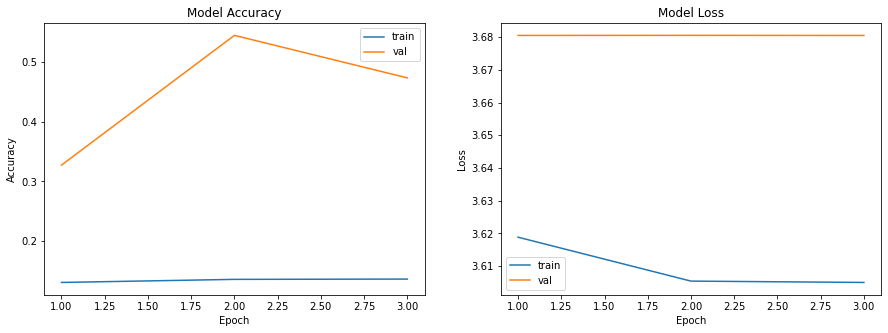

In [55]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(range(1,len(history.history['output_accuracy'])+1),history.history['output_accuracy'])
axs[0].plot(range(1,len(history.history['val_output_accuracy'])+1),history.history['val_output_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(np.arange(1,len(history.history['output_accuracy'])+1),len(history.history['output_accuracy'])/10)
axs[0].legend(['train', 'val'], loc='best')
axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
axs[1].legend(['train', 'val'], loc='best')
plt.show()

# what is happening

In [53]:
y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

print(y_val)
print(y_pred)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:

Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:

Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:

Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:

Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:

Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_241292 in device /job:

In [54]:
y_true = np.where(y_val == 'dog', 1, 0)

print(y_pred)

threshold = 0.5
y_final = []
for i in y_pred:
    if(i[0] > threshold):
        y_final.append(0)
    else:
        y_final.append(1)
y_final = np.array(y_final)

print(y_val)

print(y_true)
print(y_final)

[array([[0.09985361, 0.10043523, 0.10001304, ..., 0.1000241 , 0.09999108,
        0.09999009],
       [0.10006362, 0.10036013, 0.10015582, ..., 0.09991118, 0.10007027,
        0.09986995],
       [0.09979508, 0.10042008, 0.09999079, ..., 0.0998476 , 0.1000786 ,
        0.09981334],
       ...,
       [0.09998304, 0.10051733, 0.0999834 , ..., 0.09990134, 0.09993603,
        0.09996638],
       [0.10003825, 0.10031275, 0.09995217, ..., 0.10020804, 0.09993377,
        0.10002605],
       [0.09983708, 0.10058375, 0.09991672, ..., 0.09973479, 0.10010179,
        0.09979914]], dtype=float32), array([[0.10087329, 0.10258082, 0.10001086, ..., 0.09981121, 0.09985489,
        0.09926238],
       [0.10172032, 0.10298308, 0.09989536, ..., 0.10044558, 0.09890254,
        0.09991156],
       [0.10102358, 0.10260602, 0.09988547, ..., 0.10007852, 0.0993621 ,
        0.09940488],
       ...,
       [0.10063198, 0.10163183, 0.09951692, ..., 0.09980827, 0.09973548,
        0.09947231],
       [0.10184383

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
print(y_final.size, y_true.size)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_final)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_final, target_names=['cat','dog'])

print(report)

In [ ]:
# prepare testing data

test_filenames = os.listdir("./input/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# testing generator

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./input/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

In [ ]:
# predict

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5

In [ ]:
print(predict, type(predict))

test_df['category'] = np.where(predict>threshold, 'dog', 'cat')

In [ ]:
# see predicted result
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./input/test1/test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")